# RNAseq analysis of _D. novameixcana_ females after con- and heterospecific mating

## Introduction

The data files used in this analysis were generated within a Snakemake workflow. RNAseq reads were generated from _D. novamexicana_ female samples (heads, ovaries, reproductive tracts, and gonadecotmized abdomen + thorax) that were either from mated females or virgin females. In addition, male _D. novamexicana_ RNAseq reads from a previous study were included in the analysis. 

First, reads were mapped to the virilis genome (dvir1.06) with HISAT and abundance estimates were derived. Second, the transcriptome structure produced by the genome mapping was utilized in making a canonical genome-based transcriptome that was also queried for abundance with eXpress. Finally, mapped and unmapped reads were used to generate a genome-guided transcriptome assembly and a _de novo_ transcriptome assembly, respectively, using Trinity. Transcripts from both Trinity runs were merged and abundance estimates for the samples were obtained using eXpress. 

The Trinity transcriptome was used to generate a Trinotate annotation. A similar annotation for the genome-based transcriptome was available from a previous study (Ahmed-Braimah _et al._ 2017). The workflow for these analyses is illustrated below.

<img src="Misc/workflow_dark.png" alt="Drawing" style="width: 1500px;"/>

#### Packages and functions:

The analysis below relies on several R packages and custom functions that are used for plotting and extracting gene-level annotation info. First load the packages:

In [4]:
req_packages = c("Biobase", "cluster", "clusterProfiler","cowplot", "cummeRbund", 
                 "data.table", "DESeq", "edgeR", "ggplot2", "ggpubr", 
                 "ggrepel", "ggthemes", "ggthemr", "Glimma", 
                 "GO.db", "goseq", "gplots", "grid", "gridExtra", "lattice", 
                 "heatmap3", "imager", "pheatmap", "plotly", "qvalue", "RColorBrewer", 
                 "reshape", "Rmisc", "splitstackshape", "statmod", "stringr", "tidyverse",
                 "wesanderson", "VennDiagram", "viridis")

invisible(suppressWarnings(suppressMessages(lapply(req_packages, require, character.only = TRUE))))

# The Cowplot package changes the default themes of ggplot2. Set the bw theme with larger font sizes like so:
theme_set(theme_bw(base_size = 16))


... and the custom functions are in a file:

In [5]:
source("Functions.R")

Suppres excessive VennDiagram's log files:

In [6]:
invisible(futile.logger::flog.threshold(futile.logger::ERROR, name = "VennDiagramLogger"))

There are auxiliary files that need to be created from the raw input files. These processes are executed through a shell script, that we can run like so:

In [7]:
# system('./Misc/initial_file_modifications.sh')

#### Annotation files:

A Trinotate report and accompanying Gene Ontology assignments were produced for the genome-based transcriptome and the Trinity transcriptome. Load those here:

In [8]:
trinotate_annotated = read.csv("Trinotate/Annotated/Trinotate_report_dvir1.06_subset.txt", header = T, sep = "\t", na.strings = "", stringsAsFactors=FALSE)

trinotate_pasa = read.csv("Trinotate/PASA/Trinotate_report_with_description_column.xls", header = T, sep = "\t", na.strings = "", stringsAsFactors=FALSE)

From these reports we also extracted the Gene Ontology (GO) assignments for each gene whenever possible:

In [9]:
GOinfo_annotated = read.table("Trinotate/Annotated/Trinotate_report_dvir1.06_gene_ontology.txt", header=F, row.names=1,stringsAsFactors=F)

GOinfo_pasa = read.table("Trinotate/PASA/Trinotate_report.xls.gene_ontology", header=F, row.names=1,stringsAsFactors=F)

For the genome data the gene IDs were FlyBase gene names (FBgn..), and we have a file that matches their gene names and coordinates:

In [10]:
dv1.06_features = read.table("Annotations/Genome-based/FBgn_ID_name_coordinates.txt", header = T)

From FlyBase we have information on orthology to _D. melanogaster_:

In [11]:
melOrths = read.table(file = "Annotations/Genome-based/mel_orths.txt", header = T)
melOrthsAll = aggregate(mel_GeneSymbol~FBgn_ID, data = melOrths, toString)

We created a features table for the StringTie assembled transcripts:

In [12]:
gene.features = read.csv("StringTie/features.txt", sep = "\t")

We'll need the gene-to-transcript mapping for the annotated transcripts:

In [13]:
FBgn_to_FBtr = read.csv("gffread_annotated_transcriptome/gffread_annotated_transcripts.gene_trans_map", header = F, sep = "\t")
colnames(FBgn_to_FBtr) = c("FBgn_ID", "FBtr_ID")

For the edgeR DGE object, we can add annotation features for easy querying. We'll just need to do this for the Pasa data here:

In [14]:
tTrinotate.sub = unique(subset(trinotate_pasa, select = c("gene_id", "dvir1.06.BLASTX", "sprot_Top_BLASTX_hit_description")))

gene_to_transcript_to_ref = unique(subset(gene.features, select=c("gene_id", "transcript_id", "ref_gene_id")))

all.features = merge(dv1.06_features, gene_to_transcript_to_ref, by.x = "FBgn_ID", by.y = "ref_gene_id", all = T)

tTrinotate.sub.all = merge(all.features, tTrinotate.sub, by.x = "transcript_id", by.y = "dvir1.06.BLASTX", all = T)

tTrinotate.sub.all = unique(subset(tTrinotate.sub.all, select=c("gene_id.y", "gene_id.x", "gene_name", "FBgn_ID", "chromosome", "min", "max", "sprot_Top_BLASTX_hit_description")))

tTrinotate.sub.all = subset(tTrinotate.sub.all, !is.na(gene_id.y))

tTrinotate.sub.some = unique(subset(tTrinotate.sub.all, select = c("gene_id.y", "gene_id.x", "gene_name", "sprot_Top_BLASTX_hit_description")))

Finally, from our previous study (Ahmed-Braimah _et al._ 2017), we'll load the male-biased genes:

In [15]:
male_tissue.biased_gene_factors = read.csv("Annotations/Genome-based/male-tissue.biased-gene-factors.txt", header = T, sep = "\t")
SFPs = filter(male_tissue.biased_gene_factors, status == "SFP")$FBgn_ID
AG_biased = filter(male_tissue.biased_gene_factors, status == "AG-biased")$FBgn_ID
EB_biased = filter(male_tissue.biased_gene_factors, status == "EB-biased")$FBgn_ID
TS_biased = filter(male_tissue.biased_gene_factors, status == "TS-biased")$FBgn_ID

#### Expression files

There are two raw count matrices derived from each of the mapping/abundance steps described above. We'll load each of these:

In [16]:
counts_bt2.fbgn = read.table("Genome/annotated_eXpress/annotated.gene.counts.matrix", header=T, row.names=1, com='', check.names=F)
counts_bt2.pasa = read.table("Trinity/pasa/eXpress/pasa.gene.counts.matrix", header=T, row.names=1, com='', check.names=F)

For each the counts generated by eXpress there're normalized expression matrices in TPM units (we'll have to normalize the counts derived from HISAT2). Load those:

In [17]:
tpm_bt2.fbgn = read.table("Genome/annotated_eXpress/annotated.gene.TMM.EXPR.matrix", header=T, row.names=1, com='', check.names=F)
tpm_bt2.pasa = read.table("Trinity/pasa/eXpress/pasa.gene.TMM.EXPR.matrix", header=T, row.names=1, com='', check.names=F)

We'll need the Trinity gene lengths:

In [18]:
pasa_trans_lengths = read.table("Trinity/pasa/bt2_reference/pasa_transcript_lengths.txt", header = T)

pasa_trans_map = read.table("Trinity/pasa/bt2_reference/compreh_init_build.geneToTrans_mapping", header = F)

pasa_gene_lengths = as.data.table(subset(merge(pasa_trans_lengths, pasa_trans_map, by.x = "transcript_id", by.y = "V2"), select = c("length", "V1")))
colnames(pasa_gene_lengths) = c("length", "gene_id")
pasa_gene_lengths = as.data.frame(pasa_gene_lengths[pasa_gene_lengths[, .I[which.max(length)], by=gene_id]$V1])
rownames(pasa_gene_lengths) <- pasa_gene_lengths$gene_id
pasa_gene_lengths = subset(pasa_gene_lengths, select = "length")

Also load the annotated gene lengths, which we've saved from a previous study:

In [19]:
a.gene_lengths = read.table("Annotations/Genome-based/FBgn_lengths.txt", header=T, row.names=1)

#### Miscellaneous files:

For the differential expression analysis we will need the sample-to-replicate mapping and any additional sample information:

In [20]:
sampleData = read.table("Misc/samples.txt", header=F, check.names=F, fill=T)
sampleData = sampleData[sampleData[,2] != '',]

From the above we can produce a detailed sample information object:

In [21]:
sampleInfo = sampleData
colnames(sampleInfo) = c("SampleName", "Replicate")

sampleInfo$Sex = ifelse(grepl("Female",sampleInfo$SampleName), "female", "male")

sampleInfo$Tissue = ifelse(grepl("RT",sampleInfo$Replicate), "repTract", ifelse(grepl("_H_",sampleInfo$Replicate), "head", ifelse(grepl("_OV_",sampleInfo$Replicate), "ovaries", ifelse(grepl("_CR_",sampleInfo$Replicate), "carcass", ifelse(grepl("AG",sampleInfo$Replicate), "acGlnds", ifelse(grepl("EB",sampleInfo$Replicate), "ejBulb", "testes"))))))

sampleInfo$Status = ifelse(grepl("Female_C", sampleInfo$Replicate) | grepl("Male", sampleInfo$Replicate), "conspecific", ifelse(grepl("Female_V", sampleInfo$Replicate), "virgin", "heterospecific"))

sampleInfo$Time = ifelse(grepl("Female_V", sampleInfo$SampleName), "virgin", ifelse(grepl("3", sampleInfo$SampleName), "3hpm", ifelse(grepl("6",sampleInfo$SampleName), "6hpm", ifelse(grepl("12",sampleInfo$SampleName), "12hpm", "24hpm"))))

Because we're using both the genome- and trinity-based expression data, it would be convenient to compare the results between both analyses. For that we made a BLAST file between transcripts of both strategies (header line added manually). We also made perform a recirpocal BLAST search between the two transcript sets. We'l load those here:

In [22]:
pasa_v_annotated_blast = read.table("Misc/BLASTn.pasa_vs_annotated.outfmt6", header = T, sep = "\t")
pasa_v_genome_blast = read.table("Misc/BLASTn.pasa_vs_genome.outfmt6.txt", header = T, sep = "\t")
pasa_v_genome_blast_sub = read.table("Misc/BLASTn.pasa_vs_genome.outfmt6_one_to_one.txt", header = F, sep = "\t")
pasa_v_genome_rbh = read.table("Misc/dvir1.06_v_pasa.RBH.tsv", header = T, sep = "\t")

We also have useful population genetic data from a previous study that we can use later on:

In [23]:
paml.data = read.csv(file = "Annotations/Genome-based/PAML.branchSite.ALL.results.txt", header = T, sep = "\t")
KaKs.data = read.csv(file = "Annotations/Genome-based/KaKs.ALL.results.txt", header = T, sep = "\t", check.names = F)

We also generated a new set, which includes _D. montana_ as an outgroup (we ran the RT data and AG data separately):

In [24]:
RT_paml.data = read.csv("Results/PopGen/ANLVM.paml.brSt.RT_results_mod.txt", header = T, sep = "\t")
RT_paml.data = tidyr::spread(RT_paml.data, Sample, lnL)

RT_paml.omega.data = read.csv("Results/PopGen/ANLVM.paml.omega.RT_results_mod.txt", header = T, sep = "\t")
colnames(RT_paml.omega.data) = c("FBtr_ID", "omega")

RT_paml.data = merge(RT_paml.data, RT_paml.omega.data, by.x = "FBtr_ID", by.y = "FBtr_ID", all = T)
rm(RT_paml.omega.data)

RT_KaKs.data = read.csv(file = "Results/PopGen/ANLVM.pairwise.KaKs.RT_results.txt", header = T, sep = "\t", check.names = F)

In [25]:
AG_paml.data = read.csv("Results/PopGen/ANLVM.paml.brSt.AG_results_mod.txt", header = T, sep = "\t")
AG_paml.data = tidyr::spread(AG_paml.data, Sample, lnL)

AG_paml.omega.data = read.csv("Results/PopGen/ANLVM.paml.omega.AG_results_mod.txt", header = T, sep = "\t")
colnames(AG_paml.omega.data) = c("FBtr_ID", "omega")

AG_paml.data = merge(AG_paml.data, AG_paml.omega.data, by.x = "FBtr_ID", by.y = "FBtr_ID", all = T)
rm(AG_paml.omega.data)

AG_KaKs.data = read.csv(file = "Results/PopGen/ANLVM.pairwise.KaKs.AG_results.txt", header = T, sep = "\t", check.names = F)

We'll calculate the LRT for this new PAML dataset:

In [26]:
#### Calaculate LRT, pValues and FDR for RT_paml data
RT_paml.data$Damr_LRT = 2*(RT_paml.data$Damr_ML95_H1 - RT_paml.data$Damr_ML95_H0)
RT_paml.data$Damr_pValue = pchisq(q = RT_paml.data$Damr_LRT, df = 1, lower.tail = F)
RT_paml.data$Damr_FDR = p.adjust(p = RT_paml.data$Damr_pValue, method = "fdr")

RT_paml.data$Dlum_LRT = 2*(RT_paml.data$Dlum_LM8_H1 - RT_paml.data$Dlum_LM8_H0)
RT_paml.data$Dlum_pValue = pchisq(q = RT_paml.data$Dlum_LRT, df = 1, lower.tail = F)
RT_paml.data$Dlum_FDR = p.adjust(p = RT_paml.data$Dlum_pValue, method = "fdr")

RT_paml.data$Dnov_LRT = 2*(RT_paml.data$Dnov_4_H1 - RT_paml.data$Dnov_4_H0)
RT_paml.data$Dnov_pValue = pchisq(q = RT_paml.data$Dnov_LRT, df = 1, lower.tail = F)
RT_paml.data$Dnov_FDR = p.adjust(p = RT_paml.data$Dnov_pValue, method = "fdr")

RT_paml.data$Dvir_LRT = 2*(RT_paml.data$Dvir_S9_H1 - RT_paml.data$Dvir_S9_H0)
RT_paml.data$Dvir_pValue = pchisq(q = RT_paml.data$Dvir_LRT, df = 1, lower.tail = F)
RT_paml.data$Dvir_FDR = p.adjust(p = RT_paml.data$Dvir_pValue, method = "fdr")

RT_paml.data$Dmon_LRT = 2*(RT_paml.data$Dmon_Oul_H1 - RT_paml.data$Dmon_Oul_H0)
RT_paml.data$Dmon_pValue = pchisq(q = RT_paml.data$Dmon_LRT, df = 1, lower.tail = F)
RT_paml.data$Dmon_FDR = p.adjust(p = RT_paml.data$Dmon_pValue, method = "fdr")

In [27]:
#### Calaculate LRT, pValues and FDR for AG_paml data
AG_paml.data$Damr_LRT = 2*(AG_paml.data$Damr_ML95_H1 - AG_paml.data$Damr_ML95_H0)
AG_paml.data$Damr_pValue = pchisq(q = AG_paml.data$Damr_LRT, df = 1, lower.tail = F)
AG_paml.data$Damr_FDR = p.adjust(p = AG_paml.data$Damr_pValue, method = "fdr")

AG_paml.data$Dlum_LRT = 2*(AG_paml.data$Dlum_LM8_H1 - AG_paml.data$Dlum_LM8_H0)
AG_paml.data$Dlum_pValue = pchisq(q = AG_paml.data$Dlum_LRT, df = 1, lower.tail = F)
AG_paml.data$Dlum_FDR = p.adjust(p = AG_paml.data$Dlum_pValue, method = "fdr")

AG_paml.data$Dnov_LRT = 2*(AG_paml.data$Dnov_4_H1 - AG_paml.data$Dnov_4_H0)
AG_paml.data$Dnov_pValue = pchisq(q = AG_paml.data$Dnov_LRT, df = 1, lower.tail = F)
AG_paml.data$Dnov_FDR = p.adjust(p = AG_paml.data$Dnov_pValue, method = "fdr")

AG_paml.data$Dvir_LRT = 2*(AG_paml.data$Dvir_S9_H1 - AG_paml.data$Dvir_S9_H0)
AG_paml.data$Dvir_pValue = pchisq(q = AG_paml.data$Dvir_LRT, df = 1, lower.tail = F)
AG_paml.data$Dvir_FDR = p.adjust(p = AG_paml.data$Dvir_pValue, method = "fdr")

AG_paml.data$Dmon_LRT = 2*(AG_paml.data$Dmon_Oul_H1 - AG_paml.data$Dmon_Oul_H0)
AG_paml.data$Dmon_pValue = pchisq(q = AG_paml.data$Dmon_LRT, df = 1, lower.tail = F)
AG_paml.data$Dmon_FDR = p.adjust(p = AG_paml.data$Dmon_pValue, method = "fdr")

Let's combine those two for convenience:

In [28]:
AG_paml.data$status = "AG_biased"
RT_paml.data$status = "RT_biased"
paml2.data = rbind(AG_paml.data, RT_paml.data)

Also combine the pairwise KaKs data:

In [29]:
AG_KaKs.data$status = "AG_biased"
RT_KaKs.data$status = "RT_biased"
KaKs2.data = rbind(AG_KaKs.data, RT_KaKs.data)

Create lists of transcripts that have an LRT FDR value < 0.01:

In [30]:
Damr.lrt.sig = filter(paml2.data, Damr_FDR < 0.01)$FBtr_ID
Dnov.lrt.sig = filter(paml2.data, Dnov_FDR < 0.01)$FBtr_ID
Dlum.lrt.sig = filter(paml2.data, Dlum_FDR < 0.01)$FBtr_ID
Dvir.lrt.sig = filter(paml2.data, Dvir_FDR < 0.01)$FBtr_ID
Dmon.lrt.sig = filter(paml2.data, Dmon_FDR < 0.01)$FBtr_ID

For some gene name entries we might want a unique 1-to-1 matching of gene ID's. We can do that like so:

In [31]:
fbgn_to_geneName = unique(subset(dv1.06_features, select = c("FBgn_ID", "gene_name")))
geneID_to_fbgn = unique(subset(gene.features, select = c("gene_id", "ref_gene_id")))
IDz = merge(fbgn_to_geneName, geneID_to_fbgn, by.x = "FBgn_ID", by.y = "ref_gene_id", all = T)

For the PASA transcripts, we can use the blast result to match pasa gene ids with their corresponding hisat2 gene id:

In [32]:
transcript.features = unique(subset(gene.features, select = c("transcript_id", "gene_id", "ref_gene_id")))

intFile1 = merge(pasa_v_genome_blast_sub, transcript.features, by.x = "V2", by.y = "transcript_id", all.x = T)

intFile2 = suppressWarnings(merge(intFile1, pasa_trans_map, by.x = "V1", by.y = "V2", all.x = T))
colnames(intFile2) = c("pasa_transcript_id", "hisat2_transcript_id", "hisat2_gene_id", "ref_gene_id", "pasa_gene_id")

intFile3 = unique(subset(intFile2, select = c("pasa_gene_id", "hisat2_gene_id")))

pasa_to_hisat2_mapping = aggregate(hisat2_gene_id~pasa_gene_id, data = intFile3, toString)

rm(intFile1, intFile2, intFile3)

We'll make a couple of TPM tables for gene level and heatmap plotting:

In [33]:
## For annotated bt2 data
TPMmatrix <- tpm_bt2.fbgn
TPMmatrix.m <- as.data.frame(melt(as.matrix(TPMmatrix)))
TPMmatrix.m = merge(TPMmatrix.m, sampleData, by.x = "X2", "V2")
colnames(TPMmatrix.m) <- c("replicate_id", "gene_id", "TPM", "sample")
TPMmatrix.m$replicate = ifelse(grepl("_1", TPMmatrix.m$replicate_id), "1", ifelse(grepl("_2", TPMmatrix.m$replicate_id), "2", "3"))
TPMmatrix.m = merge(TPMmatrix.m, fbgn_to_geneName, by.x = "gene_id", by.y = "FBgn_ID")
TPMmatrix.m = merge(TPMmatrix.m, sampleInfo, by.x = "replicate_id", by.y = "Replicate")
tpmTable_bt2.fbgn = subset(TPMmatrix.m, select = c("gene_id", "gene_name","sample", "replicate_id", "replicate", "Sex", "Tissue", "Status", "Time", "TPM"))
colnames(tpmTable_bt2.fbgn) = c("FBgn_ID", "gene_name","sample", "replicate_id", "replicate", "Sex", "Tissue", "Status", "Time", "TPM")
rm(TPMmatrix.m, TPMmatrix)

tpmSE_bt2.fbgn = summarySE(tpmTable_bt2.fbgn, measurevar = "TPM", groupvars = c("FBgn_ID", "gene_name","sample", "Sex", "Tissue", "Status", "Time"))

# write.table(tpmSE_bt2.fbgn, "Trinity/fbgn/eXpress/tpmSE_bt2.fbgn.txt", quote = F, sep = "\t", row.names = F)
# tpmSE_bt2.fbgn = read.table("Trinity/fbgn/eXpress/tpmSE_bt2.fbgn.txt", header = T, sep = "\t")

tmpMat<-cast(tpmSE_bt2.fbgn, FBgn_ID~sample, value ="TPM", fun.aggregate = mean)
tpmMatrix_bt2.fbgn <- tmpMat[,-1]
rownames(tpmMatrix_bt2.fbgn) <- tmpMat[,1]
rm(tmpMat)

In [34]:
## For pasa data
TPMmatrix <- tpm_bt2.pasa
TPMmatrix.m <- as.data.frame(melt(as.matrix(TPMmatrix)))
TPMmatrix.m = merge(TPMmatrix.m, sampleData, by.x = "X2", "V2")
colnames(TPMmatrix.m) <- c("replicate_id", "gene_id", "TPM", "sample")
TPMmatrix.m$replicate = ifelse(grepl("_1", TPMmatrix.m$replicate_id), "1", ifelse(grepl("_2", TPMmatrix.m$replicate_id), "2", "3"))
TPMmatrix.m = merge(TPMmatrix.m, pasa_to_hisat2_mapping, by.x = "gene_id", by.y = "pasa_gene_id", all.x = T)
TPMmatrix.m = merge(TPMmatrix.m, sampleInfo, by.x = "replicate_id", by.y = "Replicate")
tpmTable_bt2.pasa = subset(TPMmatrix.m, select = c("gene_id", "hisat2_gene_id","sample", "replicate_id", "replicate", "Sex", "Tissue", "Status", "Time", "TPM"))
rm(TPMmatrix.m, TPMmatrix)

# tpmSE_bt2.pasa = summarySE(tpmTable_bt2.pasa, measurevar = "TPM", groupvars = c("gene_id", "hisat2_gene_id","sample", "Sex", "Tissue", "Status", "Time"))

# write.table(tpmSE_bt2.pasa, "Trinity/pasa/eXpress/tpmSE_bt2.pasa.txt", quote = F, sep = "\t", row.names = F)
tpmSE_bt2.pasa = read.table("Trinity/pasa/eXpress/tpmSE_bt2.pasa.txt", header = T, sep = "\t")


tmpMat<-cast(tpmSE_bt2.pasa, gene_id~sample, value ="TPM", fun.aggregate = mean)
tpmMatrix_bt2.pasa <- tmpMat[,-1]
rownames(tpmMatrix_bt2.pasa) <- tmpMat[,1]
rm(tmpMat)

We'll also need to set the factor level so that the order of samples on a plot makes sense:

In [35]:
## annotated eXpress
## For TPMse table
tpmSE_bt2.fbgn$Tissue = factor(tpmSE_bt2.fbgn$Tissue, levels = c("head", "carcass", "ovaries", "repTract", "testes", "acGlnds", "ejBulb"))
tpmSE_bt2.fbgn$Sex = factor(tpmSE_bt2.fbgn$Sex, levels = c("female", "male"))
tpmSE_bt2.fbgn$Status = factor(tpmSE_bt2.fbgn$Status, levels = c("virgin", "conspecific", "heterospecific"))
tpmSE_bt2.fbgn$Time = factor(tpmSE_bt2.fbgn$Time, levels = c("virgin", "3hpm", "6hpm", "12hpm", "24hpm"))

## and for raw TPM table
tpmTable_bt2.fbgn$Tissue = factor(tpmTable_bt2.fbgn$Tissue, levels = c("head", "carcass", "ovaries", "repTract", "testes", "acGlnds", "ejBulb"))
tpmTable_bt2.fbgn$Sex = factor(tpmTable_bt2.fbgn$Sex, levels = c("female", "male"))
tpmTable_bt2.fbgn$Status = factor(tpmTable_bt2.fbgn$Status, levels = c("virgin", "conspecific", "heterospecific"))
tpmTable_bt2.fbgn$Time = factor(tpmTable_bt2.fbgn$Time, levels = c("virgin", "3hpm", "6hpm", "12hpm", "24hpm"))

In [36]:
## PASA
## For TPMse table
tpmSE_bt2.pasa$Tissue = factor(tpmSE_bt2.pasa$Tissue, levels = c("head", "carcass", "ovaries", "repTract", "testes", "acGlnds", "ejBulb"))
tpmSE_bt2.pasa$Sex = factor(tpmSE_bt2.pasa$Sex, levels = c("female", "male"))
tpmSE_bt2.pasa$Status = factor(tpmSE_bt2.pasa$Status, levels = c("virgin", "conspecific", "heterospecific"))
tpmSE_bt2.pasa$Time = factor(tpmSE_bt2.pasa$Time, levels = c("virgin", "3hpm", "6hpm", "12hpm", "24hpm"))

## and for raw TPM table
tpmTable_bt2.pasa$Tissue = factor(tpmTable_bt2.pasa$Tissue, levels = c("head", "carcass", "ovaries", "repTract", "testes", "acGlnds", "ejBulb"))
tpmTable_bt2.pasa$Sex = factor(tpmTable_bt2.pasa$Sex, levels = c("female", "male"))
tpmTable_bt2.pasa$Status = factor(tpmTable_bt2.pasa$Status, levels = c("virgin", "conspecific", "heterospecific"))
tpmTable_bt2.pasa$Time = factor(tpmTable_bt2.pasa$Time, levels = c("virgin", "3hpm", "6hpm", "12hpm", "24hpm"))

## Quality Assessment and Filtering:

We need to look at seevral QC metrics for our count data. First we'll look at the variation in library sizes across the thee analyses:

In [37]:
a.bt2LibSizes <- as.data.frame(colSums(counts_bt2.fbgn))
pasa.LibSizes <- as.data.frame(colSums(counts_bt2.pasa))
libSizes = cbind(a.bt2LibSizes, pasa.LibSizes)
libSizes <- cbind(sample = row.names(libSizes), libSizes)
row.names(libSizes)<- NULL
colnames(libSizes) = c("sample", "Bowtie2 (annotated)", "Bowtie2 (PASA)")
libSizes = melt(libSizes, id.vars = "sample")
colnames(libSizes) = c("sample", "mapping_method", "mapped_reads")

Now make barplots of the mapped reads across samples and mapping methods:

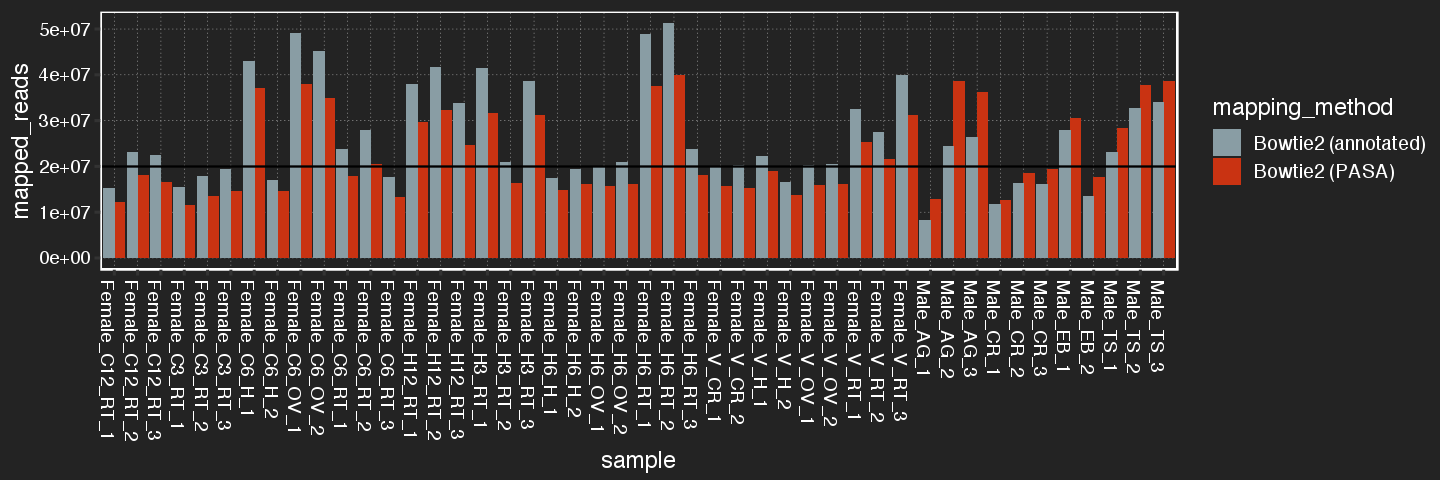

In [38]:
options(repr.plot.width = 12, repr.plot.height = 4)
# pdf("Figures/Library_sizes.pdf", width = 12, height = 4)
ggplot(libSizes, aes(sample, mapped_reads, fill = mapping_method)) + 
    geom_bar(stat="identity", position = "dodge") + 
    theme_monokai_full() +
    theme(axis.text.x = element_text(angle = -90, hjust = 0)) + 
    geom_hline(yintercept = 20000000) +
    scale_fill_manual(values = wes_palette("Royal1"))
# dev.off()

A couple of things to note here. Not surprisingly, the Trinity mapping has the highest number of mapped reads across samples, while the HISAT2 genome mapping has the lowest (this is reflected in the percentage of mapping as well; see the MultiQC output from the Snakemake pipeline). Another thing to note is that, for the paired-end male data, there is no difference in the number of mapped reads between the HISAT2 and Trinity bowtie2 alignments, suggesting the genome divergence issues are mitigated by paired-end data. 

Now we can look at the appropriate cutoffs for filtering using Brian Haas' method. To do this we count the genes acrtoss a range of minimum TPM values. The eXpress output we used generates a file that can be used to generate this matrix (see Trinity online guidelines). We'll load those two files for the genom- and Trinity-based analyses:

In [39]:
a.bt2_cbmt = read.table("Genome/annotated_eXpress/annotated.gene.TPM.not_cross_norm.counts_by_min_TPM", header = T)
pasa.bt2_cbmt = read.table("Trinity/pasa/eXpress/pasa.gene.TPM.not_cross_norm.counts_by_min_TPM", header = T)

First extract the "expressed genes" (in this case, between 10 and 100 TPM):

In [40]:
a.bt2_cbmt.sub = a.bt2_cbmt[a.bt2_cbmt[,1] > -100 & a.bt2_cbmt[,1] < -10,]
pasa.bt2_cbmt.sub = pasa.bt2_cbmt[pasa.bt2_cbmt[,1] > -100 & pasa.bt2_cbmt[,1] < -10,]

Now we a perform a linear regression on this filtered subset of the data and display the value of the Y-intercept:

In [41]:
a.bt2_cbmt.sub_fit = lm(a.bt2_cbmt.sub[,2] ~ a.bt2_cbmt.sub[,1])
print(a.bt2_cbmt.sub_fit)

pasa.bt2_cbmt.sub_fit = lm(pasa.bt2_cbmt.sub[,2] ~ pasa.bt2_cbmt.sub[,1])
print(pasa.bt2_cbmt.sub_fit)


Call:
lm(formula = a.bt2_cbmt.sub[, 2] ~ a.bt2_cbmt.sub[, 1])

Coefficients:
        (Intercept)  a.bt2_cbmt.sub[, 1]  
           11534.67                76.03  


Call:
lm(formula = pasa.bt2_cbmt.sub[, 2] ~ pasa.bt2_cbmt.sub[, 1])

Coefficients:
           (Intercept)  pasa.bt2_cbmt.sub[, 1]  
               18918.9                   149.8  



Combine both matrices before plotting:

Warning message:
"Removed 2674 rows containing missing values (geom_point)."

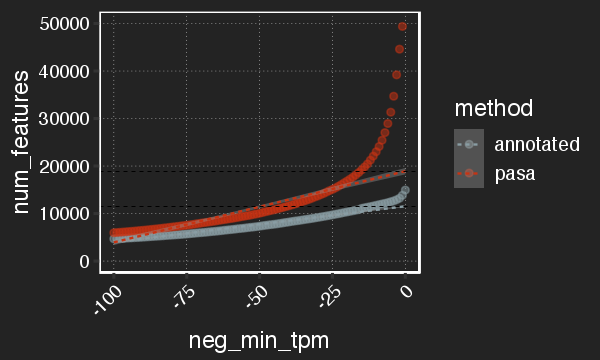

In [42]:
a.bt2_cbmt.sub$method = "annotated"
pasa.bt2_cbmt.sub$method = "pasa"
cbmtSub = rbind(a.bt2_cbmt.sub,pasa.bt2_cbmt.sub)

a.bt2_cbmt$method = "annotated"
pasa.bt2_cbmt$method = "pasa"
cbmtMatrix = rbind(a.bt2_cbmt,pasa.bt2_cbmt)

options(repr.plot.width = 5, repr.plot.height = 3)
# pdf("Figures/filtering_cutoff.pdf", width = 5, height = 3)
ggplot(cbmtMatrix, aes(neg_min_tpm, num_features, colour = method)) + 
    geom_point(alpha = 0.5) +  
    scale_x_continuous(limits=c(-100,0)) + 
    scale_y_continuous(limits=c(0,50000)) + 
    geom_smooth(data=cbmtSub, method = "lm",fullrange=TRUE, size = 0.5, linetype = "dashed") + 
    geom_hline(yintercept = 18918.9, linetype = "dashed", size = 0.2) + 
    geom_hline(yintercept = 11534.67, linetype = "dashed", size = 0.2) + 
#     ggtitle("Expressed genes", subtitle = "Decide cutoff of expressed genes") +
    scale_colour_manual(values = wes_palette("Royal1")) + 
    theme_monokai_full()
# dev.off()

In the Trinity analysis, out of 105593 "genes", roughly 35000 should remain after filtering lowly expressed genes. Simmilarly, 13000 out of ~20000 genes should remain in the genome analysis. Filtering should be performed on subsetted matrices for each analysis later because the threshold for the whole matrix tends to be too high, but we'll see what it is here. First, obtain the counts per million "CPM" matrix:

In [43]:
cpm_bt2.fbgn <- cpm(counts_bt2.fbgn)
cpm_bt2.pasa <- cpm(counts_bt2.pasa)

For now, let's set the minimum CPM to 10, and generate a logical matrix for CPM > 10:

In [44]:
thresh_bt2.fbgn <- cpm_bt2.fbgn > 10
thresh_bt2.pasa <- cpm_bt2.pasa > 10

We would like to keep genes that have at least 2 "TRUE"s in each row of thresh:

In [45]:
keep_bt2.fbgn <- rowSums(thresh_bt2.fbgn) >= 2
keep_bt2.pasa<- rowSums(thresh_bt2.pasa) >= 2

Now we subset the rows of the counts matrix to keep genes that satisfy our filter, then check how many genes are left:

In [46]:
countsKeep_bt2.fbgn <- counts_bt2.fbgn[keep_bt2.fbgn,]
dim(countsKeep_bt2.fbgn)

countsKeep_bt2.pasa <- counts_bt2.pasa[keep_bt2.pasa,]
dim(countsKeep_bt2.pasa)

[1] 11301    46

[1] 19942    46

So a filter of 10 CPM brings the count matrix to the expected number of genes using Brian Haas' method. We would like to know what the CPM values correspond to in terms of raw counts. To do this, we'll plot CPM vs. counts for each sample. (look at the last 30)

In [47]:
# options(repr.plot.width = 9, repr.plot.height = 8)
# par(mfrow=c(5,6))
# for(i in seq(from=17, to=46, by=1)){
#   plot(cpm_bt2.fbgn[,i],counts_bt2.fbgn[,i], xlim=c(0,10), ylim=c(0,200), xlab = "CPM", ylab = "count")
#   title(colnames(cpm_bt2.fbgn)[i])
# }

There's a range of correpondence between CPM values and raw counts. In general 10CPM seems to correspond to ~200 in raw counts.

## Differential Expression

### Tissue-biased genes

In the first portion of the differential expression analysis we'll look at genes that show tissue-biased expression in females. We'll perform this analysis on the genome-based transcriptome.

First we'll subset the matrix to include virgin female tissue samples.

In [48]:
counts_bt2.fbgn.femVirgin = subset(counts_bt2.fbgn, select=grepl("Female_V", colnames(counts_bt2.fbgn)))

# alternative including male tissues
counts_bt2.fbgn.tissues = subset(counts_bt2.fbgn, select=grepl("Female_V|Male", colnames(counts_bt2.fbgn)))

Now we can filter out low expression genes with a minimum 5 cpm cutoff (NOTE: Setting the threshold column number to 3 dramatically changes the number of tissue biased genes in this section).

In [49]:
cpm_bt2.fbgn.tissues <- cpm(counts_bt2.fbgn.tissues)
thresh_v.bt2.fbgn <- cpm_bt2.fbgn.tissues > 5
## look at number of columns with above requirements
table(rowSums(thresh_v.bt2.fbgn))

countsKeep_v.bt2.fbgn <- rowSums(thresh_v.bt2.fbgn) >= 2
countsFiltered_bt2.fbgn.tissues <- counts_bt2.fbgn.tissues[countsKeep_v.bt2.fbgn,]
## Check how many genes remain in the matrix.
dim(countsFiltered_bt2.fbgn.tissues)


## Clean-up
rm(cpm_bt2.fbgn.tissues, countsKeep_v.bt2.fbgn, thresh_v.bt2.fbgn)


   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
2637  364  678 2033  401  654  479  402  357  313  385  348  404  317  394  442 
  16   17   18   19   20 
 335  467  499  326 2709 

[1] 11943    20

Let's make a specificity table from the TPM values that only includes genes that pass this filter:

In [50]:
specificity_table <- subset(tpmMatrix_bt2.fbgn, select=grepl("Female_V|Male", colnames(tpmMatrix_bt2.fbgn)))
specificity_table <- subset(specificity_table, rownames(specificity_table) %in% rownames(countsFiltered_bt2.fbgn.tissues))
specificity_table <- suppressWarnings(calcSpecificity(specificity_table))

We'll also subset the samplesData object to only include the virgin tissue and male samples:

In [51]:
sampleInfo.v = subset(sampleInfo, Status == "virgin")

# alternative including male tissues
sampleInfo.tissue = subset(sampleInfo, Status == "virgin" | Sex == "male")

Add a column to include the reproductive tract, head and ovary samples, so we can compare against everything else

In [52]:
sampleInfo.tissue$repTractFactor = ifelse(sampleInfo.tissue$Tissue == "repTract", "fRT", "not.fRT")
sampleInfo.tissue$ovariesFactor = ifelse(sampleInfo.tissue$Tissue == "ovaries", "ovaries", "not.ovaries")
sampleInfo.tissue$fHeadFactor = ifelse(sampleInfo.tissue$Tissue == "head", "fHead", "not.fHead")

We can now define groups for differential expression:

In [53]:
# all samples:
groups.v = factor(sampleInfo.tissue$Tissue)
design.v = model.matrix( ~ 0 + groups.v)
colnames(design.v) <- levels(groups.v)
rownames(design.v) <- sampleInfo.tissue$Replicate

# female rep. tract:
groups.fRT = factor(sampleInfo.tissue$repTractFactor)
design.fRT = model.matrix( ~ 0 + groups.fRT)
colnames(design.fRT) <- levels(groups.fRT)
rownames(design.fRT) <- sampleInfo.tissue$Replicate

# female head:
groups.fHead = factor(sampleInfo.tissue$fHeadFactor)
design.fHead = model.matrix( ~ 0 + groups.fHead)
colnames(design.fHead) <- levels(groups.fHead)
rownames(design.fHead) <- sampleInfo.tissue$Replicate

# ovaries:
groups.ovaries = factor(sampleInfo.tissue$ovariesFactor)
design.ovaries = model.matrix( ~ 0 + groups.ovaries)
colnames(design.ovaries) <- levels(groups.ovaries)
rownames(design.ovaries) <- sampleInfo.tissue$Replicate

Now we'll create the DGE object and fit the general linear model:

In [54]:
dgeList.v <- DGEList(counts = countsFiltered_bt2.fbgn.tissues, group = groups.v)
dgeList.v <- calcNormFactors(dgeList.v)
dgeList.v <- estimateCommonDisp(dgeList.v)
dgeList.v <- estimateTagwiseDisp(dgeList.v)
dgeList.v_fit <- glmFit(dgeList.v, design.v)

dgeList.fRT <- DGEList(counts = countsFiltered_bt2.fbgn.tissues, group = groups.fRT)
dgeList.fRT <- calcNormFactors(dgeList.fRT)
dgeList.fRT <- estimateCommonDisp(dgeList.fRT)
dgeList.fRT <- estimateTagwiseDisp(dgeList.fRT)
dgeList.fRT_fit <- glmFit(dgeList.fRT, design.fRT)

dgeList.fHead <- DGEList(counts = countsFiltered_bt2.fbgn.tissues, group = groups.fHead)
dgeList.fHead <- calcNormFactors(dgeList.fHead)
dgeList.fHead <- estimateCommonDisp(dgeList.fHead)
dgeList.fHead <- estimateTagwiseDisp(dgeList.fHead)
dgeList.fHead_fit <- glmFit(dgeList.fHead, design.fHead)

dgeList.ovaries <- DGEList(counts = countsFiltered_bt2.fbgn.tissues, group = groups.ovaries)
dgeList.ovaries <- calcNormFactors(dgeList.ovaries)
dgeList.ovaries <- estimateCommonDisp(dgeList.ovaries)
dgeList.ovaries <- estimateTagwiseDisp(dgeList.ovaries)
dgeList.ovaries_fit <- glmFit(dgeList.ovaries, design.ovaries)

We can add annotation information to the fit object, and put it in the genes slot:

In [55]:
Annots = merge(merge(melOrthsAll, trinotate_annotated, all=TRUE), dv1.06_features, all=TRUE)
annot.sum = unique(subset(Annots, select=c("FBgn_ID", "gene_name", "SwissProt_BlastX_Description")))
annot.sum = aggregate(SwissProt_BlastX_Description ~ FBgn_ID + gene_name, data = annot.sum, toString)

now create the annotation object:

In [56]:
# Extract annotation for genes in the fit object
ann.v = subset(annot.sum, FBgn_ID %in% rownames(dgeList.v_fit))
# convert factors to characters
ann.v = data.frame(lapply(ann.v, as.character), stringsAsFactors=FALSE)
# align the fit object's rownames with gene ID's
ann.v = ann.v[match(rownames(dgeList.v_fit), ann.v$FBgn_ID),]
# convert factors to characters, again
ann.v <- data.frame(lapply(ann.v, as.character), stringsAsFactors=FALSE)
# Rename "FBgn_ID" as "GeneID"
colnames(ann.v) = c ("GeneID", "gene_name", "SwissProt_BlastX_Description")
# Check that the fit rownames match the annotation file's gene ID's
table(ann.v$GeneID==rownames(dgeList.v_fit))
# Add the annotations to the fit object in the "genes" slot
dgeList.v_fit$genes = ann.v


 TRUE 
11943 

Do that for the fRT, ovaries and head dgeList as well:

In [57]:
ann.fRT = subset(annot.sum, FBgn_ID %in% rownames(dgeList.fRT_fit))
ann.fRT = data.frame(lapply(ann.fRT, as.character), stringsAsFactors=FALSE)
ann.fRT = ann.fRT[match(rownames(dgeList.fRT_fit), ann.fRT$FBgn_ID),]
ann.fRT <- data.frame(lapply(ann.fRT, as.character), stringsAsFactors=FALSE)
colnames(ann.fRT) = c ("GeneID", "gene_name", "SwissProt_BlastX_Description")
dgeList.fRT_fit$genes = ann.fRT

ann.fHead = subset(annot.sum, FBgn_ID %in% rownames(dgeList.fHead_fit))
ann.fHead = data.frame(lapply(ann.fHead, as.character), stringsAsFactors=FALSE)
ann.fHead = ann.fHead[match(rownames(dgeList.fHead_fit), ann.fHead$FBgn_ID),]
ann.fHead <- data.frame(lapply(ann.fHead, as.character), stringsAsFactors=FALSE)
colnames(ann.fHead) = c ("GeneID", "gene_name", "SwissProt_BlastX_Description")
dgeList.fHead_fit$genes = ann.fHead

ann.ovaries = subset(annot.sum, FBgn_ID %in% rownames(dgeList.ovaries_fit))
ann.ovaries = data.frame(lapply(ann.ovaries, as.character), stringsAsFactors=FALSE)
ann.ovaries = ann.ovaries[match(rownames(dgeList.ovaries_fit), ann.ovaries$FBgn_ID),]
ann.ovaries <- data.frame(lapply(ann.ovaries, as.character), stringsAsFactors=FALSE)
colnames(ann.ovaries) = c ("GeneID", "gene_name", "SwissProt_BlastX_Description")
dgeList.ovaries_fit$genes = ann.ovaries

Looks good. Now let's look at sample groupings using a multidimensional scaling plot (try 'method = "bcv"' for a different type of grouping):

In [58]:
glMDSPlot(dgeList.v, groups = dgeList.v$samples$group, labels = sampleInfo.tissue$Replicate)

Replicates are grouping correctly. Another way to look at grouping is a heatmap of sample correlations:

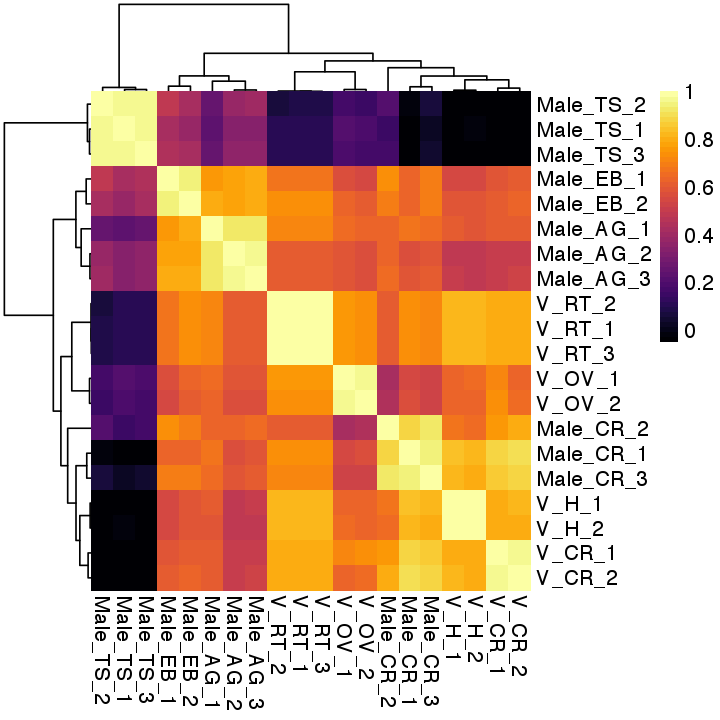

In [59]:
## Plot sample correlation
data = log2(countsFiltered_bt2.fbgn.tissues+1)
colnames(data) = gsub("Female_", "", colnames(data))
data = as.matrix(data)
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')

# options(repr.plot.width = 3.75, repr.plot.height = 3)
options(repr.plot.width = 6, repr.plot.height = 6)
pheatmap(
  mat               = sample_cor,
  color             = inferno(50),
  border_color      = NA,
  show_colnames     = TRUE,
  show_rownames     = TRUE,
#   filename          = "Figures/repTract_sample_correlations.pdf",
#   width             = 6, 
#   height            = 5,
  fontsize          = 12    
)

Now we can identify genes that show tissue-biased expression. First, we define the relevant contrasts. We'll need to define a set of three contrasts for each tissue:

In [60]:
cont.v.repTract <- makeContrasts(V_RT.vs.V_CR=repTract-carcass,
                                 V_RT.vs.V_HD=repTract-head,
                                 V_RT.vs.V_OV=repTract-ovaries,
                                 levels=design.v)

cont.v.ovaries <- makeContrasts(V_OV.vs.V_CR=ovaries-carcass,
                                V_OV.vs.V_HD=ovaries-head,
                                V_OV.vs.V_RT=ovaries-repTract,
                                levels=design.v)
cont.v.head <- makeContrasts(V_H.vs.V_CR=head-carcass,
                             V_H.vs.V_OV=head-ovaries,
                             V_H.vs.V_RT=head-repTract,
                             levels=design.v)

An alternative way is to use the dgeList object for the central tissue versus all other tissues, including male tissues:

In [61]:
repTract_contrast <- makeContrasts(fRT.vs.not_fRT=fRT-not.fRT,
                                 levels=design.fRT)

head_contrast <- makeContrasts(fHead.vs.not_fHead=fHead-not.fHead,
                                 levels=design.fHead)

ovaries_contrast <- makeContrasts(ovaries.vs.not_ovaries=ovaries-not.ovaries,
                                 levels=design.ovaries)

Now we can fit the negative binomial log-linear model to conduct gene-wise statistical tests. For each contrast, we will extract the table with the relevant DE stats.

##### Reprotductive tract:

In [64]:
lrt.v.repTract <- glmLRT(dgeList.v_fit, contrast = cont.v.repTract)
lrt.v.repTract.tTags <- topTags(lrt.v.repTract, n = NULL)
lrt.v.repTract.tTags.table <- lrt.v.repTract.tTags$table

# let's make several lists with varying fold-change stringency (default is >2-fold)
repTract.list<-subset(lrt.v.repTract.tTags.table, logFC.V_RT.vs.V_CR > 1 & logFC.V_RT.vs.V_HD > 1 & logFC.V_RT.vs.V_OV > 1 & FDR<0.01)$GeneID
repTract.list.4fold<-subset(lrt.v.repTract.tTags.table, logFC.V_RT.vs.V_CR > 2 & logFC.V_RT.vs.V_HD > 2 & logFC.V_RT.vs.V_OV > 2 & FDR<0.01)$GeneID
repTract.list.10fold<-subset(lrt.v.repTract.tTags.table, logFC.V_RT.vs.V_CR > 3.32 & logFC.V_RT.vs.V_HD > 3.32 & logFC.V_RT.vs.V_OV > 3.32 & FDR<0.01)$GeneID

paste(length(repTract.list), " genes show RT-biased expression at a >2-fold cutoff, ", length(repTract.list.4fold), " at a >4-fold cutoff, and ", length(repTract.list.10fold), " at a >10-fold cutoff." ,sep = "")

[1] "720 genes show RT-biased expression at a >2-fold cutoff, 301 at a >4-fold cutoff, and 113 at a >10-fold cutoff."

The alternative is to use the dgeList object that compares the fRT sample to all other samples:

In [65]:
lrt.fRT <- glmLRT(dgeList.fRT_fit, contrast = repTract_contrast)
lrt.fRT.tTags <- topTags(lrt.fRT, n = NULL)
lrt.fRT.tTags.table <- lrt.fRT.tTags$table

fRT.list<-subset(lrt.fRT.tTags.table, logFC > 1 & FDR<0.01)$GeneID
fRT.list.4fold<-subset(lrt.fRT.tTags.table, logFC > 2 & FDR<0.01)$GeneID
fRT.list.10fold<-subset(lrt.fRT.tTags.table, logFC > 3.32 & FDR<0.01)$GeneID

paste(length(fRT.list), " genes show RT-biased expression at a >2-fold cutoff, ", length(fRT.list.4fold), " at a >4-fold cutoff, and ", length(fRT.list.10fold), " at a >10-fold cutoff." ,sep = "")

[1] "159 genes show RT-biased expression at a >2-fold cutoff, 159 at a >4-fold cutoff, and 132 at a >10-fold cutoff."

Let's look at the overlap of genes between the two methods, for example, in the ≥4-fold cutoff category:

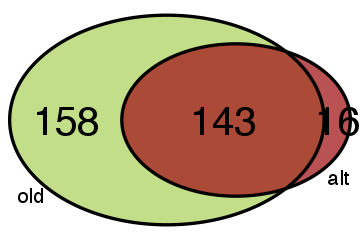

In [66]:
fRT_candidates <- list(alt = fRT.list.4fold, 
                        old = repTract.list.4fold)

fRT_Vdiag<-venn.diagram(fRT_candidates, NULL, fill=c("#a3181b", "#afd360"), alpha=c(0.75,0.75), cex = 2, cat.fontface= 6, cat.cex = 1, resolution = 100, )

fRT_combs <- unlist(lapply(1:length(fRT_candidates), function(j) combn(names(fRT_candidates), j, simplify = FALSE)), recursive = FALSE)
names(fRT_combs) <- sapply(fRT_combs, function(i) paste0(i, collapse = ","))
fRT_elements <- lapply(fRT_combs, function(i) Setdiff(fRT_candidates[i], fRT_candidates[setdiff(names(fRT_candidates), i)]))
options(repr.plot.width = 3, repr.plot.height =2)
# summary(fRT_elements)
grid.arrange(gTree(children=fRT_Vdiag))
# rm(fRT_candidates, fRT_Vdiag, fRT_combs)


##### Ovaries:

In [69]:
lrt.ovaries <- glmLRT(dgeList.ovaries_fit, contrast = ovaries_contrast)
lrt.ovaries.tTags <- topTags(lrt.ovaries, n = NULL)
lrt.ovaries.tTags.table <- lrt.ovaries.tTags$table

ovaries.list<-subset(lrt.ovaries.tTags.table, logFC > 1 & FDR<0.01)$GeneID
ovaries.list.4fold<-subset(lrt.ovaries.tTags.table, logFC > 2 & FDR<0.01)$GeneID
ovaries.list.10fold<-subset(lrt.ovaries.tTags.table, logFC > 3.32 & FDR<0.01)$GeneID

paste(length(ovaries.list), " genes show RT-biased expression at a >2-fold cutoff, ", length(ovaries.list.4fold), " at a >4-fold cutoff, and ", length(ovaries.list.10fold), " at a >10-fold cutoff." ,sep = "")

[1] "297 genes show RT-biased expression at a >2-fold cutoff, 297 at a >4-fold cutoff, and 215 at a >10-fold cutoff."

##### Head:

In [70]:
lrt.fHead <- glmLRT(dgeList.fHead_fit, contrast = head_contrast)
lrt.fHead.tTags <- topTags(lrt.fHead, n = NULL)
lrt.fHead.tTags.table <- lrt.fHead.tTags$table

fHead.list<-subset(lrt.fHead.tTags.table, logFC > 1 & FDR<0.01)$GeneID
fHead.list.4fold<-subset(lrt.fHead.tTags.table, logFC > 2 & FDR<0.01)$GeneID
fHead.list.10fold<-subset(lrt.fHead.tTags.table, logFC > 3.32 & FDR<0.01)$GeneID

paste(length(fHead.list), " genes show RT-biased expression at a >2-fold cutoff, ", length(fHead.list.4fold), " at a >4-fold cutoff, and ", length(fHead.list.10fold), " at a >10-fold cutoff." ,sep = "")

[1] "167 genes show RT-biased expression at a >2-fold cutoff, 167 at a >4-fold cutoff, and 164 at a >10-fold cutoff."

##### Carcass (this isn't terribly important, especially since one of the carcass replicates may have gotten contaminated with ovary material (see heatmap of replicates below). But we'll do it anyway ):

In [71]:
# lrt.v.carcass <- glmLRT(dgeList.v_fit, contrast = cont.v.carcass)
# lrt.v.carcass.tTags <- topTags(lrt.v.carcass, n = NULL)
# lrt.v.carcass.tTags.table <- lrt.v.carcass.tTags$table
# carcass.list<-subset(lrt.v.carcass.tTags.table, logFC.V_CR.vs.V_H > 1 & logFC.V_CR.vs.V_OV > 1 & logFC.V_CR.vs.V_RT > 1 & FDR<0.01)$GeneID
# paste(length(carcass.list), " show carcass-biased expression", sep = "")

We can generate tissue-biased factor tables to annotate heatmaps of the tissue-biased genes, and can also be used for GO analysis later:

In [72]:
RT_factors = as.data.frame(fRT.list)
RT_factors$V1 = "RT-biased"
rownames(RT_factors) = fRT.list
RT_factors = subset(RT_factors, select = "V1")

OV_factors = as.data.frame(ovaries.list)
OV_factors$V1 = "OV-biased"
rownames(OV_factors) = ovaries.list
OV_factors = subset(OV_factors, select = "V1")

H_factors = as.data.frame(fHead.list)
H_factors$V1 = "H-biased"
rownames(H_factors) = fHead.list
H_factors = subset(H_factors, select = "V1")

## Adding male-bised genes here:
# AG_factors = as.data.frame(as.character(AG_biased))
# AG_factors$V1 = "AG-biased"
# rownames(AG_factors) = as.character(AG_biased)
# AG_factors = subset(AG_factors, select = "V1")

# SFP_factors = as.data.frame(as.character(SFPs))
# SFP_factors$V1 = "SFP"
# rownames(SFP_factors) = as.character(SFPs)
# SFP_factors = subset(SFP_factors, select = "V1")

virgin.factor.labeling = rbind(RT_factors, 
                               OV_factors,
#                                AG_factors,
#                                SFP_factors,
                               H_factors 
                               )
colnames(virgin.factor.labeling) = c('tissue_bias')
virgin.factor_list = unique(virgin.factor.labeling[,1])

For a heatmap, we'll subset from the mean TPM matrix produced in the introduction:

In [73]:
meanTPM_v_bt2.fbgn = subset(tpmMatrix_bt2.fbgn, rownames(tpm_bt2.fbgn) %in% rownames(virgin.factor.labeling))
meanTPM_v_bt2.fbgn = subset(meanTPM_v_bt2.fbgn, select=grepl("Female_V", colnames(meanTPM_v_bt2.fbgn)))
colnames(meanTPM_v_bt2.fbgn) = gsub("Female_V_", "", colnames(meanTPM_v_bt2.fbgn))

Some more bells and whistles to generate the heatmap (for now with heatmap.3, fix this later and use the heatmap3 package):

In [74]:
data = meanTPM_v_bt2.fbgn
gene_factors = unique(virgin.factor.labeling[,1])
gene_factor_colors = rainbow(length(gene_factors))
names(gene_factor_colors) = gene_factors
data = log2(data+1)
data = as.matrix(data) # convert to matrix
data = t(scale(t(data), scale=F)) # center rows, mean substracted
heatmap_data = data
heatmap_data[heatmap_data < -2] = -2
heatmap_data[heatmap_data > 2] = 2

For a heatmap using "pheatmap", here's how to rotate column labels:

In [75]:
draw_colnames_45 <- function (coln, gaps, ...) {
    coord <- pheatmap:::find_coordinates(length(coln), gaps)
    x     <- coord$coord - 0.5 * coord$size
    res   <- grid::textGrob(
      coln, x = x, y = unit(1, "npc") - unit(3,"bigpts"),
      vjust = 0.75, hjust = 1, rot = 45, gp = grid::gpar(...)
    )
    return(res)
}
assignInNamespace(
  x = "draw_colnames",
  value = "draw_colnames_45",
  ns = asNamespace("pheatmap")
)

Set the colours for the side bar like so:

In [76]:
mat_colors <- list(tissue_bias = c("#c75f65", "#949b48", "#9475c5"))
names(mat_colors$tissue_bias) <- unique(virgin.factor.labeling$tissue_bias)

Can set the scale breaks like this:

In [77]:
# mat_breaks <- seq(min(heatmap_data), max(heatmap_data), length.out = 10)

Or this is better:

In [78]:
# quantile_breaks <- function(xs, n = 10) {
#   breaks <- quantile(xs, probs = seq(0, 1, length.out = n))
#   breaks[!duplicated(breaks)]
# }

# mat_breaks <- quantile_breaks(mat, n = 101)

Now plot it:

In [79]:
# To only include a subset of the samples for the heatmap
# heatmap_data = subset(heatmap_data, select = c("CR", "OV", "RT"))

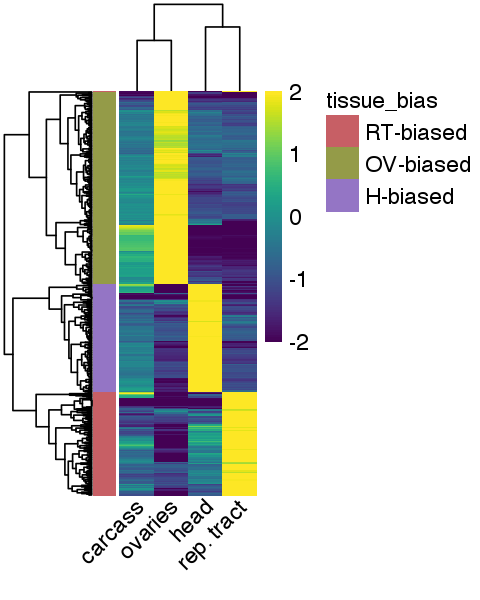

In [80]:
options(repr.plot.width = 4, repr.plot.height =5)

fig2A = pheatmap(
  mat               = heatmap_data,
  color             = viridis(100),
#   breaks            = mat_breaks,
  border_color      = NA,
  labels_col        = c("carcass", "head","ovaries", "rep. tract", "head"),
  show_colnames     = TRUE,
  show_rownames     = FALSE,
  annotation_row    = virgin.factor.labeling,
  annotation_colors = mat_colors,
  drop_levels       = TRUE,
  annotation_names_row = F,
#   main              = "Default Heatmap",
#   filename          = "Figures/tissue-biased_heatmap.png",
#   width             = 4, 
#   height            = 5,
  fontsize          = 13    
)

#### Gene Ontology

Process the gene length information and GO annotation files for GOseq:

In [81]:
GO_info_listed = apply(GOinfo_annotated, 1, function(x) unlist(strsplit(x,',')))
names(GO_info_listed) = rownames(GOinfo_annotated)
features_with_GO = rownames(GOinfo_annotated)
lengths_features_with_GO = a.gene_lengths[features_with_GO,]
get_GO_term_descr =  function(x) {
    d = 'none';
    go_info = GOTERM[[x]];
    if (length(go_info) >0) { d = paste(Ontology(go_info), Term(go_info), sep=' ');}
    return(d);
}

We'll process some of this and come up with the null expectation for GO terms, then plot the proportion of tissue-biased genes as a function of those biased in bins of 200:

Warning message in pcls(G):
"initial point very close to some inequality constraints"

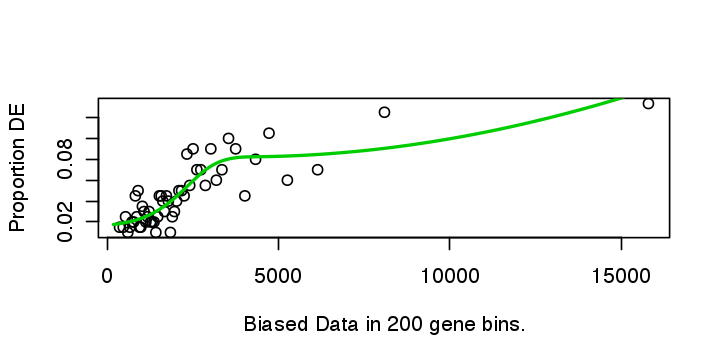

In [82]:
# build pwf based on ALL DE features
options(repr.plot.width = 6, repr.plot.height = 3)
cat_genes_vec = as.integer(features_with_GO %in% rownames(virgin.factor.labeling))
pwf=nullp(DEgenes = cat_genes_vec, bias.data=lengths_features_with_GO)
rownames(pwf) = names(GO_info_listed)

That looks fine. Now we'll process each tissue biased category of genes in a for-loop to identify enriched GO terms and their FDR values:

In [83]:
GO_enriched_list = list()

invisible(suppressWarnings(suppressMessages(
for (feature_cat in virgin.factor_list) {
    message('Processing category: ', feature_cat)
    cat_genes_vec = as.integer(features_with_GO %in% rownames(virgin.factor.labeling)[virgin.factor.labeling$tissue_bias == feature_cat])
    pwf$DEgenes = cat_genes_vec
    res = goseq(pwf,gene2cat=GO_info_listed)
    ## over-represented categories:
    pvals = res$over_represented_pvalue
    pvals[pvals > 1 -1e-10] = 1-1e-10
    q = qvalue(pvals)
    res$over_represented_FDR = q$qvalues
    go_enrich_factor = feature_cat
    enrich_result_table = res[res$over_represented_pvalue<=0.05,]
    descr = unlist(lapply(enrich_result_table$category, get_GO_term_descr))
    enrich_result_table$go_term = descr
    enrich_result_table$factor = go_enrich_factor
    GO_enriched_list[[feature_cat]] = enrich_result_table
}
)))

GO_enrichment_data = rbindlist(GO_enriched_list)

Output the significant GO terms to the Results folder:

In [77]:
write.table(subset(GO_enrichment_data, over_represented_FDR < 0.05), "Results/GO_analyses/GO_results-female_tissue-biased_genes_aBT2.txt", quote = F, sep = "\t", row.names = F)

We can also run a KEGG pathway enrichment:

In [88]:
RT_genes_altIDs = subset(dv1.06_features, FBgn_ID %in% fRT.list)$gene_name
RT_genes_altIDs = gsub("^", "Dvir_", RT_genes_altIDs)
RT_kegg <- enrichKEGG(gene = RT_genes_altIDs, organism = 'dvi')
subset(RT_kegg@result, qvalue < 0.05)
write.table(RT_kegg@result, "Results/KEGG/RT-biased_kegg_table.txt", quote = F, sep = "\t", row.names = F)

ID       Description                             GeneRatio BgRatio
dvi04080 dvi04080 Neuroactive ligand-receptor interaction 5/21      73/3345
         pvalue       p.adjust    qvalue     
dvi04080 6.684075e-05 0.001403656 0.001336815
         geneID                                                           Count
dvi04080 Dvir_GJ12183/Dvir_GJ22325/Dvir_GJ21573/Dvir_GJ21575/Dvir_GJ14885 5

Let's output a plot of these genes:

In [100]:
RT_biased_KEGG_neuroactive_ligand_recetor_genes_boxPlots = suppressMessages(lapply(gsub("Dvir_", "", unlist(strsplit(subset(RT_kegg@result, qvalue < 0.05)$geneID, split="/"))), geneBoxPlot, object = tpmTable_bt2.fbgn))
ggsave("Results/Plots/RT-biased_KEGG_neuroactive_ligand_recetor_genes.pdf", marrangeGrob(grobs = RT_biased_KEGG_neuroactive_ligand_recetor_genes_boxPlots, nrow = 3, ncol =1))

Saving 7 x 7 in image


Let's look at some of the enriched terms in the reproductive tract. First, Molecular function:

In [89]:
subset(GO_enrichment_data, ontology == "MF" & over_represented_FDR < 0.05 & factor == "RT-biased")[,c("category","term","numDEInCat")]

category   term                               numDEInCat
1 GO:0004252 serine-type endopeptidase activity 11        
2 GO:0008236 serine-type peptidase activity     11        
3 GO:0017171 serine hydrolase activity          11

Some interesting terms here include "transporter activity", "serine-type endopeptidase activity", and "structural constituent of cuticle". We'll output individual gene expression plots for each of those categories:

In [90]:
RT_biased_endopeptidase_genes = extract_GO_genes(go_term = "GO:0004252", gene_set = fRT.list)
RT_biased_endopeptidase_genes_boxPlots = suppressMessages(lapply(RT_biased_endopeptidase_genes, geneBoxPlot, object = tpmTable_bt2.fbgn))
ggsave("Results/Plots/RT-biased_endopeptidase_proteins.pdf", marrangeGrob(grobs = RT_biased_endopeptidase_genes_boxPlots, nrow = 3, ncol =1))

Saving 7 x 7 in image


Now let's look at the genes in the Biological Process categories:

In [91]:
subset(GO_enrichment_data, ontology == "BP" & over_represented_FDR < 0.05 & factor == "RT-biased")[,c("category","term","numDEInCat")]

category   term                               numDEInCat
1 GO:0009888 tissue development                 18        
2 GO:0014706 striated muscle tissue development  7        
3 GO:0060537 muscle tissue development           7        
4 GO:0048513 animal organ development           25

Potentially lots of overlap between genes in this ontology class and the MF ontology class, but the "mating behaviour" category is interesting. We'll make a plot object for those:.

In [94]:
RT_biased_development_genes = extract_GO_genes(go_term = "GO:0048513", gene_set = fRT.list)
RT_biased_development_genes_boxPlots = suppressMessages(lapply(RT_biased_development_genes, geneBoxPlot, object = tpmTable_bt2.fbgn))
ggsave("Results/Plots/RT-biased_development_proteins.pdf", marrangeGrob(grobs = RT_biased_development_genes_boxPlots, nrow = 3, ncol =1))

Saving 7 x 7 in image


... and the Cellular Component category

In [101]:
subset(GO_enrichment_data, ontology == "CC" & over_represented_FDR < 0.05 & factor == "RT-biased")[,c("category","term","numDEInCat")]

category   term                   numDEInCat
1 GO:0005615 extracellular space    18        
2 GO:0044449 contractile fiber part  9        
3 GO:0005576 extracellular region   20

We should also output individual gene plots for those ≥10-fold biased RT genes

In [102]:
RT_biased_10fold_genes_boxPlots = suppressMessages(lapply(fRT.list.10fold, geneBoxPlot, object = tpmTable_bt2.fbgn))
ggsave("Results/Plots/RT_biased_10fold_genes.pdf", marrangeGrob(grobs = RT_biased_10fold_genes_boxPlots, nrow = 3, ncol =1))

Saving 7 x 7 in image


Let's plot the _Ka/Ks_ values of RT-biased genes along chromosomes. First we'll make a table containing all the relevant data:

In [103]:
AN_KaKs_data = (filter(KaKs.data, COMPARISON == "D.amr_vs_D.nov" & Ks > 0.0003))
AN_KaKs_data = merge(AN_KaKs_data, FBgn_to_FBtr, by.x = "FBtr_ID", by.y = "FBtr_ID", all.x = TRUE)
AN_KaKs_data = merge(AN_KaKs_data, dv1.06_features, by.x = "FBgn_ID", by.y = "FBgn_ID", all.x = T)
AN_KaKs_data = merge(AN_KaKs_data, annot.sum, by.x = "FBgn_ID", by.y = "FBgn_ID", all.x = T)
AN_KaKs_data$status = ifelse(AN_KaKs_data$FBgn_ID %in% fRT.list, "RT-biased", ifelse(AN_KaKs_data$FBgn_ID %in% AG_biased, "AG-biased", ifelse(AN_KaKs_data$FBgn_ID %in% SFPs, "SFPs", "all")))
AN_KaKs_data$KaKs = AN_KaKs_data$`Ka/Ks`

Run a statistical test:

In [104]:
KaKs.test <- as.data.frame(compare_means(
 KaKs ~ status, data = AN_KaKs_data,
 method = "wilcox.test"
))
# (KaKs.test <- filter(KaKs.test, group1 == "RT-biased"))
KaKs.test

.y.  group1    group2    p            p.adj   p.format p.signif method  
1 KaKs all       RT-biased 9.033175e-01 9.0e-01 0.9033   ns       Wilcoxon
2 KaKs all       SFPs      2.710656e-14 1.6e-13 2.7e-14  ****     Wilcoxon
3 KaKs all       AG-biased 2.862440e-07 1.1e-06 2.9e-07  ****     Wilcoxon
4 KaKs RT-biased SFPs      2.860673e-14 1.6e-13 2.9e-14  ****     Wilcoxon
5 KaKs RT-biased AG-biased 2.932731e-06 8.8e-06 2.9e-06  ****     Wilcoxon
6 KaKs SFPs      AG-biased 9.904077e-03 2.0e-02 0.0099   **       Wilcoxon

Now make a plot:

In [105]:
AN_KaKs_data$status = gsub("all", "all genes", AN_KaKs_data$status)
AN_KaKs_data$status = gsub("RT-biased", "rep. tract", AN_KaKs_data$status)
AN_KaKs_data$status = gsub("AG-biased", "acc. glands", AN_KaKs_data$status)

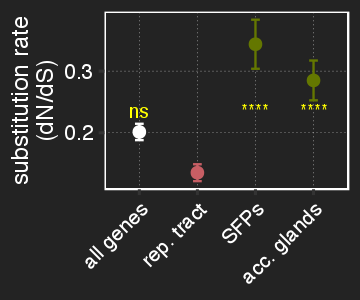

In [106]:
KaKs_comparisons <- list( c("rep. tract", "all genes"), c("rep. tract", "SFPs"), c("rep. tract", "acc. glands") )

KaKs_y_title <- expression(paste(italic("Ka/Ks")))

options(repr.plot.width = 3, repr.plot.height = 2.5)
# pdf("Figures/mean_KaKs.pdf", width = 3, height = 2.5)
(fig2D = ggerrorplot(AN_KaKs_data, 
            x = "status", 
            y = "Ka/Ks", 
            color = "status",
            add = "mean", 
#             desc_stat = "mean_ci",
            error.plot = "errorbar",
            ggtheme = theme_bw(),
            palette = c("white", "#C75E64", "#647700", "#647700")
           ) +
         theme_monokai_full() +
        theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 12), 
              legend.position = "none", 
              axis.title.x = element_blank(), 
              axis.text.y = element_text(size = 12)) +
#               stat_pvalue_manual(KaKs.test, label = "p.adj") +
        stat_compare_means(ref.group = "rep. tract", 
                           method = "wilcox.test", 
                           label.y = 0.235, 
                           aes(label = ..p.signif..), color = "yellow"
                          )  +
#         scale_y_continuous(values = c(0.15,0.42)) +
        labs(y = "substitution rate\n(dN/dS)"))
        
# dev.off()

Let's plot omega across the genome:

In [111]:
colnames(omegaLRT)

[1] "FBgn_ID"                        "FBtr_ID.x"                     
 [3] "Damr_ML95_H0"                   "Damr_ML95_H1"                  
 [5] "Dlum_LM8_H0"                    "Dlum_LM8_H1"                   
 [7] "Dmon_Oul_H0"                    "Dmon_Oul_H1"                   
 [9] "Dnov_4_H0"                      "Dnov_4_H1"                     
[11] "Dvir_S9_H0"                     "Dvir_S9_H1"                    
[13] "omega"                          "Damr_LRT"                      
[15] "Damr_pValue"                    "Damr_FDR"                      
[17] "Dlum_LRT"                       "Dlum_pValue"                   
[19] "Dlum_FDR"                       "Dnov_LRT"                      
[21] "Dnov_pValue"                    "Dnov_FDR"                      
[23] "Dvir_LRT"                       "Dvir_pValue"                   
[25] "Dvir_FDR"                       "Dmon_LRT"                      
[27] "Dmon_pValue"                    "Dmon_FDR"                      
[29] "status.x"                       "gene_name.x.x"                 
[31] "chromosome.x"                   "min.x"                         
[33] "max.x"                          "orientation.x"                 
[35] "gene_name.y.x"                  "SwissProt_BlastX_Description.x"
[37] "FBtr_ID.y"                      "SEQ1"                          
[39] "SEQ2"                           "Ka"                            
[41] "Ks"                             "Ka/Ks"                         
[43] "PROT_PERCENTID"                 "CDNA_PERCENTID"                
[45] "COMPARISON"                     "gene_name.x.y"                 
[47] "chromosome.y"                   "min.y"                         
[49] "max.y"                          "orientation.y"                 
[51] "gene_name.y.y"                  "SwissProt_BlastX_Description.y"
[53] "status.y"                       "KaKs"                          
[55] "sig"

Warning message:
"Removed 1 rows containing missing values (geom_point)."

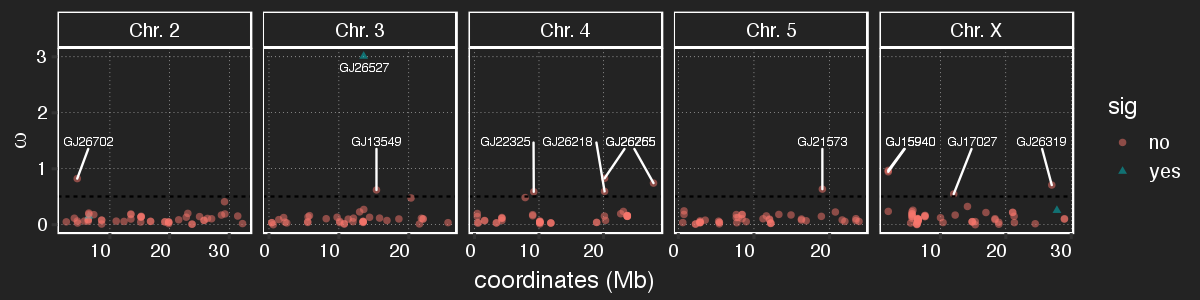

In [135]:
omegaLRT = merge(paml2.data, FBgn_to_FBtr, by.x = "FBtr_ID", by.y = "FBtr_ID", all.x = TRUE)
omegaLRT = merge(omegaLRT, dv1.06_features, by.x = "FBgn_ID", by.y = "FBgn_ID", all.x = T)
omegaLRT = merge(omegaLRT, annot.sum, by.x = "FBgn_ID", by.y = "FBgn_ID", all.x = T)
omegaLRT = merge(omegaLRT, AN_KaKs_data, by.x = "FBgn_ID", by.y = "FBgn_ID", all.x = T)

options(repr.plot.width = 10, repr.plot.height = 2.5)
omega_y_title <- expression(paste(italic(omega)))
omegaLRT$chromosome.x = gsub("Chr_", "Chr. ", omegaLRT$chromosome.x)

omegaLRT$sig = ifelse(omegaLRT$Dvir_FDR < 0.01, "yes", "no")
omegaLRT = unique(subset(omegaLRT, select = c("chromosome.x", "FBgn_ID", "sig", "min.x", "omega", "Dnov_FDR", "gene_name.x.x")))
# pdf("Figures/KaKs_RT-biased_chromosome.xs.pdf", width = 10, height = 2.5)
# pdf("~/Dropbox/Faculty_Job_Applications/University.of.NewMexico_15Nov2018/Job_Talk/Images/KaKs_RT-biased_chromosome.xs.pdf", width = 10, height = 2.5)
(fig2E = ggplot(filter(omegaLRT, grepl("Chr", chromosome.x) & chromosome.x != "Chr. 6" & FBgn_ID %in% fRT.list), aes(min.x, omega, shape = sig, colour = sig)) + 
    geom_point(alpha = 0.5) + 
#     geom_point(data =filter(omegaLRT, grepl("Chr", chromosome.x) & chromosome.x != "Chr. 6" & FBgn_ID %in% fRT.list & sig == "yes"), colour = "#e43eba") +
    facet_grid(.~chromosome.x, scales = "free_x") + 
    geom_hline(yintercept = 0.5, linetype = "dashed") +
    scale_x_continuous(breaks=seq(from=0, to=30e6, by = 10e6), labels=as.character(seq(0,30,10))) +
    geom_text_repel(data = filter(omegaLRT, grepl("Chr", chromosome.x) & chromosome.x != "Chr. 6" & FBgn_ID %in% fRT.list & omega > 0.5), aes(label = gene_name.x.x), size = 2.5, fontface = "bold.italic", force = 30, colour = "white", ylim  = c(1.3, NA)) +
    labs(x = "coordinates (Mb)", y = omega_y_title) +
    guides(size=guide_legend(title="-log10(FDR)\n(branch-site LRT)"))+
    theme(strip.background =  element_rect(colour = "white", fill = "white")) +
    theme_monokai_full()+
    theme(axis.text.x = element_text(angle = 0, vjust = 1)))
# dev.off()

Now let's plot the percent identity for cDNA and protein of these gene categories. First add some conditional columns:

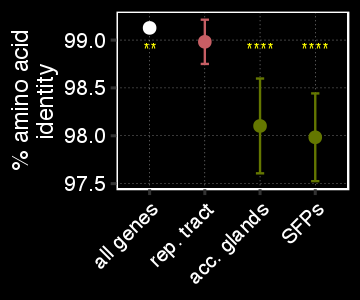

In [136]:
KaKs.data$status = ifelse(KaKs.data$FBtr_ID %in% filter(FBgn_to_FBtr, FBgn_ID %in% fRT.list)$FBtr_ID, "RT-biased", ifelse(KaKs.data$FBtr_ID %in% filter(FBgn_to_FBtr, FBgn_ID %in% AG_biased)$FBtr_ID, "AG-biased", ifelse(KaKs.data$FBtr_ID %in% filter(FBgn_to_FBtr, FBgn_ID %in% TS_biased)$FBtr_ID, "testes-biased", ifelse(KaKs.data$FBtr_ID %in% filter(FBgn_to_FBtr, FBgn_ID %in% EB_biased)$FBtr_ID, "EB-biased", ifelse(KaKs.data$FBtr_ID %in% filter(FBgn_to_FBtr, FBgn_ID %in% ovaries.list.4fold)$FBtr_ID, "OV-biased", ifelse(KaKs.data$FBtr_ID %in% filter(FBgn_to_FBtr, FBgn_ID %in% SFPs)$FBtr_ID, "SFPs", "all"))))))

KaKs.data$status = gsub("all", "all genes", KaKs.data$status)
KaKs.data$status = gsub("RT-biased", "rep. tract", KaKs.data$status)
KaKs.data$status = gsub("AG-biased", "acc. glands", KaKs.data$status)
KaKs.data$status = factor(KaKs.data$status, levels = c("all genes", "rep. tract", "acc. glands", "SFPs"))

options(repr.plot.width = 3, repr.plot.height = 2.5)

# pdf("Figures/percent_identity.pdf", width = 3, height = 2.5)
# pdf("~/Dropbox/Faculty_Job_Applications/University.of.NewMexico_15Nov2018/Job_Talk/Images/percent_identity.pdf", width = 3, height = 2.5)
(fig2C = ggerrorplot(filter(KaKs.data, COMPARISON == "D.amr_vs_D.nov" & (status == "all genes" | status == "acc. glands" | status == "rep. tract" | status == "SFPs")), 
            x = "status", 
            y = "PROT_PERCENTID", 
            color = "status",
            add = "mean", 
            error.plot = "errorbar",
            desc_stat = "mean_ci",
            ggtheme = theme_bw(),
            palette = c("white", "#C75E64", "#647700", "#647700")
           ) +
  theme_black_full() +
        theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 12), 
              legend.position = "none", 
              axis.title.x = element_blank(), 
              axis.text.y = element_text(size = 12)) +
        
#               stat_pvalue_manual(KaKs.test, label = "p.adj") +
        stat_compare_means(ref.group = "rep. tract", 
                           method = "wilcox.test", 
                           label.y = 98.9, 
                           aes(label = ..p.signif..), color = "yellow"
                          )  +
#         scale_y_continuous(values = c(0.15,0.42)) +
        labs(y = "% amino acid\nidentity"))
        
# dev.off()

Finally, let's look at the chromosomal distribution of these gene categories:

In [137]:
TotalGeneNumber = as.data.frame(table(factor(subset(dv1.06_features, grepl("Chr", chromosome))$chromosome)))
colnames(TotalGeneNumber) = c("chromosome", "All genes")
total_genes = nrow(dv1.06_features)
TotalGeneNumber$proportion = (TotalGeneNumber$`All genes`/total_genes)

Output tissue-biased data: (note to self: THIS IS UGLY!!! Figure out a way to make this more concise).

In [145]:
## AG_biased and SFPs
genomeNumber.AG_biased = length(AG_biased) + length(SFPs)
chromNumber.AG_biased=as.data.frame(table(factor(subset(dv1.06_features, (FBgn_ID %in% AG_biased | FBgn_ID %in% SFPs) & grepl("Chr", chromosome))$chromosome)))
colnames(chromNumber.AG_biased) = c("chromosome", "Observed_biased_genes")
chromNumber.AG_biased$sex = "male"
chromNumber.AG_biased = merge(TotalGeneNumber, chromNumber.AG_biased)
chromNumber.AG_biased$`Expected genes` = genomeNumber.AG_biased*chromNumber.AG_biased$proportion
chromNumber.AG_biased$`obs.exp` = chromNumber.AG_biased$Observed_biased_genes/chromNumber.AG_biased$`Expected genes`
chromNumber.AG_biased$`Gene category` = "AG_biased"

## repTract.list.4fold
genomeNumber.repTract = length(fRT.list)
chromNumber.repTract=as.data.frame(table(factor(subset(dv1.06_features, FBgn_ID %in% fRT.list & grepl("Chr", chromosome))$chromosome)))
colnames(chromNumber.repTract) = c("chromosome", "Observed_biased_genes")
chromNumber.repTract$sex = "female"
chromNumber.repTract = merge(TotalGeneNumber, chromNumber.repTract)
chromNumber.repTract$`Expected genes` = genomeNumber.repTract*chromNumber.repTract$proportion
chromNumber.repTract$`obs.exp` = chromNumber.repTract$Observed_biased_genes/chromNumber.repTract$`Expected genes`
chromNumber.repTract$`Gene category` = "RT_biased"

## ovaries.list
genomeNumber.ovaries = length(ovaries.list)
chromNumber.ovaries=as.data.frame(table(factor(subset(dv1.06_features, FBgn_ID %in% ovaries.list & grepl("Chr", chromosome))$chromosome)))
colnames(chromNumber.ovaries) = c("chromosome", "Observed_biased_genes")
chromNumber.ovaries$sex = "female"
chromNumber.ovaries = merge(TotalGeneNumber, chromNumber.ovaries)
chromNumber.ovaries$`Expected genes` = genomeNumber.ovaries*chromNumber.ovaries$proportion
chromNumber.ovaries$`obs.exp` = chromNumber.ovaries$Observed_biased_genes/chromNumber.ovaries$`Expected genes`
chromNumber.ovaries$`Gene category` = "OV_biased"

Combine the elements above and perform a Chi-square test:

In [146]:
tissue_biased.numbers = rbind(chromNumber.AG_biased, chromNumber.repTract, chromNumber.ovaries)
tissue_biased.numbers$`Gene category` = factor(tissue_biased.numbers$`Gene category`, levels = c("AG_biased", "OV_biased","RT_biased"))

tissue_biased.numbers$Chr = gsub("Chr_", "", tissue_biased.numbers$chromosome)
tissue_biased.numbers$Chr = factor(tissue_biased.numbers$Chr, levels = c("X", "2","3", "4", "5"))

tissue_biased.numbers$ChiSq = ((tissue_biased.numbers$Observed_biased_genes-tissue_biased.numbers$`Expected genes`)^2)/tissue_biased.numbers$`Expected genes`

tissue_biased.numbers$pval = 1-(pchisq(tissue_biased.numbers$ChiSq, df = 1))
tissue_biased.numbers$FDR = tissue_biased.numbers$pval*nrow(tissue_biased.numbers)

tissue_biased.numbers$sigLabel = NULL
tissue_biased.numbers$sigLabel = ifelse(tissue_biased.numbers$pval < 0.05 & tissue_biased.numbers$pval > 0.01, "*", ifelse(tissue_biased.numbers$pval < 0.01 & tissue_biased.numbers$pval > 0.001, "**", ifelse(tissue_biased.numbers$pval < 0.001, "***", "")))

Now plot it:

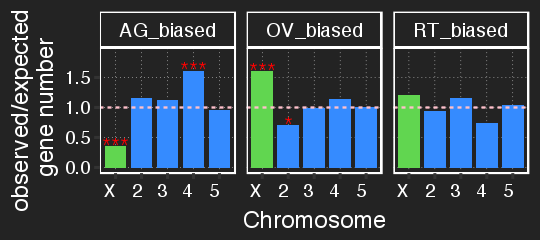

In [147]:
options(repr.plot.width = 4.5, repr.plot.height = 2)
# pdf("Figures/chromosome_distribution.pdf", width = 4, height = 3)
(fig2B = ggplot(filter(tissue_biased.numbers, chromosome != "Chr_6"), aes(Chr, obs.exp, fill = Chr)) +
    facet_wrap(~`Gene category`) +
    geom_bar(position=position_dodge(), stat="identity", width = 0.8) +
    geom_hline(yintercept = 1, linetype = "dashed", colour = "pink") +
    scale_fill_manual(values = c("#61d650", "#358bff","#358bff", "#358bff", "#358bff")) +
    labs(x = "Chromosome", y = "observed/expected\n gene number") +
    geom_text(aes(label = sigLabel), size = 5, colour = "red", position=position_dodge(width = 0.8)) +
    theme_monokai_full() +
    theme(legend.position = "none", axis.text.x = element_text(angle = 0, vjust = 1)) +
#     theme(legend.position = "none", strip.background = element_rect(fill = "white")) +
    scale_y_continuous(limits=c(0,1.9)))
# dev.off()

Let's try to combine all of these into one figure:

In [148]:
# fig2bcd = plot_grid(fig2B, fig2C, fig2D, labels = c("B", "C", "D"), scale = c(0.9, 0.9, 0.9), ncol = 3)
# options(repr.plot.width = 10, repr.plot.height = 6)
# (fig2bcde = plot_grid(fig2bcd, fig2E, labels = c("", "E"), scale = c(1, 0.9), ncol = 1))
# (fig2abcde = plot_grid(grid.arrange(grobs = list(fig2A[[4]])), fig2bcde, labels = c("A", ""), scale = c(0.9, 1), ncol = 2, rel_widths = 0.3, 1))

## Reproductive tract post-mating contrasts:

Create RT-specific count matrix 

In [149]:
counts_bt2.fbgn.RT = subset(counts_bt2.fbgn, select=grepl("RT", colnames(counts_bt2.fbgn)))

#######
## use this subset command if we want to remove the ovary-biased genes
# counts_bt2.fbgn.RT = subset(subset(counts_bt2.fbgn, rownames(counts_bt2.fbgn) %!in% ovaries.list.4fold), select=grepl("RT", colnames(counts_bt2.fbgn)))
#######

colnames(counts_bt2.fbgn.RT) = gsub("Female_", "", colnames(counts_bt2.fbgn.RT))
# counts_bt2.fbgn.RT = subset(counts_bt2.fbgn.RT, select=RT_GoodReps)

Now let's filter low expression genes within a minimum cpm of 5:

In [150]:
cpm_bt2.fbgn.RT <- cpm(counts_bt2.fbgn.RT)
thresh_RT.bt2.fbgn <- cpm_bt2.fbgn.RT > 5

countsKeep_RT.bt2.fbgn <- rowSums(thresh_RT.bt2.fbgn) >= 3
countsFiltered_bt2.fbgn.RT <- counts_bt2.fbgn.RT[countsKeep_RT.bt2.fbgn,]
## Check how many genes remain in the matrix.
dim(countsFiltered_bt2.fbgn.RT)

## Clean-up
rm(cpm_bt2.fbgn.RT, countsKeep_RT.bt2.fbgn, thresh_RT.bt2.fbgn)

[1] 7528   21

We'll also subset the samplesInfo object to only include the RT samples:

In [151]:
sampleInfo.pm = subset(sampleInfo, Tissue == "repTract")
# remove rogue replicates:
# sampleInfo.pm = subset(sampleInfo.pm, Replicate != "Female_H3_RT_1" & Replicate != "Female_H6_RT_1")
sampleInfo.pm$SampleName = gsub("Female_", "", sampleInfo.pm$SampleName)
sampleInfo.pm$Replicate = gsub("Female_", "", sampleInfo.pm$Replicate)

### Comparing con- and heterospeicific postmating time points to each other and to the virgin RT sample:

Here we can set up new grouping and comparison matrix with all the postmating time-point samples by combining the "Status" and "time" factors. This design matrix will test differences between each postmating time-point and the virgin sample:

In [152]:
## Will need to relevel the Status grouping to make virgin control
Status.time <- factor(paste(sampleInfo.pm$Status, sampleInfo.pm$Time, sep="."))
sampleInfo.pmv <- cbind(sampleInfo.pm, Group=Status.time)
sampleInfo.pmv$Group <- relevel(sampleInfo.pmv$Group, ref = "virgin.virgin")

groups.pmv <- factor(sampleInfo.pmv$Group)
design.pmv <- model.matrix(~groups.pmv)
colnames(design.pmv) <- levels(groups.pmv)
rownames(design.pmv) <- sampleInfo.pmv$Replicate

Next we need to set a different matrix where we test for differences between conspecific and heterospecific treatments of each time point:

In [153]:
groups.pmb <- factor(sampleInfo.pm$SampleName)
design.pmb <- model.matrix(~ 0 + groups.pmb)
colnames(design.pmb) <- levels(groups.pmb)
rownames(design.pmb) <- sampleInfo.pm$Replicate

Create edgeR DE object and run glmFit

In [154]:
dgeList.pmv <- DGEList(counts = countsFiltered_bt2.fbgn.RT, group = groups.pmv)
dgeList.pmv <- calcNormFactors(dgeList.pmv)
dgeList.pmv <- estimateCommonDisp(dgeList.pmv)
dgeList.pmv <- estimateTagwiseDisp(dgeList.pmv)
dgeList.pmv_fit <- glmFit(dgeList.pmv, design.pmv)

In [155]:
dgeList.pmb <- DGEList(counts = countsFiltered_bt2.fbgn.RT, group = groups.pmb)
dgeList.pmb <- calcNormFactors(dgeList.pmb)
dgeList.pmb <- estimateCommonDisp(dgeList.pmb)
dgeList.pmb <- estimateTagwiseDisp(dgeList.pmb)
dgeList.pmb_fit <- glmFit(dgeList.pmb, design.pmb)

Let's add the annotation information to this fit object:

In [156]:
# Extract annotation for genes in the fit object
ann.pmv = subset(Annots, FBgn_ID %in% rownames(dgeList.pmv_fit))
ann.pmv = subset(ann.pmv, select = c("FBgn_ID", "gene_name", "SwissProt_BlastX_Description"))
# convert factors to characters
ann.pmv = data.frame(lapply(ann.pmv, as.character), stringsAsFactors=FALSE)
# align the fit object's rownames with gene ID's
ann.pmv = ann.pmv[match(rownames(dgeList.pmv_fit), ann.pmv$FBgn_ID),]
# convert factors to characters, again
ann.pmv <- data.frame(lapply(ann.pmv, as.character), stringsAsFactors=FALSE)
# Rename "FBgn_ID" as "GeneID"
colnames(ann.pmv) = c ("GeneID", "gene_name", "SwissProt_BlastX_Description")
# Check that the fit rownames match the annotation file's gene ID's
table(ann.pmv$GeneID==rownames(dgeList.pmv_fit))
# Add the annotations to the fit object in the "genes" slot
dgeList.pmv_fit$genes = ann.pmv


TRUE 
7528 

In [157]:
# Extract annotation for genes in the fit object
ann.pmb = subset(Annots, FBgn_ID %in% rownames(dgeList.pmb_fit))
ann.pmb = subset(ann.pmb, select = c("FBgn_ID", "gene_name", "SwissProt_BlastX_Description"))
# convert factors to characters
ann.pmb = data.frame(lapply(ann.pmb, as.character), stringsAsFactors=FALSE)
# align the fit object's rownames with gene ID's
ann.pmb = ann.pmb[match(rownames(dgeList.pmb_fit), ann.pmb$FBgn_ID),]
# convert factors to characters, again
ann.pmb <- data.frame(lapply(ann.pmb, as.character), stringsAsFactors=FALSE)
# Rename "FBgn_ID" as "GeneID"
colnames(ann.pmb) = c ("GeneID", "gene_name", "SwissProt_BlastX_Description")
# Check that the fit rownames match the annotation file's gene ID's
table(ann.pmb$GeneID==rownames(dgeList.pmb_fit))
# Add the annotations to the fit object in the "genes" slot
dgeList.pmb_fit$genes = ann.pmb


TRUE 
7528 

Also, check the tagwise dispersion summary:

In [158]:
summary(dgeList.pmb$tagwise.dispersion)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.005103 0.008585 0.011395 0.022628 0.017339 1.236944 

Again, quick look at the BCV, mean-variance trend, qq-plot and normalized count distributions.

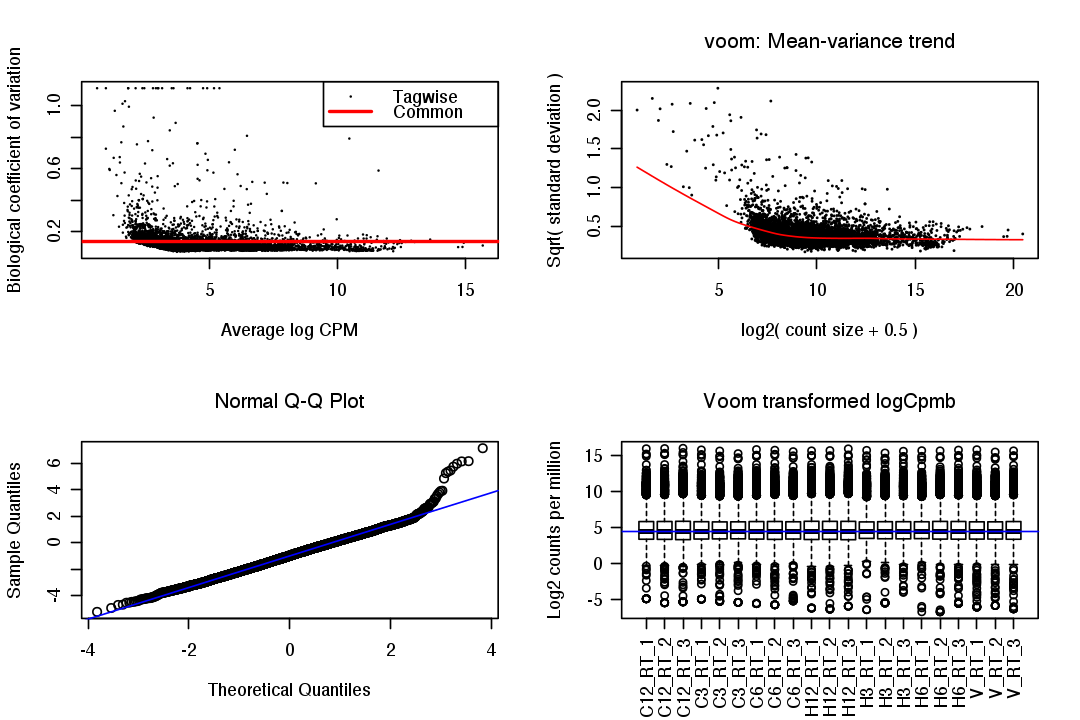

In [159]:
options(repr.plot.width = 9, repr.plot.height = 6)
# pdf("Figures/DE_QC_plots.pdf", width = 9, height = 6)
par(mfrow=c(2,2))
# Biological coefficient of variation
plotBCV(dgeList.pmb)
# mean-variance trend
pmb.voom = voom(dgeList.pmb, design.pmb, plot=TRUE)
# QQ-plot
g.pmb <- gof(dgeList.pmb_fit)
z.pmb <- zscoreGamma(g.pmb$gof.statistics,shape=g.pmb$df/2,scale=2)
qqnorm(z.pmb); qqline(z.pmb, col = 4,lwd=1,lty=1)
# log2 transformed and normalize boxplot of counts across samples
boxplot(pmb.voom$E, xlab="", ylab="Log2 counts per million",las=2,main="Voom transformed logCpmb")
abline(h=median(pmb.voom$E),col="blue")
# dev.off()

Generate a custom MDS figure with ggplot2:

In [161]:
mdsObj <- plotMDS(dgeList.pmv, plot = F)$cmdscale.out
mdsObj <- as.data.frame(as.matrix(mdsObj))
mdsObj$replicate <- rownames(mdsObj)
colnames(mdsObj) = c("dim1", "dim2", "replicate")
mdsObj = merge(mdsObj, sampleInfo.pmv, by.x = "replicate", by.y = "Replicate")
mdsObj$Time = factor(mdsObj$Time, levels = c ("virgin", "3hpm", "6hpm", "12hpm"))
mdsObj$Status = factor(mdsObj$Status, levels = c ("virgin", "conspecific", "heterospecific"))

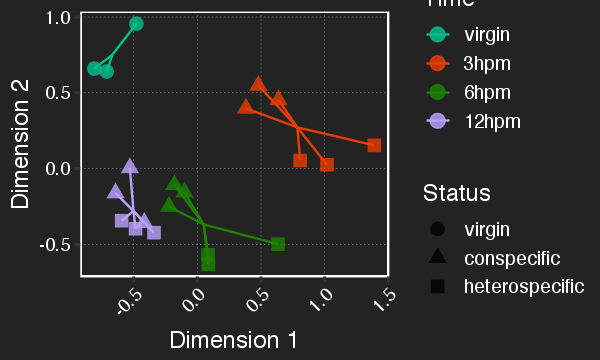

In [164]:
options(repr.plot.width = 5, repr.plot.height = 3)

# pdf("Figures/postmating.MDS.plot.pdf", width = 5, height = 3)
ggscatter(mdsObj, 
              x = "dim1", 
              y = "dim2",
              color = "Time",
              shape = "Status",
              size = 3.5,
              alpha = 0.8, 
#               ellipse = T, 
#               mean.point = T,
              star.plot = TRUE,
              ggtheme = theme_bw(),
              repel = "Time",) + 
#                 stat_conf_ellipse(aes(color = Time, fill = Time), alpha = 0.1, geom = "polygon") + 
                theme(axis.text = element_text(size = 10), legend.title = element_blank(), axis.title = element_text(size = 12), legend.text = element_text(size = 12)) +
                theme_monokai_full() +
                scale_colour_manual(values = c("#00c28f","#e93c00","#1c8200","#bda2ff")) +
                scale_fill_manual(values = c("#00c28f","#e93c00","#1c8200","#bda2ff")) +
                labs ( x = "Dimension 1", y = "Dimension 2")
# dev.off()

Let's look at samples correlation. First make a column labeling object for samples/replicates:

In [165]:
sampleColLabeling = subset(sampleInfo.pm, select = c("SampleName", "Replicate"))
sampleColLabeling = filter(sampleColLabeling, grepl("RT", SampleName))
rownames(sampleColLabeling) = sampleColLabeling$Replicate
sampleColLabeling = subset(sampleColLabeling, select = SampleName)
colnames(sampleColLabeling) = "Sample"
sampleColLabeling$Sample = factor(sampleColLabeling$Sample, levels = c("V_RT", "C3_RT", "C6_RT", "C12_RT", "H3_RT", "H6_RT", "H12_RT"))

Now plot it:

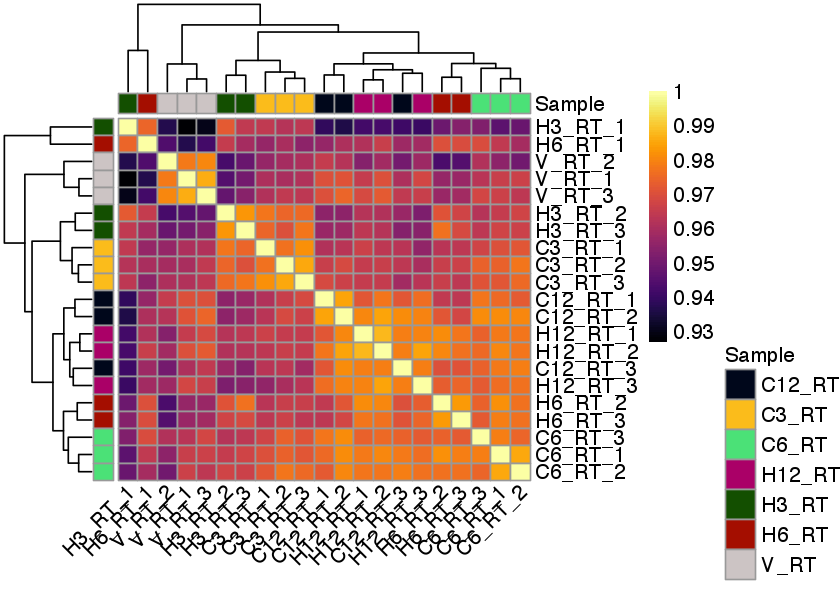

In [166]:
## Plot sample correlation
data = log2(countsFiltered_bt2.fbgn.RT+1)
data = as.matrix(data)
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')

cor_colors <- list(Sample = c("#00071b","#fbbc1b","#4be177","#aa0067","#134f00","#a40e00","#ccc4c4"))
names(cor_colors$Sample) <- unique(sampleColLabeling$Sample)

options(repr.plot.width = 7, repr.plot.height = 5)
pheatmap(
  mat               = sample_cor,
  color             = inferno(100),
#   border_color      = NA,
  annotation_col    = sampleColLabeling,
  annotation_row    = sampleColLabeling,
  drop_levels       = TRUE,
  annotation_colors = cor_colors,
  show_colnames     = TRUE,
  show_rownames     = TRUE,
  annotation_names_row = F,
#   filename          = "Figures/repTract_sample_correlations.pdf",
#   width             = 7, 
#   height            = 5,
  fontsize          = 12    
)

The H3_RT_1 and H6_RT_1 samples are grouping together and away from their relatives because it appears those two samples have had an egg stuck in one of the ~100 reproductive tracts. This is evident when looking at gene plots where the rogues increase in those replicates correlates well with high expression in the ovaries. I'll ignore this for now, but will revisit if it's causing erroneous DE calls in those samples.

To perform pairwise differential expression tests between postmating samples, we need to set up a series of contrasts for the DE test:

In [167]:
time.3hpm <- makeContrasts(C3.vs.H3=H3_RT-C3_RT, levels=design.pmb)
time.6hpm <- makeContrasts(C6.vs.H6=H6_RT-C6_RT, levels=design.pmb)
time.12hpm <- makeContrasts(C12.vs.H12=H12_RT-C12_RT, levels=design.pmb)

Now we can fit the negative binomial log-linear model to conduct gene-wise statistical tests. For each contrast, we will extract the genes with the relevant DE stats.

In [168]:
lrt.pmb.3h <- glmLRT(dgeList.pmb_fit, contrast = time.3hpm)
lrt.pmb.3h.tTags <- topTags(lrt.pmb.3h, n = NULL)
lrt.pmb.3h.tTags.table <- lrt.pmb.3h.tTags$table
sig.het_up.3hpm_list<-subset(lrt.pmb.3h.tTags.table, logFC > 1 & FDR<0.05)$GeneID
sig.het_down.3hpm_list<-subset(lrt.pmb.3h.tTags.table, logFC < -1 & FDR<0.05)$GeneID

In [169]:
lrt.pmb.6h <- glmLRT(dgeList.pmb_fit, contrast = time.6hpm)
lrt.pmb.6h.tTags <- topTags(lrt.pmb.6h, n = NULL)
lrt.pmb.6h.tTags.table <- lrt.pmb.6h.tTags$table
sig.het_up.6hpm_list<-subset(lrt.pmb.6h.tTags.table, logFC > 1 & FDR<0.05)$GeneID
sig.het_down.6hpm_list<-subset(lrt.pmb.6h.tTags.table, logFC < -1 & FDR<0.05)$GeneID

In [170]:
lrt.pmb.12h <- glmLRT(dgeList.pmb_fit, contrast = time.12hpm)
lrt.pmb.12h.tTags <- topTags(lrt.pmb.12h, n = NULL)
lrt.pmb.12h.tTags.table <- lrt.pmb.12h.tTags$table
sig.het_up.12hpm_list<-subset(lrt.pmb.12h.tTags.table, logFC > 1 & FDR<0.05)$GeneID
sig.het_down.12hpm_list<-subset(lrt.pmb.12h.tTags.table, logFC < -1 & FDR<0.05)$GeneID

Now we'll run the contrasts between each postmating sample and the virgin sample:

In [171]:
glmT_C3.v.vir <- glmTreat(dgeList.pmv_fit, coef =3, lfc =1)
glmT_C6.v.vir <- glmTreat(dgeList.pmv_fit, coef =4, lfc =1)
glmT_C12.v.vir <- glmTreat(dgeList.pmv_fit, coef =2, lfc =1)
glmT_H3.v.vir <- glmTreat(dgeList.pmv_fit, coef =6, lfc =1)
glmT_H6.v.vir <- glmTreat(dgeList.pmv_fit, coef =7, lfc =1)
glmT_H12.v.vir <- glmTreat(dgeList.pmv_fit, coef =5, lfc =1)

Extract gene list of DE genes, first upregulated ones....

In [172]:
DE.genes_C3.v.vir_up <- subset(topTags(glmT_C3.v.vir, n = NULL)$table, FDR < 0.05 & logFC > 1)$GeneID
DE.genes_C6.v.vir_up <- subset(topTags(glmT_C6.v.vir, n = NULL)$table, FDR < 0.05 & logFC > 1)$GeneID
DE.genes_C12.v.vir_up <- subset(topTags(glmT_C12.v.vir, n = NULL)$table, FDR < 0.05 & logFC > 1)$GeneID
DE.genes_H3.v.vir_up <- subset(topTags(glmT_H3.v.vir, n = NULL)$table, FDR < 0.05 & logFC > 1)$GeneID
DE.genes_H6.v.vir_up <- subset(topTags(glmT_H6.v.vir, n = NULL)$table, FDR < 0.05 & logFC > 1)$GeneID
DE.genes_H12.v.vir_up <- subset(topTags(glmT_H12.v.vir, n = NULL)$table, FDR < 0.05 & logFC > 1)$GeneID

... and downregulated ones...

In [173]:
DE.genes_C3.v.vir_down <- subset(topTags(glmT_C3.v.vir, n = NULL)$table, FDR < 0.05 & logFC < -1)$GeneID
DE.genes_C6.v.vir_down <- subset(topTags(glmT_C6.v.vir, n = NULL)$table, FDR < 0.05 & logFC < -1)$GeneID
DE.genes_C12.v.vir_down <- subset(topTags(glmT_C12.v.vir, n = NULL)$table, FDR < 0.05 & logFC < -1)$GeneID
DE.genes_H3.v.vir_down <- subset(topTags(glmT_H3.v.vir, n = NULL)$table, FDR < 0.05 & logFC < -1)$GeneID
DE.genes_H6.v.vir_down <- subset(topTags(glmT_H6.v.vir, n = NULL)$table, FDR < 0.05 & logFC < -1)$GeneID
DE.genes_H12.v.vir_down <- subset(topTags(glmT_H12.v.vir, n = NULL)$table, FDR < 0.05 & logFC < -1)$GeneID

What we can do now is compare and contrasts these individual lists, capture the overlap between them, and plot Venn diagrams. First, let's aggregate by cross type:

In [174]:
RT_UP_3hrs_candidates <- list(Conspecific = DE.genes_C3.v.vir_up, Heterospecific = DE.genes_H3.v.vir_up)
RT_UP_6hrs_candidates <- list(Conspecific = DE.genes_C6.v.vir_up, Heterospecific = DE.genes_H6.v.vir_up)
RT_UP_12hrs_candidates <- list(Conspecific = DE.genes_C12.v.vir_up, Heterospecific = DE.genes_H12.v.vir_up)
RT_Down_3hrs_candidates <- list(Conspecific = DE.genes_C3.v.vir_down, Heterospecific = DE.genes_H3.v.vir_down)
RT_Down_6hrs_candidates <- list(Conspecific = DE.genes_C6.v.vir_down, Heterospecific = DE.genes_H6.v.vir_down)
RT_Down_12hrs_candidates <- list(Conspecific = DE.genes_C12.v.vir_down, Heterospecific = DE.genes_H12.v.vir_down)

Rearrange those into lists of lists, and partition by postmating time-point

In [175]:
# Rearrange into lists of lists, and partition by species
RT_UP_3hrs_combs <- unlist(lapply(1:length(RT_UP_3hrs_candidates), function(j) combn(names(RT_UP_3hrs_candidates), j, simplify = FALSE)), recursive = FALSE)
RT_UP_6hrs_combs <- unlist(lapply(1:length(RT_UP_6hrs_candidates), function(j) combn(names(RT_UP_6hrs_candidates), j, simplify = FALSE)), recursive = FALSE)
RT_UP_12hrs_combs <- unlist(lapply(1:length(RT_UP_12hrs_candidates), function(j) combn(names(RT_UP_12hrs_candidates), j, simplify = FALSE)), recursive = FALSE)
RT_Down_3hrs_combs <- unlist(lapply(1:length(RT_Down_3hrs_candidates), function(j) combn(names(RT_Down_3hrs_candidates), j, simplify = FALSE)), recursive = FALSE)
RT_Down_6hrs_combs <- unlist(lapply(1:length(RT_Down_6hrs_candidates), function(j) combn(names(RT_Down_6hrs_candidates), j, simplify = FALSE)), recursive = FALSE)
RT_Down_12hrs_combs <- unlist(lapply(1:length(RT_Down_12hrs_candidates), function(j) combn(names(RT_Down_12hrs_candidates), j, simplify = FALSE)), recursive = FALSE)

Assign names to each combination (i.e., con and het):

In [176]:
names(RT_UP_3hrs_combs) <- sapply(RT_UP_3hrs_combs, function(i) paste0(i, collapse = ","))
names(RT_UP_6hrs_combs) <- sapply(RT_UP_6hrs_combs, function(i) paste0(i, collapse = ","))
names(RT_UP_12hrs_combs) <- sapply(RT_UP_12hrs_combs, function(i) paste0(i, collapse = ","))
names(RT_Down_3hrs_combs) <- sapply(RT_Down_3hrs_combs, function(i) paste0(i, collapse = ","))
names(RT_Down_6hrs_combs) <- sapply(RT_Down_6hrs_combs, function(i) paste0(i, collapse = ","))
names(RT_Down_12hrs_combs) <- sapply(RT_Down_12hrs_combs, function(i) paste0(i, collapse = ","))

Now generate a list of each element:

In [177]:
RT_UP_3hrs_elements <- lapply(RT_UP_3hrs_combs, function(i) Setdiff(RT_UP_3hrs_candidates[i], RT_UP_3hrs_candidates[setdiff(names(RT_UP_3hrs_candidates), i)]))
RT_UP_6hrs_elements <- lapply(RT_UP_6hrs_combs, function(i) Setdiff(RT_UP_6hrs_candidates[i], RT_UP_6hrs_candidates[setdiff(names(RT_UP_6hrs_candidates), i)]))
RT_UP_12hrs_elements <- lapply(RT_UP_12hrs_combs, function(i) Setdiff(RT_UP_12hrs_candidates[i], RT_UP_12hrs_candidates[setdiff(names(RT_UP_12hrs_candidates), i)]))
RT_Down_3hrs_elements <- lapply(RT_Down_3hrs_combs, function(i) Setdiff(RT_Down_3hrs_candidates[i], RT_Down_3hrs_candidates[setdiff(names(RT_Down_3hrs_candidates), i)]))
RT_Down_6hrs_elements <- lapply(RT_Down_6hrs_combs, function(i) Setdiff(RT_Down_6hrs_candidates[i], RT_Down_6hrs_candidates[setdiff(names(RT_Down_6hrs_candidates), i)]))
RT_Down_12hrs_elements <- lapply(RT_Down_12hrs_combs, function(i) Setdiff(RT_Down_12hrs_candidates[i], RT_Down_12hrs_candidates[setdiff(names(RT_Down_12hrs_candidates), i)]))

Now we generate the Venn diagram objects and plot them:

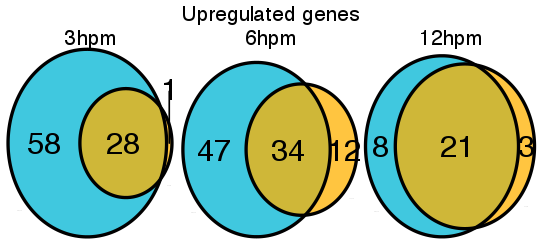

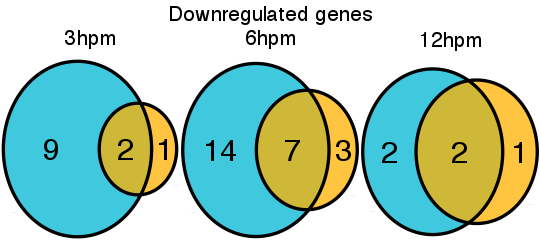

In [178]:
RT_UP_3hrs_Vdiag<-venn.diagram(RT_UP_3hrs_candidates, NULL, fill=c("#ffb200","#00b5d4"), alpha=c(0.75,0.75), cex = 1.5, cat.fontface= 2, cat.cex = 0, resolution = 1000, main = "3hpm")
RT_UP_6hrs_Vdiag<-venn.diagram(RT_UP_6hrs_candidates, NULL, fill=c("#ffb200","#00b5d4"), alpha=c(0.75,0.75), cex = 1.5, cat.fontface= 2, cat.cex = 0, resolution = 1000, main = "6hpm")
RT_UP_12hrs_Vdiag<-venn.diagram(RT_UP_12hrs_candidates, NULL, fill=c("#ffb200","#00b5d4"), alpha=c(0.75,0.75), cex = 1.5, cat.fontface= 2, cat.cex = 0, resolution = 1000, main = "12hpm")
RT_Down_3hrs_Vdiag<-venn.diagram(RT_Down_3hrs_candidates, NULL, fill=c("#ffb200","#00b5d4"), alpha=c(0.75,0.75), cex = 1.5, cat.fontface= 2, cat.cex = 0, resolution = 1000, main = "3hpm")
RT_Down_6hrs_Vdiag<-venn.diagram(RT_Down_6hrs_candidates, NULL, fill=c("#ffb200","#00b5d4"), alpha=c(0.75,0.75), cex = 1.5, cat.fontface= 2, cat.cex = 0, resolution = 1000, main = "6hpm")
RT_Down_12hrs_Vdiag<-venn.diagram(RT_Down_12hrs_candidates, NULL, fill=c("#ffb200","#00b5d4"), alpha=c(0.75,0.75), cex = 1.5, cat.fontface= 2, cat.cex = 0, resolution = 1000, main = "12hpm")
# "#3f5a2a",
# "#ffb200","#00b5d4"
options(repr.plot.width = 4.5, repr.plot.height = 2)

# pdf("Figures/Venn_diag.up.pdf", width = 4.5, height = 2)
grid.arrange(gTree(children=RT_UP_3hrs_Vdiag), gTree(children=RT_UP_6hrs_Vdiag), gTree(children=RT_UP_12hrs_Vdiag), ncol = 3, top = "Upregulated genes")
# dev.off()

# pdf("Figures/Venn_diag.down.pdf", width = 4.5, height = 2)
grid.arrange(gTree(children=RT_Down_3hrs_Vdiag), gTree(children=RT_Down_6hrs_Vdiag), gTree(children=RT_Down_12hrs_Vdiag), ncol = 3, top = "Downregulated genes")
# dev.off()

If we want to look at interactive Glimma volcano plots, we need to run the decideTestsDGE for each glmTreat output:

In [179]:
dt_C3.v.vir = decideTestsDGE(glmT_C3.v.vir)
dt_C6.v.vir = decideTestsDGE(glmT_C6.v.vir)
dt_C12.v.vir = decideTestsDGE(glmT_C12.v.vir)
dt_H3.v.vir = decideTestsDGE(glmT_H3.v.vir)
dt_H6.v.vir = decideTestsDGE(glmT_H6.v.vir)
dt_H12.v.vir = decideTestsDGE(glmT_H12.v.vir)

Here's one example of a volcano plot between heterospecific 6hpm samples and virgins:

In [180]:
# glXYPlot(x=glmT_H6.v.vir$table$logFC, y=-log10(glmT_H6.v.vir$table$PValue), xlab="logFC", ylab="logodds", status=dt_H6.v.vir, groups=sampleInfo.pm$SampleName, anno = ann.pmv, side.main="gene_name", counts = dgeList.pmv)

##### Analysis of upregulated genes in the female RT:

First we'll look at those genes that are upregulated in the RT across all three postmating timepoints. We'll first generate a list of these genes and a TPM matrix for the conspecific condition samples:

In [181]:
RT_upregulated_genes = unique(unlist(c(RT_UP_3hrs_elements, RT_UP_6hrs_elements, RT_UP_12hrs_elements)))
message(paste("There are ", length(RT_upregulated_genes), " upregulated genes", sep =""))
RT_upregulated_genes_matrix = subset(tpmMatrix_bt2.fbgn, rownames(tpmMatrix_bt2.fbgn) %in% RT_upregulated_genes)

RT_upregulated_genes_matrix = RT_upregulated_genes_matrix[ , grepl("RT", names(RT_upregulated_genes_matrix))]
RT_upregulated_genes_matrix_con = subset(RT_upregulated_genes_matrix, select = c("Female_V_RT", "Female_C3_RT", "Female_C6_RT", "Female_C12_RT"))
RT_upregulated_genes_matrix_het = subset(RT_upregulated_genes_matrix, select = c("Female_V_RT", "Female_H3_RT", "Female_H6_RT", "Female_H12_RT"))

There are 128 upregulated genes


We can perform clustering of these genes by expression profile across all samples. We'll first need to estimate an appropriate number of clusters.

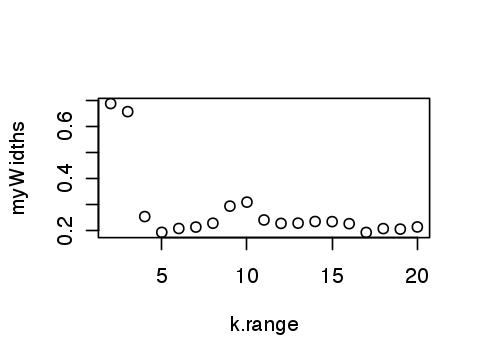

In [182]:
options(repr.plot.width = 4, repr.plot.height = 3)
findK(RT_upregulated_genes_matrix)

Cruedly, it looks like 6 clusters will aproopriately represent groupings of this gene set. We'll re-examine this after performing the analysis. First we'll run the cluster analysis:

In [183]:
rt_up_data = RT_upregulated_genes_matrix
rt_up_data = log2(rt_up_data+1)
rt_up_data = as.matrix(rt_up_data) # convert to matrix
rt_up_data = t(scale(t(rt_up_data), scale=F))
sample_cor = cor(rt_up_data, method='pearson', use='pairwise.complete.obs')
sample_dist = as.dist(1-sample_cor)
hc_samples = hclust(sample_dist, method='complete')
gene_cor = NULL
if (is.null(gene_cor)) { gene_cor = cor(t(rt_up_data), method='pearson', use='pairwise.complete.obs') }
gene_dist = as.dist(1-gene_cor)
hc_genes = hclust(gene_dist, method='complete')
gene_partition_assignments <- cutree(as.hclust(hc_genes), k=6)

## can also be done by tree height:
#gene_partition_assignments <- cutree(as.hclust(hc_genes), h=50/100*max(hc_genes$height))

Here we'll just generate some color parameters for each cluster:

In [184]:
partition_colors = rainbow(length(unique(gene_partition_assignments)), start=0.4, end=0.95)
gene_colors_dframe = data.frame(clusters=gene_partition_assignments, colors=partition_colors[gene_partition_assignments])
gene_colors = as.matrix(partition_colors[gene_partition_assignments])

Now we can plot a heatmap of these genes with their cluster identification:

for plotting:: min.raw: -2 max.raw: 2


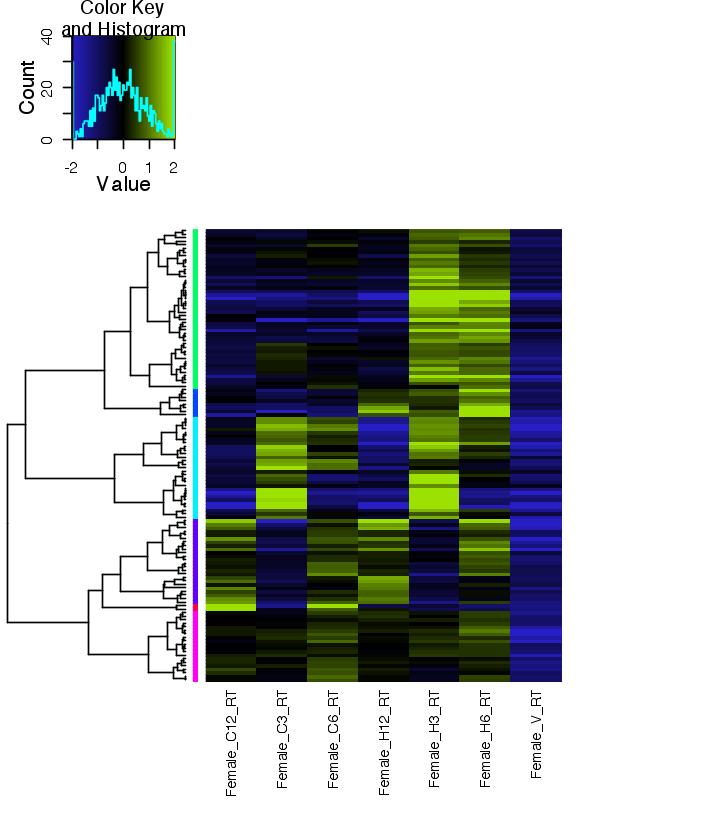

In [185]:
heatmap_data = rt_up_data
heatmap_data[heatmap_data < -2] = -2
heatmap_data[heatmap_data > 2] = 2
myheatcol = colorpanel(75, '#271fc5','black','#9de100')
options(repr.plot.width = 6, repr.plot.height = 7)
heatmap.3(heatmap_data, dendrogram = "row", Rowv=as.dendrogram(hc_genes), Colv = c("V_RT", "C3_RT", "C6_RT", "C12_RT"),col=myheatcol, RowSideColors=gene_colors, scale="none", density.info="histogram", trace="none", key=TRUE, cexCol=1, margins=c(10,10), cexRow=0.5, labRow = F)

The cluster grouping (coloured bars on the left) seem to correspond well to overall grouping of gene expression profiles.

We'll loop over the cluster assignments and import them into the cluster list object:

In [186]:
cluster_list = list()
max_cluster_count = max(gene_partition_assignments)
for (i in 1:max_cluster_count) {
    partition_i = (gene_partition_assignments == i)
    partition_data = rt_up_data[partition_i,,drop=F]
    cluster_list[[i]] = as.data.frame(partition_data)
    cluster_list[[i]]$Gene_ID = rownames(cluster_list[[i]])
    cluster_list[[i]]$cluster = paste("cluster_", i, sep = "")
}

#cluster_list
cluster_PM_rt_up_data = rbindlist(cluster_list)

Now we'll generate a data frame with expression data for these clusters to make line plots of each cluster:

In [187]:
conSub = subset(cluster_PM_rt_up_data, select = c("Gene_ID", "cluster", "Female_V_RT", "Female_C3_RT", "Female_C6_RT", "Female_C12_RT"))
hetSub = subset(cluster_PM_rt_up_data, select = c("Gene_ID", "cluster", "Female_V_RT", "Female_H3_RT", "Female_H6_RT", "Female_H12_RT"))

df.conSub = melt(conSub, id.vars = c("Gene_ID", "cluster"))
df.conSub$condition <- ifelse(grepl("C", df.conSub$variable, ignore.case = F), "conspecific", ifelse(grepl("H", df.conSub$variable, ignore.case = F), "heterospecific", "virgin"))
df.conSub$time <- ifelse(grepl("3", df.conSub$variable), "3hpm", ifelse(grepl("6", df.conSub$variable), "6hpm", ifelse(grepl("12", df.conSub$variable), "12hpm","virgin")))
df.conSub$time = factor(df.conSub$time, levels = c("virgin", "3hpm", "6hpm", "12hpm"))
df.conSub$crossType = "conspecific"

df.hetSub = melt(hetSub, id.vars = c("Gene_ID", "cluster"))
df.hetSub$condition <- ifelse(grepl("C", df.hetSub$variable, ignore.case = F), "conspecific", ifelse(grepl("H", df.hetSub$variable, ignore.case = F), "heterospecific", "virgin"))
df.hetSub$time <- ifelse(grepl("3", df.hetSub$variable), "3hpm", ifelse(grepl("6", df.hetSub$variable), "6hpm", ifelse(grepl("12", df.hetSub$variable), "12hpm","virgin")))
df.hetSub$time = factor(df.hetSub$time, levels = c("virgin", "3hpm", "6hpm", "12hpm"))
df.hetSub$crossType = "heterospecific"

rt_up_Clusters = rbind(df.conSub, df.hetSub)

We can plot it like so:

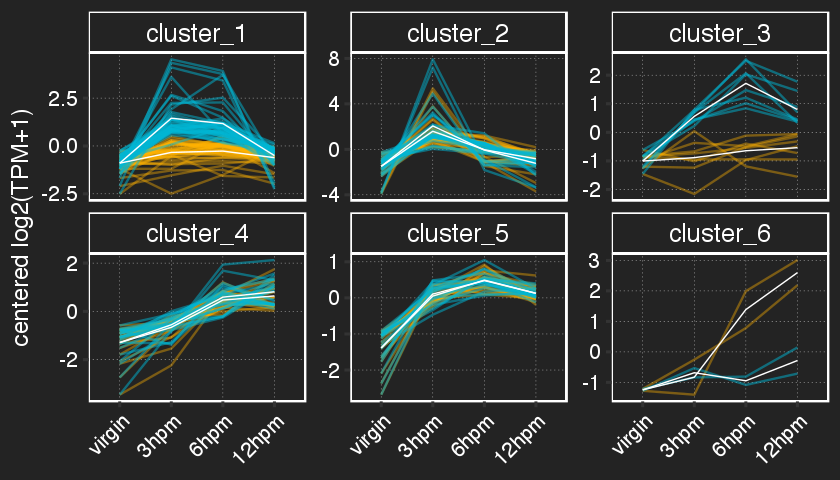

In [188]:
rt_up_Clusters$cluster = factor(rt_up_Clusters$cluster, levels = c("cluster_1", 
                                                   "cluster_2", 
                                                   "cluster_3", 
                                                   "cluster_4", 
                                                   "cluster_5", 
#                                                    "cluster_6", 
#                                                    "cluster_7", 
                                                   "cluster_6"))
options(repr.plot.width = 7, repr.plot.height = 4)
# pdf("Figures/cluster_groupings.pdf", width = 7, height = 4)
# pdf("~/Dropbox/Faculty_Job_Applications/University.of.NewMexico_15Nov2018/Job_Talk/Images/cluster_groupings.pdf", width = 7, height = 4)
ggplot() + 
    geom_line(data = subset(rt_up_Clusters, crossType == "conspecific"),
              aes(time, value, group = Gene_ID), 
              colour = "#ffb200",
              alpha = 0.4,
              size = 0.5) +
    geom_line(data = subset(rt_up_Clusters, crossType == "heterospecific"), 
              aes(time, value, group = Gene_ID), 
              colour = "#00b5d4",
              alpha = 0.5,
              size = 0.5) +
    facet_wrap('cluster',scales='free_y', nrow = 2) +
    scale_color_hue(l=50,h.start=200) + 
    theme_monokai_full() +
    theme(axis.text.x=element_text(angle=45,hjust=1, size = 12),
         axis.text.y = element_text(size = 12),
         axis.title.x = element_blank(),
         axis.title.y = element_text(size = 14),
         strip.text = element_text(size = 15)) +
    stat_summary(data = rt_up_Clusters, 
                 aes(x=time,y=value,group=crossType),
                 fun.data="mean_cl_boot",
                 color="white",
                 fill="black",
                 alpha=0.2,
                 size=0.3,
                 geom="smooth") +
    ylab("centered log2(TPM+1)")
# dev.off()

Let's output individual gene plots of all thesegenes, partitioned by cluster:

In [189]:
# DE.genes_up_C1_boxPlots = suppressMessages(lapply(unique(rt_up_Clusters$Gene_ID[rt_up_Clusters$cluster == "cluster_1"]), geneBoxPlot, object = tpmTable_bt2.fbgn))
# ggsave("Results/Plots/DE.RT_genes_up_C1_boxPlots.pdf", marrangeGrob(grobs = DE.genes_up_C1_boxPlots, nrow = 3, ncol =1))

# DE.genes_up_C2_boxPlots = suppressMessages(lapply(unique(rt_up_Clusters$Gene_ID[rt_up_Clusters$cluster == "cluster_2"]), geneBoxPlot, object = tpmTable_bt2.fbgn))
# ggsave("Results/Plots/DE.RT_genes_up_C2_boxPlots.pdf", marrangeGrob(grobs = DE.genes_up_C2_boxPlots, nrow = 3, ncol =1))

# DE.genes_up_C3_boxPlots = suppressMessages(lapply(unique(rt_up_Clusters$Gene_ID[rt_up_Clusters$cluster == "cluster_3"]), geneBoxPlot, object = tpmTable_bt2.fbgn))
# ggsave("Results/Plots/DE.RT_genes_up_C3_boxPlots.pdf", marrangeGrob(grobs = DE.genes_up_C3_boxPlots, nrow = 3, ncol =1))

# DE.genes_up_C4_boxPlots = suppressMessages(lapply(unique(rt_up_Clusters$Gene_ID[rt_up_Clusters$cluster == "cluster_4"]), geneBoxPlot, object = tpmTable_bt2.fbgn))
# ggsave("Results/Plots/DE.RT_genes_up_C4_boxPlots.pdf", marrangeGrob(grobs = DE.genes_up_C4_boxPlots, nrow = 3, ncol =1))

# DE.genes_up_C5_boxPlots = suppressMessages(lapply(unique(rt_up_Clusters$Gene_ID[rt_up_Clusters$cluster == "cluster_5"]), geneBoxPlot, object = tpmTable_bt2.fbgn))
# ggsave("Results/Plots/DE.RT_genes_up_C5_boxPlots.pdf", marrangeGrob(grobs = DE.genes_up_C5_boxPlots, nrow = 3, ncol =1))

# DE.genes_up_C6_boxPlots = suppressMessages(lapply(unique(rt_up_Clusters$Gene_ID[rt_up_Clusters$cluster == "cluster_6"]), geneBoxPlot, object = tpmTable_bt2.fbgn))
# ggsave("Results/Plots/DE.RT_genes_up_C6_boxPlots.pdf", marrangeGrob(grobs = DE.genes_up_C6_boxPlots, nrow = 3, ncol =1))

Let's look at GO enrichment across all upregulated genes:

In [190]:
rt_up_cluster.factor.labeling = as.data.frame(unique(subset(rt_up_Clusters, select = c("Gene_ID", "cluster"))))
row.names(rt_up_cluster.factor.labeling) <- rt_up_cluster.factor.labeling$Gene_ID
rt_up_cluster.factor.labeling = subset(rt_up_cluster.factor.labeling, select = "cluster")
rt_up_cluster.factor_list = unique(rt_up_cluster.factor.labeling[,1])

In [191]:
cat_genes_vec = as.integer(features_with_GO %in% rt_up_Clusters$Gene_ID)
pwf$DEgenes = cat_genes_vec
res = goseq(pwf,gene2cat=GO_info_listed)
## over-represented categories:
pvals = res$over_represented_pvalue
pvals[pvals > 1 -1e-10] = 1-1e-10
q = qvalue(pvals)
res$over_represented_FDR = q$qvalues
rt_up_enrich_result_table = res[res$over_represented_pvalue<=0.05,]
descr = unlist(lapply(rt_up_enrich_result_table$category, get_GO_term_descr))
rt_up_enrich_result_table$go_term = descr

Using manually entered categories.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns


There's lots of term redundancy here in the Biological process category. We'll output the result, then prune with GOtrim:

In [192]:
GO_sub = subset(rt_up_enrich_result_table, over_represented_FDR < 0.05)
# GO_sub = subset(GO_sub, select = c("category", "numDEInCat", "numInCat"))
write.table(GO_sub, "Results/GO_analyses/RT_postmating_up_DE_for_pruning.txt", quote = F, sep = "\t", row.names = F)

After visibly pruning, we re-load the pruned table:

In [193]:
GO_sub_pruned = read.csv("Results/GO_analyses/RT_postmating_up_DE_PRUNED.txt", header = T, sep = "\t")

And can plot them as before:

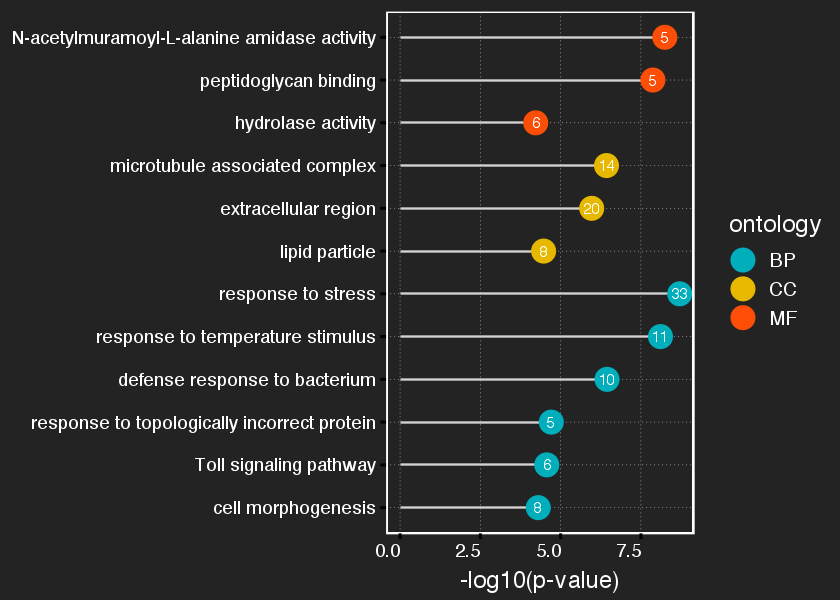

In [194]:
thisData = subset(GO_sub_pruned, over_represented_FDR < 0.05)
thisData$neg_log10_FDR = -log10(thisData$over_represented_pvalue)

options(repr.plot.width = 7, repr.plot.height = 5)
# pdf("Figures/postmating_GO_lollipop.pdf", width = 6, height = 5)
# pdf("~/Dropbox/Faculty_Job_Applications/University.of.NewMexico_15Nov2018/Job_Talk/Images/postmating_GO_lollipop.pdf", width = 7, height = 4)
ggdotchart(thisData, x = "term", y = "neg_log10_FDR",
           color = "ontology",                                # Color by groups
           palette = c("#00AFBB", "#E7B800", "#FC4E07"), # Custom color palette
           sorting = "descending",                       # Sort value in descending order
           add = "segments",                             # Add segments from y = 0 to dots
           rotate = TRUE,                                # Rotate vertically
           group = "ontology",                                # Order by groups
           dot.size = 6,                                 # Large dot size
           label = "numDEInCat",                        # Add mpg values as dot labels
           font.label = list(color = "white", size = 9, 
                             vjust = 0.5),               # Adjust label parameters
           ggtheme = theme_monokai_full()                        # ggplot2 theme
           ) + labs(y = "-log10(p-value)", x = NULL)
# dev.off()

Here's a more exhaustive bubble plot:

Warning message:
"Removed 1 rows containing missing values (geom_point)."Warning message:
"Removed 1 rows containing missing values (geom_text_repel)."

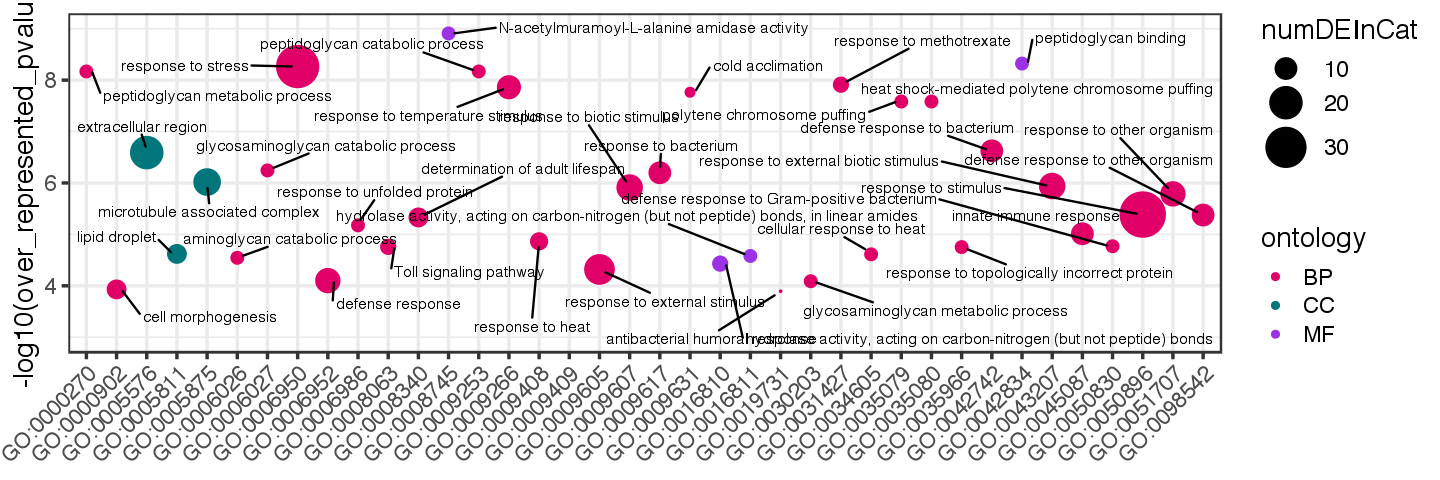

In [195]:
options(repr.plot.width = 12, repr.plot.height = 4)
ggplot(subset(rt_up_enrich_result_table, over_represented_FDR < 0.05), 
       aes(category, -log10(over_represented_pvalue), size = numDEInCat, colour = ontology)) + 
    geom_point() +
#     facet_grid(.~ontology, scale = "free_x") +
    xlab(NULL) + 
    geom_text_repel(data = subset(rt_up_enrich_result_table, over_represented_FDR < 0.05), 
                    aes(category, -log10(over_represented_pvalue),label=term), 
                    force = 50, 
                    inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 3) + 
    theme(axis.text.x = element_text(angle = 45, face = "bold", vjust = 1, hjust = 1)) + 
    scale_size(range = c(0,12)) + 
    scale_colour_manual(values=c("#e00068",
                                 "#01777b",
                                 "#9d31e4")) + 
    scale_y_continuous(limits=c(3, 9))

And the KEGG enrichment:

In [196]:
RTup_genes_altIDs = subset(dv1.06_features, FBgn_ID %in% rt_up_Clusters$Gene_ID)$gene_name
RTup_genes_altIDs = gsub("^", "Dvir_", RTup_genes_altIDs)
RTup_kegg <- enrichKEGG(gene = RTup_genes_altIDs, organism = 'dvi')
subset(RTup_kegg@result, qvalue < 0.05)
write.table(RTup_kegg@result, "Results/KEGG/RTup-biased_kegg_table.txt", quote = F, sep = "\t", row.names = F)

ID       Description                                 GeneRatio
dvi04141 dvi04141 Protein processing in endoplasmic reticulum 9/27     
dvi04624 dvi04624 Toll and Imd signaling pathway              4/27     
         BgRatio  pvalue       p.adjust     qvalue      
dvi04141 136/3345 5.862815e-07 0.0000158296 1.481132e-05
dvi04624 56/3345  9.288385e-04 0.0125393194 1.173270e-02
         geneID                                                                                                              
dvi04141 Dvir_GJ10911/Dvir_GJ17455/Dvir_GJ17778/Dvir_GJ21096/Dvir_GJ19774/Dvir_GJ16781/Dvir_GJ22515/Dvir_GJ18387/Dvir_GJ14116
dvi04624 Dvir_GJ23481/Dvir_GJ25693/Dvir_GJ20957/Dvir_GJ22479                                                                 
         Count
dvi04141 9    
dvi04624 4

Now let's run the GO enrichment analysis for each cluster. First we create a factor labeling object:

In [198]:
rt_up_GO_enriched_list = list()

invisible(suppressWarnings(suppressMessages(
for (feature_cat in rt_up_cluster.factor_list) {
    message('Processing category: ', feature_cat)
    cat_genes_vec = as.integer(features_with_GO %in% rownames(rt_up_cluster.factor.labeling)[rt_up_cluster.factor.labeling$cluster == feature_cat])
    pwf$DEgenes = cat_genes_vec
    res = goseq(pwf,gene2cat=GO_info_listed)
    ## over-represented categories:
    pvals = res$over_represented_pvalue
    pvals[pvals > 1 -1e-10] = 1-1e-10
    q = qvalue(pvals)
    res$over_represented_FDR = q$qvalues
    go_enrich_factor = feature_cat
    enrich_result_table = res[res$over_represented_pvalue<=0.05,]
    descr = unlist(lapply(enrich_result_table$category, get_GO_term_descr))
    enrich_result_table$go_term = descr
    enrich_result_table$factor = go_enrich_factor
    rt_up_GO_enriched_list[[feature_cat]] = enrich_result_table
}
)))
rt_up_GO_enrichment_data = rbindlist(rt_up_GO_enriched_list)
write.table(rt_up_GO_enrichment_data, "Results/GO_analyses/GO_results-RT_clusters_upregulated_genes_aBT2.txt", quote = F, sep = "\t", row.names = F)
unique(filter(rt_up_GO_enrichment_data, over_represented_FDR < 0.05)$factor)

[1] "cluster_2" "cluster_4"

We can output a PDF of gene plots for different categories of upregulated genes. First, we'll create lists of DE genes that are unique to either con- or heterospecific condition, or are shared:

In [199]:
hetUnique.3hpm = setdiff(intersect(DE.genes_H3.v.vir_up, sig.het_up.3hpm_list), DE.genes_C3.v.vir_up)
hetUnique.6hpm = setdiff(intersect(DE.genes_H6.v.vir_up, sig.het_up.6hpm_list), DE.genes_C6.v.vir_up)
hetUnique.12hpm = setdiff(intersect(DE.genes_H12.v.vir_up, sig.het_up.12hpm_list), DE.genes_C12.v.vir_up)
DE.genes_up_het_unique = unique(c(hetUnique.3hpm, hetUnique.6hpm, hetUnique.12hpm))

In [200]:
conUnique.3hpm = setdiff(intersect(DE.genes_C3.v.vir_up, sig.het_down.3hpm_list), DE.genes_H3.v.vir_up)
conUnique.6hpm = setdiff(intersect(DE.genes_C6.v.vir_up, sig.het_down.6hpm_list), DE.genes_H6.v.vir_up)
conUnique.12hpm = setdiff(intersect(DE.genes_C12.v.vir_up, sig.het_down.12hpm_list), DE.genes_H12.v.vir_up)
DE.genes_up_con_unique = unique(c(conUnique.3hpm, conUnique.6hpm, conUnique.12hpm))

In [201]:
shared.3hpm = setdiff(intersect(DE.genes_C3.v.vir_up, DE.genes_H3.v.vir_up), c(sig.het_up.3hpm_list, sig.het_down.3hpm_list))
shared.6hpm = setdiff(intersect(DE.genes_C6.v.vir_up, DE.genes_H6.v.vir_up), c(sig.het_up.6hpm_list, sig.het_down.6hpm_list))
shared.12hpm = setdiff(intersect(DE.genes_C12.v.vir_up, DE.genes_H12.v.vir_up), c(sig.het_up.12hpm_list, sig.het_down.12hpm_list))
DE.genes_up_shared = unique(c(shared.3hpm, shared.6hpm, shared.12hpm))

Here we'll output these plots:

In [202]:
DE.genes_up_con_specific_boxPlots = suppressMessages(lapply(DE.genes_up_con_unique, geneBoxPlot, object = tpmTable_bt2.fbgn))
ggsave("Results/Plots/RT_Upregulated_genes_in_con_condition.pdf", marrangeGrob(grobs = DE.genes_up_con_specific_boxPlots, nrow = 3, ncol =1))

DE.genes_up_het_specific_boxPlots = suppressMessages(lapply(DE.genes_up_het_unique, geneBoxPlot, object = tpmTable_bt2.fbgn))
ggsave("Results/Plots/RT_Upregulated_genes_in_het_condition.pdf", marrangeGrob(grobs = DE.genes_up_het_specific_boxPlots, nrow = 3, ncol =1))

DE.genes_up_shared_boxPlots = suppressMessages(lapply(DE.genes_up_shared, geneBoxPlot, object = tpmTable_bt2.fbgn))
ggsave("Results/Plots/RT_Upregulated_genes_shared.pdf", marrangeGrob(grobs = DE.genes_up_shared_boxPlots, nrow = 3, ncol =1))

Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image


We can also run GO analyses on these three groups separately (actually just on the shared ones; either specific group has no enrichment):

In [203]:
## Shared
cat_genes_vec = as.integer(features_with_GO %in% DE.genes_up_shared)
pwf$DEgenes = cat_genes_vec
res = goseq(pwf,gene2cat=GO_info_listed)
## over-represented categories:
pvals = res$over_represented_pvalue
pvals[pvals > 1 -1e-10] = 1-1e-10
q = qvalue(pvals)
res$over_represented_FDR = q$qvalues
RT_Up_shared.enrich_result_table = res[res$over_represented_pvalue<=0.05,]
descr = unlist(lapply(RT_Up_shared.enrich_result_table$category, get_GO_term_descr))
RT_Up_shared.enrich_result_table$go_term = descr
RT_Up_shared.enrich_result_table$factor = go_enrich_factor
write.table(RT_Up_shared.enrich_result_table, "Results/GO_analyses/GO_results-RT_upregulated_genes_shared_aBT2.txt", quote = F, sep = "\t", row.names = F)

Using manually entered categories.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns


###### Immune and JNK pathway genes that are uniquely upregulated in the heterospecific condition:

Immune genes feature prominantly among upregulated genes that are specific to the heterospecific condition. Let's make an individual gene plot for those. First, some edits for some data frame:

In [204]:
melOrthsAll$mel_GeneSymbol = gsub("CG12780, ", "", melOrthsAll$mel_GeneSymbol)
annot.sum$SwissProt_BlastX_Description = gsub("Phospholipase A2 isozymes PA3A/PA3B/PA5", "Phospholipase", annot.sum$SwissProt_BlastX_Description)

Now generate a grid plot:

In [205]:
options(repr.plot.width = 9, repr.plot.height = 5)
attacin = RT.geneBoxPlot(tpmTable_bt2.fbgn, "FBgn0207711") 
defensin = RT.geneBoxPlot(tpmTable_bt2.fbgn, "FBgn0209590") 
cecropin = RT.geneBoxPlot(tpmTable_bt2.fbgn, "FBgn0017816") + labs(title = "Cec2B", subtitle = "Cecropin-2") 
gnbp = RT.geneBoxPlot(tpmTable_bt2.fbgn, "FBgn0207804") + labs(title = "GJ20666 (GNBP-like3)", subtitle = "Gram-negative bacteria-binding\nprotein 3") 
relish = RT.geneBoxPlot(tpmTable_bt2.fbgn, "FBgn0210579") 
immune_genes_plots = plot_grid(attacin, defensin, cecropin, gnbp, relish, ncol = 3, align = "h")

ALso for JNK pathway genes:

In [206]:
options(repr.plot.width = 6, repr.plot.height = 5)
gadd45 = RT.geneBoxPlot(tpmTable_bt2.fbgn, "FBgn0208196") + labs(title = "GJ21062 (Gadd45)", subtitle = "Growth arrest and DNA-dammage\ninducible protein") 
ets21c = RT.geneBoxPlot(tpmTable_bt2.fbgn, "FBgn0206847")
GIIIspla2 = RT.geneBoxPlot(tpmTable_bt2.fbgn, "FBgn0206553") 
socs = RT.geneBoxPlot(tpmTable_bt2.fbgn, "FBgn0197572")
jnkStat_genes_plots = plot_grid(gadd45, ets21c, GIIIspla2, socs, ncol = 2, align = "h")

Now combine them:

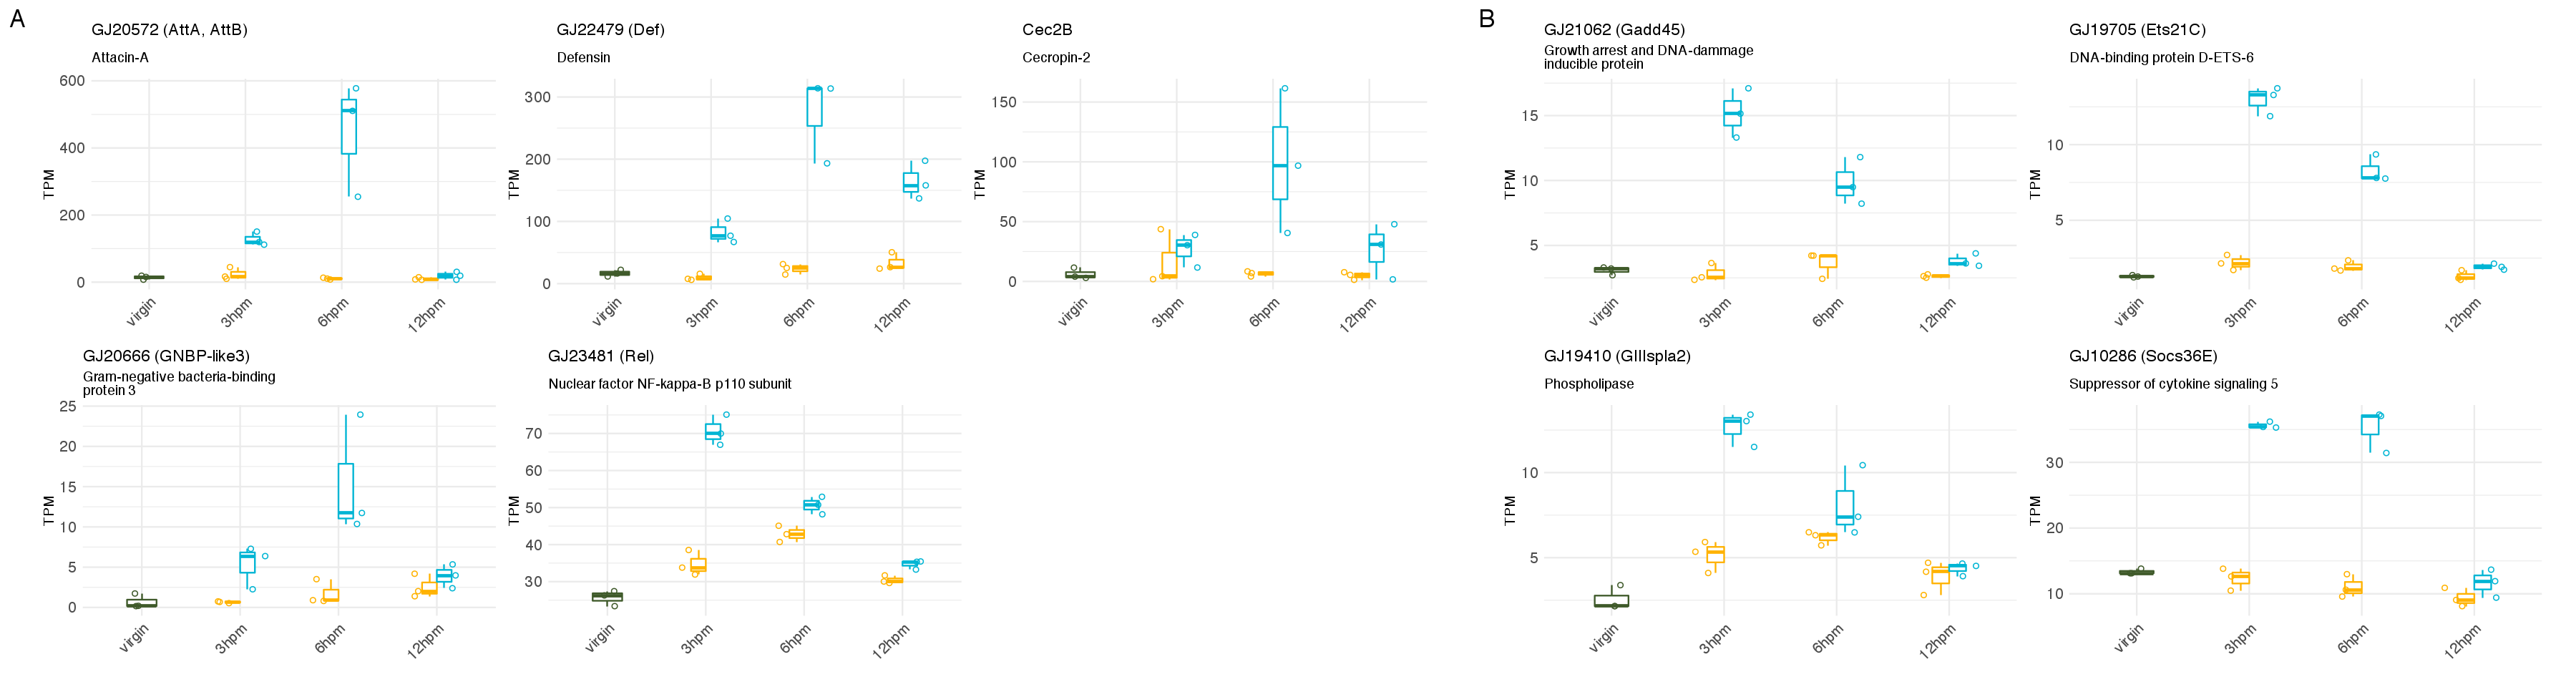

In [207]:
options(repr.plot.width = 30, repr.plot.height = 8)
# pdf("~/Dropbox/Faculty_Job_Applications/University.of.NewMexico_15Nov2018/Job_Talk/Images/immuneGenes.pdf", height = 30, width = 8)
plot_grid(immune_genes_plots, jnkStat_genes_plots, ncol = 2, labels = "AUTO", rel_widths = c(1.33, 1), label_size = 20, scale = c(0.95, 0.95)) 
# dev.off()

##### Analysis of downregulated genes in the female RT:

First we'll look at those genes that are upregulated in the RT across all three postmating timepoints. We'll first generate a list of these genes and a TPM matrix for the conspecific condition samples:

In [208]:
RT_downregulated_genes = unique(unlist(c(RT_Down_3hrs_elements, RT_Down_6hrs_elements, RT_Down_12hrs_elements)))
message(paste("There are ", length(RT_downregulated_genes), " downregulated genes", sep =""))
RT_downregulated_genes_matrix = subset(tpmMatrix_bt2.fbgn, rownames(tpmMatrix_bt2.fbgn) %in% RT_downregulated_genes)

RT_downregulated_genes_matrix = RT_downregulated_genes_matrix[ , grepl("RT", names(RT_downregulated_genes_matrix))]
RT_downregulated_genes_matrix_con = subset(RT_downregulated_genes_matrix, select = c("Female_V_RT", "Female_C3_RT", "Female_C6_RT", "Female_C12_RT"))
RT_downregulated_genes_matrix_het = subset(RT_downregulated_genes_matrix, select = c("Female_V_RT", "Female_H3_RT", "Female_H6_RT", "Female_H12_RT"))

There are 31 downregulated genes


We can perform clustering of these genes by expression profile across the conspecific samples. We'll first need to estimate an appropriate number of clusters.

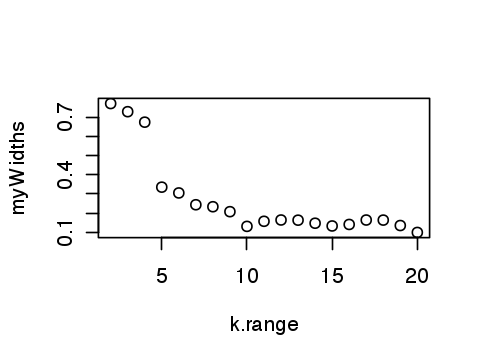

In [209]:
options(repr.plot.width = 4, repr.plot.height = 3)
findK(RT_downregulated_genes_matrix)

Cruedly, it looks like 5 clusters will aproopriately represent groupings of this gene set. We'll re-examine this after performing the analysis. First we'll run the cluster analysis:

In [210]:
rt_down_data = RT_downregulated_genes_matrix
rt_down_data = log2(rt_down_data+1)
rt_down_data = as.matrix(rt_down_data) # convert to matrix
rt_down_data = t(scale(t(rt_down_data), scale=F))
sample_cor = cor(rt_down_data, method='pearson', use='pairwise.complete.obs')
sample_dist = as.dist(1-sample_cor)
hc_samples = hclust(sample_dist, method='complete')
gene_cor = NULL
if (is.null(gene_cor)) { gene_cor = cor(t(rt_down_data), method='pearson', use='pairwise.complete.obs') }
gene_dist = as.dist(1-gene_cor)
hc_genes = hclust(gene_dist, method='complete')
gene_partition_assignments <- cutree(as.hclust(hc_genes), k=6)

## can also be done by tree height:
#gene_partition_assignments <- cutree(as.hclust(hc_genes), h=50/100*max(hc_genes$height))

Here we'll just generate some color parameters for each cluster:

In [211]:
partition_colors = rainbow(length(unique(gene_partition_assignments)), start=0.4, end=0.95)
gene_colors_dframe = data.frame(clusters=gene_partition_assignments, colors=partition_colors[gene_partition_assignments])
gene_colors = as.matrix(partition_colors[gene_partition_assignments])

Now we can plot a heatmap of these genes with their cluster identification:

for plotting:: min.raw: -2 max.raw: 2


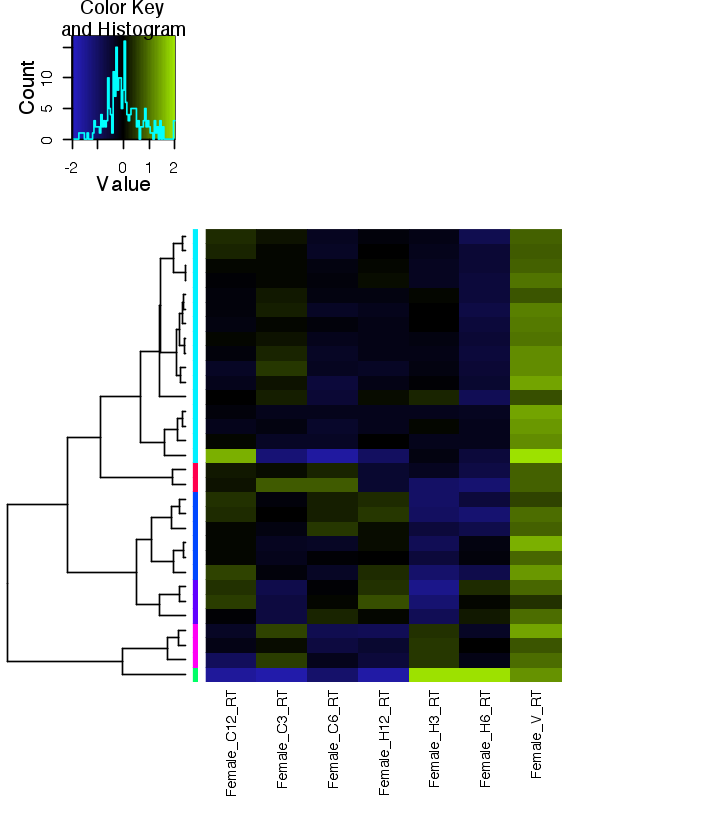

In [212]:
heatmap_data = rt_down_data
heatmap_data[heatmap_data < -2] = -2
heatmap_data[heatmap_data > 2] = 2
options(repr.plot.width = 6, repr.plot.height = 7)
heatmap.3(heatmap_data, dendrogram = "row", Rowv=as.dendrogram(hc_genes), Colv = c("V_RT", "C3_RT", "C6_RT", "C12_RT"),col=myheatcol, RowSideColors=gene_colors, scale="none", density.info="histogram", trace="none", key=TRUE, cexCol=1, margins=c(10,10), cexRow=0.5, labRow = F)

The cluster grouping (coloured bars on the left) seem to correspond well to overall grouping of gene expression profiles.

We'll loop over the cluster assignments and import them into the cluster list object:

In [213]:
cluster_list = list()
max_cluster_count = max(gene_partition_assignments)
for (i in 1:max_cluster_count) {
    partition_i = (gene_partition_assignments == i)
    partition_data = rt_down_data[partition_i,,drop=F]
    cluster_list[[i]] = as.data.frame(partition_data)
    cluster_list[[i]]$Gene_ID = rownames(cluster_list[[i]])
    cluster_list[[i]]$cluster = paste("cluster_", i, sep = "")
}

#cluster_list
cluster_PM_rt_down_data = rbindlist(cluster_list)

Now we'll generate a data frame with expression data for these clusters to make line plots of each cluster:

In [214]:
conSub = subset(cluster_PM_rt_down_data, select = c("Gene_ID", "cluster", "Female_V_RT", "Female_C3_RT", "Female_C6_RT", "Female_C12_RT"))
hetSub = subset(cluster_PM_rt_down_data, select = c("Gene_ID", "cluster", "Female_V_RT", "Female_H3_RT", "Female_H6_RT", "Female_H12_RT"))

df.conSub = melt(conSub, id.vars = c("Gene_ID", "cluster"))
df.conSub$condition <- ifelse(grepl("C", df.conSub$variable, ignore.case = F), "conspecific", ifelse(grepl("H", df.conSub$variable, ignore.case = F), "heterospecific", "virgin"))
df.conSub$time <- ifelse(grepl("3", df.conSub$variable), "3hpm", ifelse(grepl("6", df.conSub$variable), "6hpm", ifelse(grepl("12", df.conSub$variable), "12hpm","virgin")))
df.conSub$time = factor(df.conSub$time, levels = c("virgin", "3hpm", "6hpm", "12hpm"))
df.conSub$crossType = "conspecific"

df.hetSub = melt(hetSub, id.vars = c("Gene_ID", "cluster"))
df.hetSub$condition <- ifelse(grepl("C", df.hetSub$variable, ignore.case = F), "conspecific", ifelse(grepl("H", df.hetSub$variable, ignore.case = F), "heterospecific", "virgin"))
df.hetSub$time <- ifelse(grepl("3", df.hetSub$variable), "3hpm", ifelse(grepl("6", df.hetSub$variable), "6hpm", ifelse(grepl("12", df.hetSub$variable), "12hpm","virgin")))
df.hetSub$time = factor(df.hetSub$time, levels = c("virgin", "3hpm", "6hpm", "12hpm"))
df.hetSub$crossType = "heterospecific"

rt_down_Clusters = rbind(df.conSub, df.hetSub)

We can plot it like so:

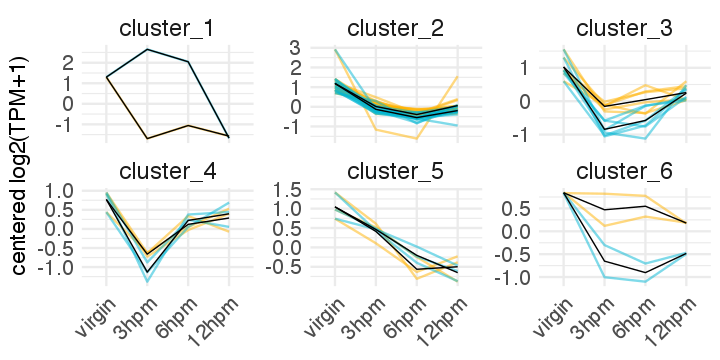

In [215]:
rt_down_Clusters$cluster = factor(rt_down_Clusters$cluster, levels = c("cluster_1", 
                                                   "cluster_2", 
                                                   "cluster_3", 
                                                   "cluster_4",
                                                   "cluster_5",
                                                   "cluster_6" 
#                                                    "cluster_7", 
                                                  ))
options(repr.plot.width = 6, repr.plot.height = 3)
# pdf("Figures/cluster_groupings_down.pdf", width = 6, height = 3)
ggplot() + 
    geom_line(data = subset(rt_down_Clusters, crossType == "conspecific"),
              aes(time, value, group = Gene_ID), 
              colour = "#ffb200",
              alpha = 0.5,
              size = 0.5) +
    geom_line(data = subset(rt_down_Clusters, crossType == "heterospecific"), 
              aes(time, value, group = Gene_ID), 
              colour = "#00b5d4",
              alpha = 0.5,
              size = 0.5) +
    theme_minimal() + 
    facet_wrap('cluster',scales='free_y', nrow = 2) +
    scale_color_hue(l=50,h.start=200) + 
    theme(axis.text.x=element_text(angle=45,hjust=1, size = 12),
         axis.text.y = element_text(size = 12),
         axis.title.x = element_blank(),
         axis.title.y = element_text(size = 13),
         strip.text = element_text(size = 14)) +
    stat_summary(data = rt_down_Clusters, 
                 aes(x=time,y=value,group=crossType),
                 fun.data="mean_cl_boot",
                 color="black",
                 fill="black",
                 alpha=0.2,
                 size=0.3,
                 geom="smooth") +
    ylab("centered log2(TPM+1)")
# dev.off()

Let's output individual gene plots of all thesegenes, partitioned by cluster:

In [216]:
# DE.genes_down_C1_boxPlots = suppressMessages(lapply(unique(newSub$Gene_ID[newSub$cluster == "cluster_1"]), geneBoxPlot, object = tpmTable_bt2.fbgn))
# ggsave("Results/Plots/DE.RT_genes_down_C1_boxPlots.pdf", marrangeGrob(grobs = DE.genes_down_C1_boxPlots, nrow = 3, ncol =1))

# DE.genes_down_C2_boxPlots = suppressMessages(lapply(unique(newSub$Gene_ID[newSub$cluster == "cluster_2"]), geneBoxPlot, object = tpmTable_bt2.fbgn))
# ggsave("Results/Plots/DE.RT_genes_down_C2_boxPlots.pdf", marrangeGrob(grobs = DE.genes_down_C2_boxPlots, nrow = 3, ncol =1))

# DE.genes_down_C3_boxPlots = suppressMessages(lapply(unique(newSub$Gene_ID[newSub$cluster == "cluster_3"]), geneBoxPlot, object = tpmTable_bt2.fbgn))
# ggsave("Results/Plots/DE.RT_genes_down_C3_boxPlots.pdf", marrangeGrob(grobs = DE.genes_down_C3_boxPlots, nrow = 3, ncol =1))

# DE.genes_down_C4_boxPlots = suppressMessages(lapply(unique(newSub$Gene_ID[newSub$cluster == "cluster_4"]), geneBoxPlot, object = tpmTable_bt2.fbgn))
# ggsave("Results/Plots/DE.RT_genes_down_C4_boxPlots.pdf", marrangeGrob(grobs = DE.genes_down_C4_boxPlots, nrow = 3, ncol =1))

# DE.genes_down_C5_boxPlots = suppressMessages(lapply(unique(newSub$Gene_ID[newSub$cluster == "cluster_5"]), geneBoxPlot, object = tpmTable_bt2.fbgn))
# ggsave("Results/Plots/DE.RT_genes_down_C5_boxPlots.pdf", marrangeGrob(grobs = DE.genes_down_C5_boxPlots, nrow = 3, ncol =1))

# DE.genes_down_C6_boxPlots = suppressMessages(lapply(unique(newSub$Gene_ID[newSub$cluster == "cluster_6"]), geneBoxPlot, object = tpmTable_bt2.fbgn))
# ggsave("Results/Plots/DE.RT_genes_down_C6_boxPlots.pdf", marrangeGrob(grobs = DE.genes_down_C6_boxPlots, nrow = 3, ncol =1))

Let's look at GO enrichment across all downregulated genes:

In [217]:
cat_genes_vec = as.integer(features_with_GO %in% rt_down_Clusters$Gene_ID)
pwf$DEgenes = cat_genes_vec
res = goseq(pwf,gene2cat=GO_info_listed)
## over-represented categories:
pvals = res$over_represented_pvalue
pvals[pvals > 1 -1e-10] = 1-1e-10
q = qvalue(pvals)
res$over_represented_FDR = q$qvalues
rt_down_enrich_result_table = res[res$over_represented_pvalue<=0.05,]
descr = unlist(lapply(rt_down_enrich_result_table$category, get_GO_term_descr))
rt_down_enrich_result_table$go_term = descr
subset(rt_down_enrich_result_table, over_represented_FDR < 0.05)

Using manually entered categories.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns


category over_represented_pvalue under_represented_pvalue numDEInCat
     numInCat term ontology over_represented_FDR go_term

No significant GO terms.

### Ovaries post-mating contrasts:

Create ovaries-specific count matrix 

In [218]:
counts_bt2.fbgn.OV = subset(counts_bt2.fbgn, select=grepl("OV", colnames(counts_bt2.fbgn)))
colnames(counts_bt2.fbgn.OV) = gsub("Female_", "", colnames(counts_bt2.fbgn.OV))

Now let's filter low expression genes within a minimum cpm of 5:

In [219]:
cpm_bt2.fbgn.OV <- cpm(counts_bt2.fbgn.OV)
thresh_OV.bt2.fbgn <- cpm_bt2.fbgn.OV > 5

countsKeep_OV.bt2.fbgn <- rowSums(thresh_OV.bt2.fbgn) >= 2
countsFiltered_bt2.fbgn.OV <- counts_bt2.fbgn.OV[countsKeep_OV.bt2.fbgn,]
## Check how many genes remain in the matrix.
dim(countsFiltered_bt2.fbgn.OV)

## Clean-up
rm(cpm_bt2.fbgn.OV, countsKeep_OV.bt2.fbgn, thresh_OV.bt2.fbgn)

[1] 7236    6

We'll also subset the samplesInfo object to only include the RT samples:

In [220]:
sampleInfo.ov = subset(sampleInfo, Tissue == "ovaries")
sampleInfo.ov$SampleName = gsub("Female_", "", sampleInfo.ov$SampleName)
sampleInfo.ov$Replicate = gsub("Female_", "", sampleInfo.ov$Replicate)

#### Comparing each postmating time point to the virgin ovary sample and to each other:

Here we can set up new grouping and comparison matrix with all the postmating time-point samples by combining the "Status" and "time" factors:

In [221]:
## Will need to relevel the Status grouping to make virgin control
Status.time <- factor(paste(sampleInfo.ov$Status, sampleInfo.ov$Time, sep="."))
sampleInfo.ov <- cbind(sampleInfo.ov, Group=Status.time)
sampleInfo.ov$Group <- relevel(sampleInfo.ov$Group, ref = "virgin.virgin")

Next we need to set a different matrix where we test for differences between conspecific and heterospecific treatments of each time point:

In [222]:
groups.ovb <- factor(sampleInfo.ov$SampleName)
design.ovb <- model.matrix(~ 0 + groups.ovb)
colnames(design.ovb) <- levels(groups.ovb)
rownames(design.ovb) <- sampleInfo.ov$Replicate

Create edgeR DE object and run glmFit

In [223]:
dgeList.ov <- DGEList(counts = countsFiltered_bt2.fbgn.OV, group = groups.ovb)
dgeList.ov <- calcNormFactors(dgeList.ov)
dgeList.ov <- estimateCommonDisp(dgeList.ov)
dgeList.ov <- estimateTagwiseDisp(dgeList.ov)
dgeList.ov_fit <- glmFit(dgeList.ov, design.ovb)

Let's add the annotation information to this fit object:

In [224]:
# Extract annotation for genes in the fit object
ann.ov = subset(Annots, FBgn_ID %in% rownames(dgeList.ov_fit))
ann.ov = subset(ann.ov, select = c("FBgn_ID", "gene_name", "SwissProt_BlastX_Description"))
# convert factors to characters
ann.ov = data.frame(lapply(ann.ov, as.character), stringsAsFactors=FALSE)
# align the fit object's rownames with gene ID's
ann.ov = ann.ov[match(rownames(dgeList.ov_fit), ann.ov$FBgn_ID),]
# convert factors to characters, again
ann.ov <- data.frame(lapply(ann.ov, as.character), stringsAsFactors=FALSE)
# Rename "FBgn_ID" as "GeneID"
colnames(ann.ov) = c ("GeneID", "gene_name", "SwissProt_BlastX_Description")
# Check that the fit rownames match the annotation file's gene ID's
table(ann.ov$GeneID==rownames(dgeList.ov_fit))
# Add the annotations to the fit object in the "genes" slot
dgeList.ov_fit$genes = ann.ov


TRUE 
7236 

Also, check the tagwise dispersion summary:

In [225]:
summary(dgeList.ov$tagwise.dispersion)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.01674 0.02010 0.02253 0.03031 0.03200 1.20083 

Again, quick look at the BCV, mean-variance trend, qq-plot and normalized count distributions.

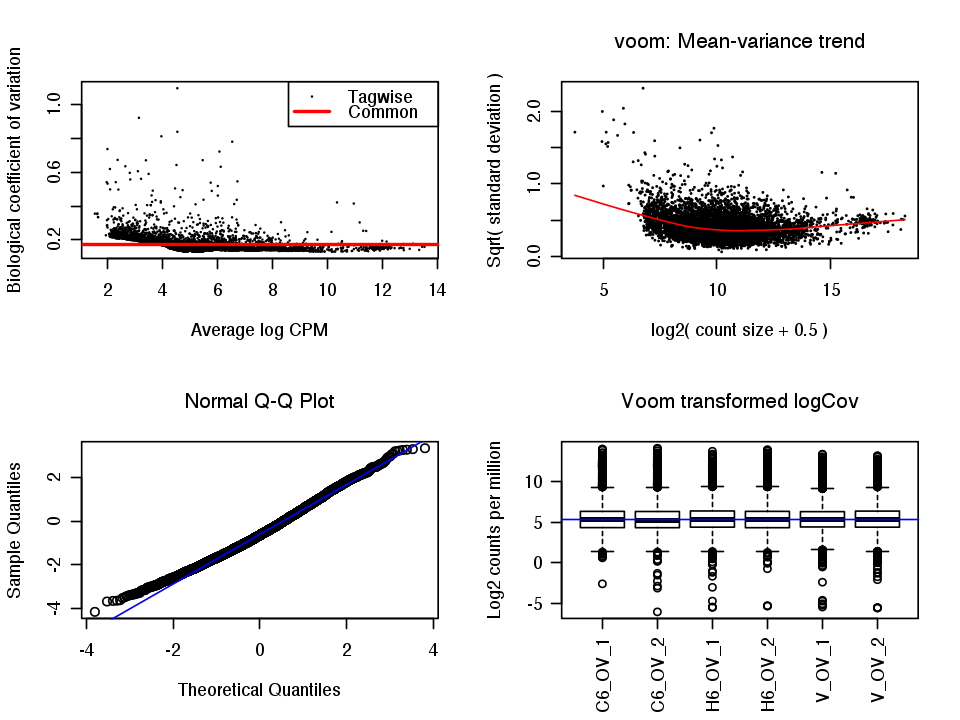

In [226]:
options(repr.plot.width = 8, repr.plot.height = 6)
par(mfrow=c(2,2))
# Biological coefficient of variation
plotBCV(dgeList.ov)
# mean-variance trend
ov.voom = voom(dgeList.ov, design.ovb, plot=TRUE)
# QQ-plot
g.ov <- gof(dgeList.ov_fit)
z.ov <- zscoreGamma(g.ov$gof.statistics,shape=g.ov$df/2,scale=2)
qqnorm(z.ov); qqline(z.ov, col = 4,lwd=1,lty=1)
# log2 transformed and normalize boxplot of counts across samples
boxplot(ov.voom$E, xlab="", ylab="Log2 counts per million",las=2,main="Voom transformed logCov")
abline(h=median(ov.voom$E),col="blue")

And make an MDS plot with Limma:

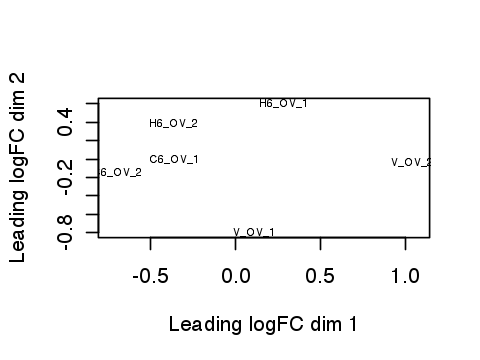

In [227]:
options(repr.plot.width = 4, repr.plot.height = 3)
plotMDS(dgeList.ov, cex = 0.5)

Let's look at samples correlation:

In [228]:
sampleColLabeling = subset(sampleInfo.ov, select = c("SampleName", "Replicate"))
sampleColLabeling = filter(sampleColLabeling, grepl("OV", SampleName))
rownames(sampleColLabeling) = sampleColLabeling$Replicate
sampleColLabeling = subset(sampleColLabeling, select = SampleName)
colnames(sampleColLabeling) = "Sample"
sampleColLabeling$Sample = factor(sampleColLabeling$Sample, levels = c("V_OV", "C6_OV", "H6_OV"))

Now plot it:

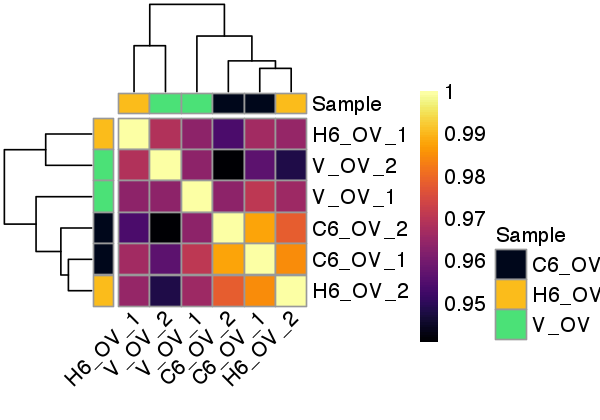

In [229]:
## Plot sample correlation
data = log2(countsFiltered_bt2.fbgn.OV+1)
colnames(data) = gsub("Female_", "", colnames(data))
data = as.matrix(data)
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')

cor_colors <- list(Sample = c("#00071b","#fbbc1b","#4be177"))
names(cor_colors$Sample) <- unique(sampleColLabeling$Sample)

options(repr.plot.width = 5, repr.plot.height = 3.5)
pheatmap(
  mat               = sample_cor,
  color             = inferno(100),
#   border_color      = NA,
  annotation_col    = sampleColLabeling,
  annotation_row    = sampleColLabeling,
  drop_levels       = TRUE,
  annotation_colors = cor_colors,
  show_colnames     = TRUE,
  show_rownames     = TRUE,
  annotation_names_row = F,
#   filename          = "Figures/repTract_sample_correlations.pdf",
#   width             = 7, 
#   height            = 5,
  fontsize          = 12    
)

To perform pairwise differential expression tests between postmating samples and the virgin sample, we can run glmTreat by specifying the coefficient (have to look at the matrix), and only capture genes with >2-fold expression difference. First set some contrasts:

In [230]:
het.v.vir_ov <- makeContrasts(hOV.vs.vOV=H6_OV-V_OV, levels=design.ovb)
con.v.vir_ov <- makeContrasts(cOV.vs.vOV=C6_OV-V_OV, levels=design.ovb)
het.v.con_ov <- makeContrasts(hOV.vs.cOV=H6_OV-C6_OV, levels=design.ovb)
vir.v.PM_ov <- makeContrasts(hOV.vs.vOV=H6_OV-V_OV, cOV.vs.vOV=C6_OV-V_OV, levels=design.ovb)

Now we can fit the negative binomial log-linear model to conduct gene-wise statistical tests. For each contrast, we will extract the table with the relevant DE stats. Start with the contrast between the virgin samples and both post-mating samples:

In [231]:
lrt_ov_vir.v.PM <- glmLRT(dgeList.ov_fit, contrast = vir.v.PM_ov)
lrt_ov_vir.v.PM.tTags <- topTags(lrt_ov_vir.v.PM, n = NULL)
lrt_ov_vir.v.PM.tTags.table <- lrt_ov_vir.v.PM.tTags$table

OV_vir.v.PM.list_Het.up<-subset(lrt_ov_vir.v.PM.tTags.table, logFC.hOV.vs.vOV > 1 & FDR<0.05)$GeneID
OV_vir.v.PM.list_Het.down<-subset(lrt_ov_vir.v.PM.tTags.table, logFC.hOV.vs.vOV < -1 & FDR<0.05)$GeneID

OV_vir.v.PM.list_Con.up<-subset(lrt_ov_vir.v.PM.tTags.table, logFC.cOV.vs.vOV > 1 & FDR<0.05)$GeneID
OV_vir.v.PM.list_Con.down<-subset(lrt_ov_vir.v.PM.tTags.table, logFC.cOV.vs.vOV < -1 & FDR<0.05)$GeneID

paste(length(OV_vir.v.PM.list_Het.up), " genes are upregulated in the heterospecific cross, and ", length(OV_vir.v.PM.list_Het.down), " are downregualted", sep = "")
paste(length(OV_vir.v.PM.list_Con.up), " genes are upregulated in the conspecific cross, and ", length(OV_vir.v.PM.list_Con.down), " are downregualted", sep = "")

[1] "43 genes are upregulated in the heterospecific cross, and 15 are downregualted"

[1] "64 genes are upregulated in the conspecific cross, and 13 are downregualted"

Now the individual comparisons between postmating samples and virgin:

In [232]:
lrt_ov_het.v.vir <- glmLRT(dgeList.ov_fit, contrast = het.v.vir_ov)
lrt_ov_het.v.vir.tTags <- topTags(lrt_ov_het.v.vir, n = NULL)
lrt_ov_het.v.vir.tTags.table <- lrt_ov_het.v.vir.tTags$table

# let's make several lists with varying fold-change stringency (default is >2-fold)
OV_het.v.vir.list_up<-subset(lrt_ov_het.v.vir.tTags.table, logFC > 1 & FDR<0.05)$GeneID
OV_het.v.vir.list_down<-subset(lrt_ov_het.v.vir.tTags.table, logFC < -1 & FDR<0.05)$GeneID
OV_het.v.vir.list <- union(OV_het.v.vir.list_up, OV_het.v.vir.list_down)

paste(length(OV_het.v.vir.list_up), " genes are upregulated in the heterospecific cross, and ", length(OV_het.v.vir.list_down), " are downregualted" ,sep = "")

[1] "36 genes are upregulated in the heterospecific cross, and 11 are downregualted"

In [233]:
lrt_ov_con.v.vir <- glmLRT(dgeList.ov_fit, contrast = con.v.vir_ov)
lrt_ov_con.v.vir.tTags <- topTags(lrt_ov_con.v.vir, n = NULL)
lrt_ov_con.v.vir.tTags.table <- lrt_ov_con.v.vir.tTags$table

# let's make several lists with varying fold-change stringency (default is >2-fold)
OV_con.v.vir.list_up<-subset(lrt_ov_con.v.vir.tTags.table, logFC > 1 & FDR<0.05)$GeneID
OV_con.v.vir.list_down<-subset(lrt_ov_con.v.vir.tTags.table, logFC < -1 & FDR<0.05)$GeneID
OV_con.v.vir.list <- union(OV_con.v.vir.list_up, OV_con.v.vir.list_down)

paste(length(OV_con.v.vir.list_up), " genes are upregulated in the conspecific cross, and ", length(OV_con.v.vir.list_down), " are downregualted" ,sep = "")

[1] "77 genes are upregulated in the conspecific cross, and 14 are downregualted"

In [234]:
lrt_ov_het.v.con <- glmLRT(dgeList.ov_fit, contrast = het.v.con_ov)
lrt_ov_het.v.con.tTags <- topTags(lrt_ov_het.v.con, n = NULL)
lrt_ov_het.v.con.tTags.table <- lrt_ov_het.v.con.tTags$table

# let's make several lists with varying fold-change stringency (default is >2-fold)
OV_het.v.con.list_up<-subset(lrt_ov_het.v.con.tTags.table, logFC > 1 & FDR<0.05)$GeneID
OV_het.v.con.list_down<-subset(lrt_ov_het.v.con.tTags.table, logFC < -1 & FDR<0.05)$GeneID

paste(length(OV_het.v.con.list_up), " genes are upregulated in the heterospecific cross compared to conspecific, and ", length(OV_het.v.con.list_down), " are downregualted" ,sep = "")

[1] "6 genes are upregulated in the heterospecific cross compared to conspecific, and 12 are downregualted"

Now let's plot the fold-change values between the two postmating contrasts:

In [235]:
tmp.ov.Data = lrt_ov_vir.v.PM.tTags.table
tmp.ov.Data$sig = ifelse(tmp.ov.Data$GeneID %in% OV_het.v.vir.list_up & tmp.ov.Data$GeneID %in% OV_con.v.vir.list_up,
                     "both upregulated",
                     ifelse(tmp.ov.Data$GeneID %in% OV_het.v.vir.list_down & tmp.ov.Data$GeneID %in% OV_con.v.vir.list_down,
                            "both downregulated",
                            ifelse(tmp.ov.Data$GeneID %in% OV_het.v.vir.list_up & tmp.ov.Data$GeneID %in% OV_con.v.vir.list_down,
                                   "het. up, con. down",
                                   ifelse(tmp.ov.Data$GeneID %in% OV_het.v.vir.list_down & tmp.ov.Data$GeneID %in% OV_con.v.vir.list_up,
                                          "het. down, con. up",
                                          ifelse(tmp.ov.Data$GeneID %in% OV_het.v.vir.list_up & tmp.ov.Data$GeneID %!in% OV_con.v.vir.list,
                                                 "het. up",
                                                 ifelse(tmp.ov.Data$GeneID %in% OV_het.v.vir.list_down & tmp.ov.Data$GeneID %!in% OV_con.v.vir.list,
                                                        "het. down",
                                                        ifelse(tmp.ov.Data$GeneID %!in% OV_het.v.vir.list & tmp.ov.Data$GeneID %in% OV_con.v.vir.list_up,
                                                               "con. up",
                                                               ifelse(tmp.ov.Data$GeneID %!in% OV_het.v.vir.list & tmp.ov.Data$GeneID %in% OV_con.v.vir.list_down,"con. down", "ns"))))))))
tmp.ov.Data$Status = ifelse(tmp.ov.Data$sig == "both downregulated" | tmp.ov.Data$sig == "both upregulated", 
                        "normal", 
                        ifelse(tmp.ov.Data$sig == "con. down" | tmp.ov.Data$sig == "con. up", 
                               "conspecific", 
                               ifelse(tmp.ov.Data$sig == "het. down" | tmp.ov.Data$sig == "het. up", 
                                      "heterospecific", 
                                      ifelse(tmp.ov.Data$sig == "het. down" & tmp.ov.Data$sig == "con. up",
                                            "opposite",
                                            ifelse(tmp.ov.Data$sig == "con. down" & tmp.ov.Data$sig == "het. up",
                                                   "opposite",
                                                   "n.s.")))))
tmp.ov.Data$Status = factor(tmp.ov.Data$Status, levels = c("normal", "conspecific", "heterospecific", "opposite", "n.s."))
# tmp.ov.Data = melt(tmp.ov.Data, id.vars = c("GeneID", "gene_name", "SwissProt_BlastX_Description", "logCPM", "LR", "PValue", "FDR"))
head(tmp.ov.Data, n = 2)
# rm(tmp.ov.Data)

GeneID      gene_name        SwissProt_BlastX_Description
FBgn0016402 FBgn0016402 ActD1            Actin, larval muscle        
FBgn0256712 FBgn0256712 5.8SrRNA:GJ24878 .                           
            logFC.hOV.vs.vOV logFC.cOV.vs.vOV logCPM   LR        PValue      
FBgn0016402 0.05314706       3.297080         2.759706 123.95625 1.211273e-27
FBgn0256712 0.14376608       3.542185         2.477356  97.52596 6.645175e-22
            FDR          sig     Status     
FBgn0016402 8.764772e-24 con. up conspecific
FBgn0256712 2.404224e-18 con. up conspecific

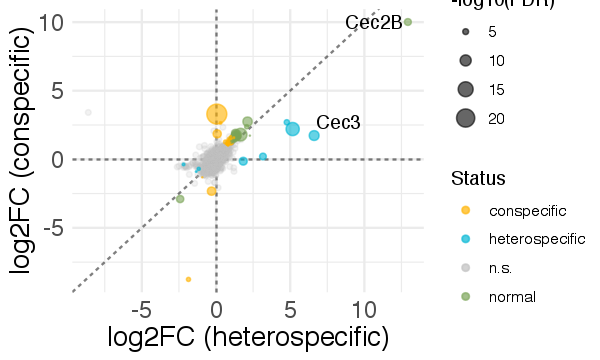

In [179]:
options(repr.plot.width = 5, repr.plot.height = 3)
ggplot() + 
        theme_minimal() +
        geom_vline(xintercept = 0, linetype = "dashed", alpha = 0.5) + 
        geom_hline(yintercept = 0, linetype = "dashed", alpha = 0.5) +
#         scale_colour_manual(values = c("#ffb200","#00b5d4","#ed1f34")) + 
        geom_text_repel(data = filter(tmp.ov.Data, grepl("Cec", gene_name)), 
                        aes(logFC.hOV.vs.vOV, logFC.cOV.vs.vOV, label = gene_name),
                        force = 50) +
#         geom_text_repel(data = filter(tmp.ov.Data, ), 
#                         aes(logFC.hOV.vs.vOV, logFC.cOV.vs.vOV, label = gene_name),
#                         force = 50) +
        geom_abline(intercept = 0, slope = 1, linetype = "dashed", alpha = 0.5)+
        geom_point(data = filter(tmp.ov.Data, !grepl("rRNA", gene_name) & Status == "n.s."),
                   aes(logFC.hOV.vs.vOV, logFC.cOV.vs.vOV, colour = Status), 
                   size = 1, 
#                    colour = "gray",
                   alpha = 0.2) + 
        geom_point(data = filter(tmp.ov.Data, !grepl("rRNA", gene_name) & Status != "n.s."),
                   aes(logFC.hOV.vs.vOV, logFC.cOV.vs.vOV, colour = Status, size = -log10(FDR)),
#                    size = 3,
                   alpha = 0.6) +
        scale_size(range = c(-2,5)) + 
        theme(axis.text = element_text(size = 14, face = "bold"), axis.title = element_text(size = 16, face = "bold")) +
        labs(x = "log2FC (heterospecific)", y = "log2FC (conspecific)") +
        scale_colour_manual(values = c("#ffb200", "#00b5d4", "grey", "#7aa457"))

##### Analysis of upregulated genes in the female ovary:

First we'll look at those genes that are upregulated in ovaries across the two postmating timepoints. We'll first generate a list of these genes and a TPM matrix for the conspecific condition samples:

In [236]:
OV_upregulated_genes = unique(c(OV_het.v.vir.list_up, OV_con.v.vir.list_up))
message(paste("There are ", length(OV_upregulated_genes), " upregulated genes", sep =""))
OV_upregulated_genes_matrix = subset(tpmMatrix_bt2.fbgn, rownames(tpmMatrix_bt2.fbgn) %in% OV_upregulated_genes)

OV_upregulated_genes_matrix = OV_upregulated_genes_matrix[ , grepl("OV", names(OV_upregulated_genes_matrix))]
OV_upregulated_genes_matrix_con = subset(OV_upregulated_genes_matrix, select = c("Female_V_OV", "Female_C6_OV"))
OV_upregulated_genes_matrix_het = subset(OV_upregulated_genes_matrix, select = c("Female_V_OV", "Female_H6_OV"))

There are 87 upregulated genes


We can perform clustering of these genes by expression profile across the conspecific samples. We'll first need to estimate an appropriate number of clusters.

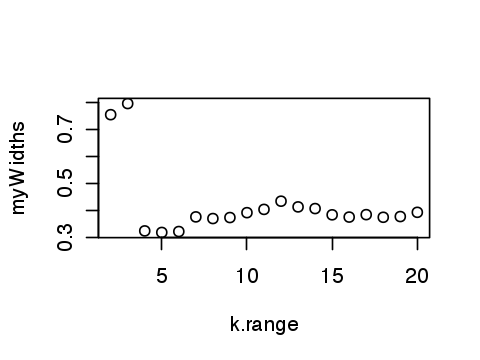

In [237]:
options(repr.plot.width = 4, repr.plot.height = 3)
findK(OV_upregulated_genes_matrix)

Cruedly, it looks like 3 clusters will aproopriately represent groupings of this gene set. We'll re-examine this after performing the analysis. First we'll run the cluster analysis:

In [238]:
data = OV_upregulated_genes_matrix
data = log2(data+1)
data = as.matrix(data) # convert to matrix
data = t(scale(t(data), scale=F))
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')
sample_dist = as.dist(1-sample_cor)
hc_samples = hclust(sample_dist, method='complete')
gene_cor = NULL
if (is.null(gene_cor)) { gene_cor = cor(t(data), method='pearson', use='pairwise.complete.obs') }
gene_dist = as.dist(1-gene_cor)
hc_genes = hclust(gene_dist, method='complete')
gene_partition_assignments <- cutree(as.hclust(hc_genes), k=4)

## can also be done by tree height:
#gene_partition_assignments <- cutree(as.hclust(hc_genes), h=50/100*max(hc_genes$height))

Here we'll just generate some color parameters for each cluster:

In [239]:
partition_colors = rainbow(length(unique(gene_partition_assignments)), start=0.4, end=0.95)
gene_colors_dframe = data.frame(clusters=gene_partition_assignments, colors=partition_colors[gene_partition_assignments])
gene_colors = as.matrix(partition_colors[gene_partition_assignments])

Now we can plot a heatmap of these genes with their cluster identification:

for plotting:: min.raw: -2 max.raw: 2


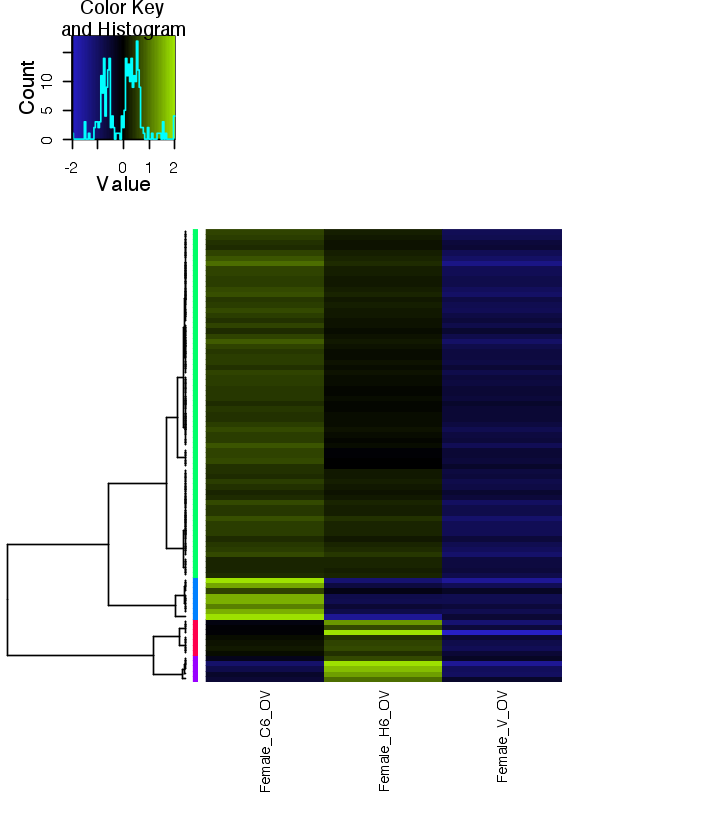

In [240]:
heatmap_data = data
heatmap_data[heatmap_data < -2] = -2
heatmap_data[heatmap_data > 2] = 2
options(repr.plot.width = 6, repr.plot.height = 7)
heatmap.3(heatmap_data, dendrogram = "row", Rowv=as.dendrogram(hc_genes), Colv = c("V_RT", "C3_RT", "C6_RT", "C12_RT"),col=myheatcol, RowSideColors=gene_colors, scale="none", density.info="histogram", trace="none", key=TRUE, cexCol=1, margins=c(10,10), cexRow=0.5, labRow = F)

The cluster grouping (coloured bars on the left) seem to correspond well to overall grouping of gene expression profiles.

We'll loop over the cluster assignments and import them into the cluster list object:

In [241]:
cluster_list = list()
max_cluster_count = max(gene_partition_assignments)
for (i in 1:max_cluster_count) {
    partition_i = (gene_partition_assignments == i)
    partition_data = data[partition_i,,drop=F]
    cluster_list[[i]] = as.data.frame(partition_data)
    cluster_list[[i]]$Gene_ID = rownames(cluster_list[[i]])
    cluster_list[[i]]$cluster = paste("cluster_", i, sep = "")
}

#cluster_list
cluster_OV_data = rbindlist(cluster_list)

Now we'll generate a data frame with expression data for these clusters to make line plots of each cluster:

In [242]:
conSub = subset(cluster_OV_data, select = c("Gene_ID", "cluster", "Female_V_OV", "Female_C6_OV"))
hetSub = subset(cluster_OV_data, select = c("Gene_ID", "cluster", "Female_V_OV", "Female_H6_OV"))

df.conSub = melt(conSub, id.vars = c("Gene_ID", "cluster"))
df.conSub$condition <- ifelse(grepl("C", df.conSub$variable, ignore.case = F), "conspecific", ifelse(grepl("H", df.conSub$variable, ignore.case = F), "heterospecific", "virgin"))
df.conSub$time <- ifelse(grepl("6", df.conSub$variable), "6hpm", "virgin")
df.conSub$time = factor(df.conSub$time, levels = c("virgin", "6hpm"))
df.conSub$crossType = "conspecific"

df.hetSub = melt(hetSub, id.vars = c("Gene_ID", "cluster"))
df.hetSub$condition <- ifelse(grepl("C", df.hetSub$variable, ignore.case = F), "conspecific", ifelse(grepl("H", df.hetSub$variable, ignore.case = F), "heterospecific", "virgin"))
df.hetSub$time <- ifelse(grepl("6", df.hetSub$variable), "6hpm", "virgin")
df.hetSub$time = factor(df.hetSub$time, levels = c("virgin", "6hpm"))
df.hetSub$crossType = "heterospecific"

newSub = rbind(df.conSub, df.hetSub)

We can plot it like so:

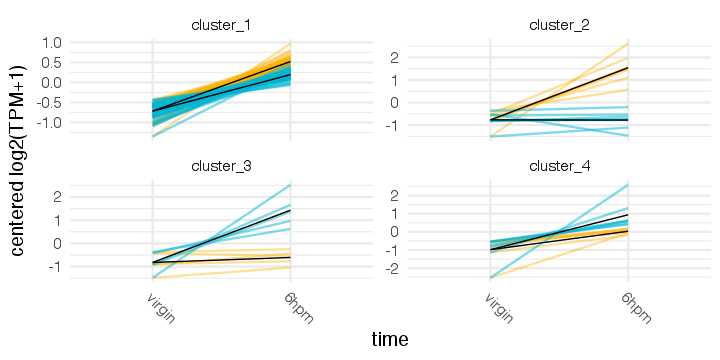

In [243]:
newSub$cluster = factor(newSub$cluster, levels = c("cluster_1", 
                                                   "cluster_2", 
                                                   "cluster_3",
                                                  "cluster_4"))
options(repr.plot.width = 6, repr.plot.height = 3)
# pdf("cluster_groupings.pdf", width = 5, height = 3)
ggplot() + 
    geom_line(data = subset(newSub, crossType == "conspecific"),
              aes(time, value, group = Gene_ID), 
              colour = "#ffb200",
              alpha = 0.4,
              size = 0.5) +
    geom_line(data = subset(newSub, crossType == "heterospecific"), 
              aes(time, value, group = Gene_ID), 
              colour = "#00b5d4",
              alpha = 0.5,
              size = 0.5) +
    theme_minimal() + 
    facet_wrap('cluster',scales='free_y', nrow = 2) +
    scale_color_hue(l=50,h.start=200) + 
    theme(axis.text.x=element_text(angle=-45,hjust=0)) +
    stat_summary(data = newSub, 
                 aes(x=time,y=value,group=crossType),
                 fun.data="mean_cl_boot",
                 color="black",
                 fill="black",
                 alpha=0.2,
                 size=0.3,
                 geom="smooth") +
    ylab("centered log2(TPM+1)")
# dev.off()

We can output the signficant GO results for those clusters here. First we'll make a factor level object:

In [244]:
cluster.factor.labeling = as.data.frame(unique(subset(newSub, select = c("Gene_ID", "cluster"))))
row.names(cluster.factor.labeling) <- cluster.factor.labeling$Gene_ID
cluster.factor.labeling = subset(cluster.factor.labeling, select = "cluster")
cluster.factor_list = unique(cluster.factor.labeling[,1])

In [245]:
GO_enriched_list = list()

invisible(suppressWarnings(suppressMessages(
for (feature_cat in cluster.factor_list) {
    message('Processing category: ', feature_cat)
    cat_genes_vec = as.integer(features_with_GO %in% rownames(cluster.factor.labeling)[cluster.factor.labeling$cluster == feature_cat])
    pwf$DEgenes = cat_genes_vec
    res = goseq(pwf,gene2cat=GO_info_listed)
    ## over-represented categories:
    pvals = res$over_represented_pvalue
    pvals[pvals > 1 -1e-10] = 1-1e-10
    q = qvalue(pvals)
    res$over_represented_FDR = q$qvalues
    go_enrich_factor = feature_cat
    enrich_result_table = res[res$over_represented_pvalue<=0.05,]
    descr = unlist(lapply(enrich_result_table$category, get_GO_term_descr))
    enrich_result_table$go_term = descr
    enrich_result_table$factor = go_enrich_factor
    GO_enriched_list[[feature_cat]] = enrich_result_table
}
)))
GO_enrichment_data = rbindlist(GO_enriched_list)
write.table(GO_enrichment_data, "Results/GO_analyses/GO_results-ovary_clusters_upregulated_genes_aBT2.txt", quote = F, sep = "\t", row.names = F)
unique(filter(GO_enrichment_data, over_represented_FDR < 0.05)$factor)

[1] "cluster_1" "cluster_2"

In [247]:
filter(GO_enrichment_data, over_represented_FDR < 0.05)

category   over_represented_pvalue under_represented_pvalue numDEInCat
1  GO:0007305 9.113468e-09            1.0000000                 3        
2  GO:0030704 9.113468e-09            1.0000000                 3        
3  GO:0035803 9.113468e-09            1.0000000                 3        
4  GO:0035805 9.113468e-09            1.0000000                 3        
5  GO:0060388 9.113468e-09            1.0000000                 3        
6  GO:0030312 1.105493e-06            1.0000000                 4        
7  GO:0005576 3.929345e-06            0.9999994                13        
8  GO:0085029 4.759539e-06            1.0000000                 3        
9  GO:0004129 2.141592e-07            1.0000000                 3        
10 GO:0015002 2.141592e-07            1.0000000                 3        
11 GO:0016675 2.141592e-07            1.0000000                 3        
12 GO:0016676 2.141592e-07            1.0000000                 3        
13 GO:0022900 1.650023e-06            1.0000000                 3        
14 GO:0009055 4.825544e-06            1.0000000                 3        
15 GO:0015078 7.005618e-06            1.0000000                 3        
   numInCat
1    3     
2    3     
3    3     
4    3     
5    3     
6   18     
7  738     
8    7     
9   59     
10  59     
11  59     
12  59     
13  97     
14 124     
15 149     
   term                                                                          
1  vitelline membrane formation involved in chorion-containing eggshell formation
2  vitelline membrane formation                                                  
3  egg coat formation                                                            
4  egg coat                                                                      
5  vitelline envelope                                                            
6  external encapsulating structure                                              
7  extracellular region                                                          
8  extracellular matrix assembly                                                 
9  cytochrome-c oxidase activity                                                 
10 heme-copper terminal oxidase activity                                         
11 oxidoreductase activity, acting on a heme group of donors                     
12 oxidoreductase activity, acting on a heme group of donors, oxygen as acceptor 
13 electron transport chain                                                      
14 electron transfer activity                                                    
15 proton transmembrane transporter activity                                     
   ontology over_represented_FDR
1  BP       2.661133e-05        
2  BP       2.661133e-05        
3  BP       2.661133e-05        
4  CC       2.661133e-05        
5  CC       2.661133e-05        
6  CC       2.690032e-03        
7  CC       8.195492e-03        
8  BP       8.686159e-03        
9  MF       7.816812e-04        
10 MF       7.816812e-04        
11 MF       7.816812e-04        
12 MF       7.816812e-04        
13 BP       4.818067e-03        
14 MF       1.174216e-02        
15 MF       1.461172e-02        
   go_term                                                                          
1  BP vitelline membrane formation involved in chorion-containing eggshell formation
2  BP vitelline membrane formation                                                  
3  BP egg coat formation                                                            
4  CC egg coat                                                                      
5  CC vitelline envelope                                                            
6  CC external encapsulating structure                                              
7  CC extracellular region                                                          
8  BP extracellular matrix assembly                                                 
9  MF cytochrome-c oxi

Can use this cell to plot individual genes belonging to a specific GO category:

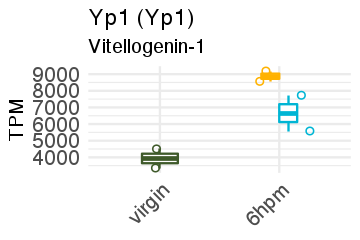

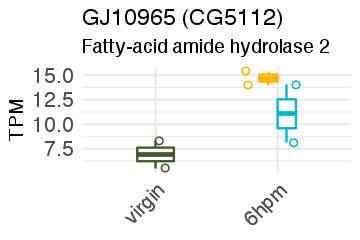

[[1]]

[[2]]

[[3]]

[[4]]


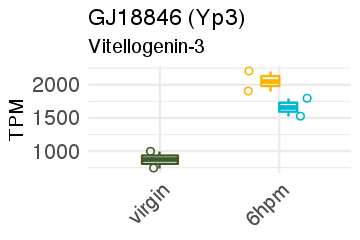

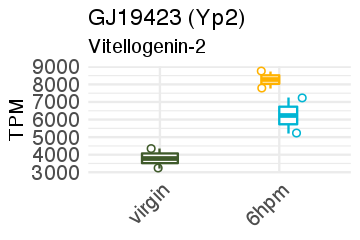

In [251]:
myList = as.character(extract_GO_genes(go_term = "GO:0005811", gene_set = newSub$Gene_ID))
options(repr.plot.width = 3, repr.plot.height =2)
lapply(myList, OV.geneBoxPlot, object = tpmTable_bt2.fbgn)

Let's look at GO enrichment across all upregulated genes:

In [252]:
cat_genes_vec = as.integer(features_with_GO %in% newSub$Gene_ID)
pwf$DEgenes = cat_genes_vec
res = goseq(pwf,gene2cat=GO_info_listed)
## over-represented categories:
pvals = res$over_represented_pvalue
pvals[pvals > 1 -1e-10] = 1-1e-10
q = qvalue(pvals)
res$over_represented_FDR = q$qvalues
enrich_result_table = res[res$over_represented_pvalue<=0.05,]
descr = unlist(lapply(enrich_result_table$category, get_GO_term_descr))
enrich_result_table$go_term = descr
write.table(enrich_result_table, "Results/GO_analyses/GO_results-ovary_upregulated_genes_aBT2.txt", quote = F, sep = "\t", row.names = F)

Using manually entered categories.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns


In [253]:
filter(enrich_result_table, over_represented_FDR < 0.05)

category   over_represented_pvalue under_represented_pvalue numDEInCat
1  GO:0005576 1.443604e-08            1.0000000                18        
2  GO:0007305 1.939431e-08            1.0000000                 3        
3  GO:0030704 1.939431e-08            1.0000000                 3        
4  GO:0035803 1.939431e-08            1.0000000                 3        
5  GO:0035805 1.939431e-08            1.0000000                 3        
6  GO:0060388 1.939431e-08            1.0000000                 3        
7  GO:0009617 2.517360e-07            1.0000000                 9        
8  GO:0022900 1.464818e-06            0.9999999                 6        
9  GO:0030312 3.007034e-06            1.0000000                 4        
10 GO:0070469 5.408119e-06            0.9999998                 5        
11 GO:0016491 9.321459e-06            0.9999982                14        
12 GO:0085029 1.007044e-05            0.9999999                 3        
13 GO:0042742 1.562365e-05            0.9999986                 7        
14 GO:0051707 1.805744e-05            0.9999977                 9        
15 GO:0004129 3.250192e-05            0.9999990                 4        
16 GO:0015002 3.250192e-05            0.9999990                 4        
17 GO:0016675 3.250192e-05            0.9999990                 4        
18 GO:0016676 3.250192e-05            0.9999990                 4        
19 GO:0006091 3.475248e-05            0.9999966                 7        
20 GO:0019731 4.303695e-05            0.9999994                 3        
21 GO:0043207 5.467586e-05            0.9999919                 9        
22 GO:0009607 5.726084e-05            0.9999915                 9        
23 GO:0055114 5.759742e-05            0.9999885                12        
   numInCat
1  738     
2    3     
3    3     
4    3     
5    3     
6    3     
7  163     
8   97     
9   18     
10  74     
11 700     
12   7     
13 147     
14 245     
15  59     
16  59     
17  59     
18  59     
19 190     
20  18     
21 279     
22 282     
23 588     
   term                                                                          
1  extracellular region                                                          
2  vitelline membrane formation involved in chorion-containing eggshell formation
3  vitelline membrane formation                                                  
4  egg coat formation                                                            
5  egg coat                                                                      
6  vitelline envelope                                                            
7  response to bacterium                                                         
8  electron transport chain                                                      
9  external encapsulating structure                                              
10 respiratory chain                                                             
11 oxidoreductase activity                                                       
12 extracellular matrix assembly                                                 
13 defense response to bacterium                                                 
14 response to other organism                                                    
15 cytochrome-c oxidase activity                                                 
16 heme-copper terminal oxidase activity                                         
17 oxidoreductase activity, acting on a heme group of donors                     
18 oxidoreductase activity, acting on a heme group of donors, oxygen as acceptor 
19 generation of precursor metabolites and energy                                
20 antibacterial humoral response                                                
21 response to external biotic stimulus                                          
22 response to biotic stimulus                                                   
23 oxidation-reduction process                       

##### Analysis of downregulated genes in the female ovary:

First we'll look at those genes that are upregulated in the RT across all three postmating timepoints. We'll first generate a list of these genes and a TPM matrix for the conspecific condition samples:

In [254]:
OV_downregulated_genes = unique(c(OV_het.v.vir.list_down, OV_con.v.vir.list_down))
message(paste("There are ", length(OV_downregulated_genes), " downregulated genes", sep =""))
OV_downregulated_genes_matrix = subset(tpmMatrix_bt2.fbgn, rownames(tpmMatrix_bt2.fbgn) %in% OV_downregulated_genes)

OV_downregulated_genes_matrix = OV_downregulated_genes_matrix[ , grepl("OV", names(OV_downregulated_genes_matrix))]
OV_downregulated_genes_matrix_con = subset(OV_downregulated_genes_matrix, select = c("Female_V_OV", "Female_C6_OV"))
OV_downregulated_genes_matrix_het = subset(OV_downregulated_genes_matrix, select = c("Female_V_OV", "Female_H6_OV"))

There are 24 downregulated genes


We can perform clustering of these genes by expression profile across the conspecific samples. We'll first need to estimate an appropriate number of clusters.

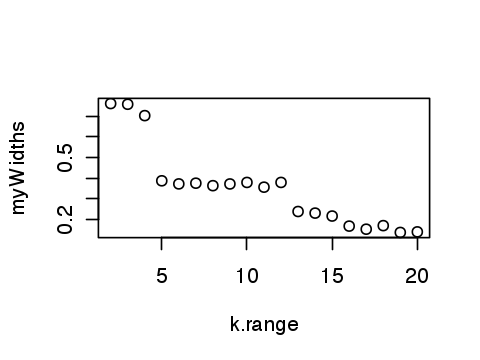

In [255]:
options(repr.plot.width = 4, repr.plot.height = 3)
findK(OV_downregulated_genes_matrix)

Cruedly, it looks like 3 clusters will aproopriately represent groupings of this gene set. We'll re-examine this after performing the analysis. First we'll run the cluster analysis:

In [256]:
data = OV_downregulated_genes_matrix
data = log2(data+1)
data = as.matrix(data) # convert to matrix
data = t(scale(t(data), scale=F))
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')
sample_dist = as.dist(1-sample_cor)
hc_samples = hclust(sample_dist, method='complete')
gene_cor = NULL
if (is.null(gene_cor)) { gene_cor = cor(t(data), method='pearson', use='pairwise.complete.obs') }
gene_dist = as.dist(1-gene_cor)
hc_genes = hclust(gene_dist, method='complete')
gene_partition_assignments <- cutree(as.hclust(hc_genes), k=4)

## can also be done by tree height:
#gene_partition_assignments <- cutree(as.hclust(hc_genes), h=50/100*max(hc_genes$height))

Here we'll just generate some color parameters for each cluster:

In [257]:
partition_colors = rainbow(length(unique(gene_partition_assignments)), start=0.4, end=0.95)
gene_colors_dframe = data.frame(clusters=gene_partition_assignments, colors=partition_colors[gene_partition_assignments])
gene_colors = as.matrix(partition_colors[gene_partition_assignments])

Now we can plot a heatmap of these genes with their cluster identification:

for plotting:: min.raw: -2 max.raw: 2


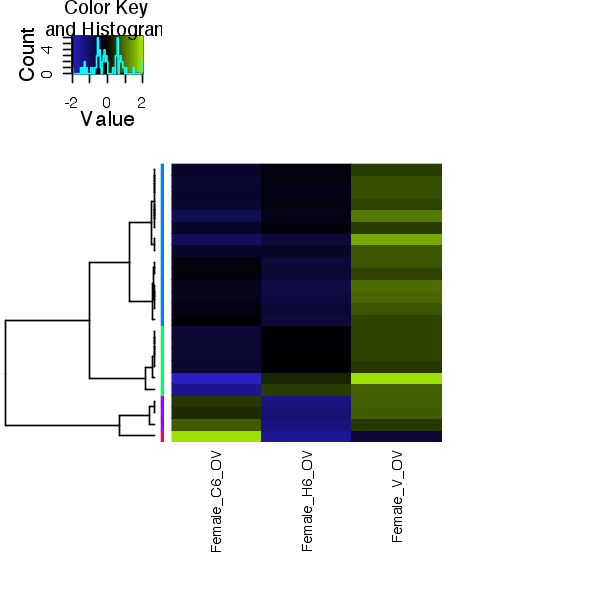

In [259]:
heatmap_data = data
heatmap_data[heatmap_data < -2] = -2
heatmap_data[heatmap_data > 2] = 2
options(repr.plot.width = 5, repr.plot.height = 5)
heatmap.3(heatmap_data, dendrogram = "row", Rowv=as.dendrogram(hc_genes), Colv = c("V_RT", "C3_RT", "C6_RT", "C12_RT"),col=myheatcol, RowSideColors=gene_colors, scale="none", density.info="histogram", trace="none", key=TRUE, cexCol=1, margins=c(10,10), cexRow=0.5, labRow = F)

The cluster grouping (coloured bars on the left) seem to correspond well to overall grouping of gene expression profiles.

We'll loop over the cluster assignments and import them into the cluster list object:

In [260]:
cluster_list = list()
max_cluster_count = max(gene_partition_assignments)
for (i in 1:max_cluster_count) {
    partition_i = (gene_partition_assignments == i)
    partition_data = data[partition_i,,drop=F]
    cluster_list[[i]] = as.data.frame(partition_data)
    cluster_list[[i]]$Gene_ID = rownames(cluster_list[[i]])
    cluster_list[[i]]$cluster = paste("cluster_", i, sep = "")
}

#cluster_list
cluster_OV_data = rbindlist(cluster_list)

Now we'll generate a data frame with expression data for these clusters to make line plots of each cluster:

In [261]:
conSub = subset(cluster_OV_data, select = c("Gene_ID", "cluster", "Female_V_OV", "Female_C6_OV"))
hetSub = subset(cluster_OV_data, select = c("Gene_ID", "cluster", "Female_V_OV", "Female_H6_OV"))

df.conSub = melt(conSub, id.vars = c("Gene_ID", "cluster"))
df.conSub$condition <- ifelse(grepl("C", df.conSub$variable, ignore.case = F), "conspecific", ifelse(grepl("H", df.conSub$variable, ignore.case = F), "heterospecific", "virgin"))
df.conSub$time <- ifelse(grepl("6", df.conSub$variable), "6hpm", "virgin")
df.conSub$time = factor(df.conSub$time, levels = c("virgin", "6hpm"))
df.conSub$crossType = "conspecific"

df.hetSub = melt(hetSub, id.vars = c("Gene_ID", "cluster"))
df.hetSub$condition <- ifelse(grepl("C", df.hetSub$variable, ignore.case = F), "conspecific", ifelse(grepl("H", df.hetSub$variable, ignore.case = F), "heterospecific", "virgin"))
df.hetSub$time <- ifelse(grepl("6", df.hetSub$variable), "6hpm", "virgin")
df.hetSub$time = factor(df.hetSub$time, levels = c("virgin", "6hpm"))
df.hetSub$crossType = "heterospecific"

newSub = rbind(df.conSub, df.hetSub)

We can plot it like so:

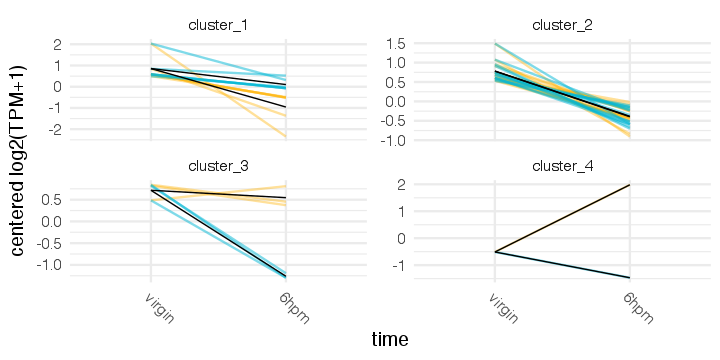

In [262]:
newSub$cluster = factor(newSub$cluster, levels = c("cluster_1", 
                                                   "cluster_2", 
                                                   "cluster_3",
                                                    "cluster_4"))
options(repr.plot.width = 6, repr.plot.height = 3)
# pdf("cluster_groupings.pdf", width = 5, height = 3)
ggplot() + 
    geom_line(data = subset(newSub, crossType == "conspecific"),
              aes(time, value, group = Gene_ID), 
              colour = "#ffb200",
              alpha = 0.4,
              size = 0.5) +
    geom_line(data = subset(newSub, crossType == "heterospecific"), 
              aes(time, value, group = Gene_ID), 
              colour = "#00b5d4",
              alpha = 0.5,
              size = 0.5) +
    theme_minimal() + 
    facet_wrap('cluster',scales='free_y', nrow = 2) +
    scale_color_hue(l=50,h.start=200) + 
    theme(axis.text.x=element_text(angle=-45,hjust=0)) +
    stat_summary(data = newSub, 
                 aes(x=time,y=value,group=crossType),
                 fun.data="mean_cl_boot",
                 color="black",
                 fill="black",
                 alpha=0.2,
                 size=0.3,
                 geom="smooth") +
    ylab("centered log2(TPM+1)")
# dev.off()

We can output the signficant GO results for those clusters here. First we'll make a factor level object:

In [263]:
cluster.factor.labeling = as.data.frame(unique(subset(newSub, select = c("Gene_ID", "cluster"))))
# here remove cluster 3 because it chokes the script:
cluster.factor.labeling = subset(cluster.factor.labeling, cluster != "cluster_3")

row.names(cluster.factor.labeling) <- cluster.factor.labeling$Gene_ID
cluster.factor.labeling = subset(cluster.factor.labeling, select = "cluster")
cluster.factor_list = unique(cluster.factor.labeling[,1])

In [264]:
GO_enriched_list = list()

invisible(suppressWarnings(suppressMessages(
for (feature_cat in cluster.factor_list) {
    message('Processing category: ', feature_cat)
    cat_genes_vec = as.integer(features_with_GO %in% rownames(cluster.factor.labeling)[cluster.factor.labeling$cluster == feature_cat])
    pwf$DEgenes = cat_genes_vec
    res = goseq(pwf,gene2cat=GO_info_listed)
    ## over-represented categories:
    pvals = res$over_represented_pvalue
    pvals[pvals > 1 -1e-10] = 1-1e-10
    q = qvalue(pvals)
    res$over_represented_FDR = q$qvalues
    go_enrich_factor = feature_cat
    enrich_result_table = res[res$over_represented_pvalue<=0.05,]
    descr = unlist(lapply(enrich_result_table$category, get_GO_term_descr))
    enrich_result_table$go_term = descr
    enrich_result_table$factor = go_enrich_factor
    GO_enriched_list[[feature_cat]] = enrich_result_table
}
)))
GO_enrichment_data = rbindlist(GO_enriched_list)
write.table(GO_enrichment_data, "Results/GO_analyses/GO_results-ovary_clusters_downregulated_genes_aBT2.txt", quote = F, sep = "\t", row.names = F)
unique(filter(GO_enrichment_data, over_represented_FDR < 0.05)$factor)

[1] "cluster_1" "cluster_2"

Let's look at GO enrichment across all upregulated genes:

In [265]:
cat_genes_vec = as.integer(features_with_GO %in% newSub$Gene_ID)
pwf$DEgenes = cat_genes_vec
res = goseq(pwf,gene2cat=GO_info_listed)
## over-represented categories:
pvals = res$over_represented_pvalue
pvals[pvals > 1 -1e-10] = 1-1e-10
q = qvalue(pvals)
res$over_represented_FDR = q$qvalues
enrich_result_table = res[res$over_represented_pvalue<=0.05,]
descr = unlist(lapply(enrich_result_table$category, get_GO_term_descr))
enrich_result_table$go_term = descr
write.table(enrich_result_table, "Results/GO_analyses/GO_results-ovary_downregulated_genes_aBT2.txt", quote = F, sep = "\t", row.names = F)

Using manually entered categories.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns


In [266]:
filter(enrich_result_table, over_represented_FDR < 0.05)

category   over_represented_pvalue under_represented_pvalue numDEInCat
1 GO:0000786 1.750628e-11            1.0000000                6         
2 GO:1990104 1.750628e-11            1.0000000                6         
3 GO:0044815 4.048483e-11            1.0000000                6         
4 GO:0032993 6.333735e-11            1.0000000                6         
5 GO:0005811 3.985119e-07            1.0000000                5         
6 GO:0031427 1.646832e-06            1.0000000                3         
7 GO:0044427 1.088265e-05            0.9999995                6         
  numInCat term                     ontology over_represented_FDR
1 109      nucleosome               CC       1.277958e-07        
2 109      DNA bending complex      CC       1.277958e-07        
3 113      DNA packaging complex    CC       1.970262e-07        
4 123      protein-DNA complex      CC       2.311813e-07        
5 147      lipid droplet            CC       1.163655e-03        
6  18      response to methotrexate BP       4.007292e-03        
7 462      chromosomal part         CC       2.269811e-02        
  go_term                    
1 CC nucleosome              
2 CC DNA bending complex     
3 CC DNA packaging complex   
4 CC protein-DNA complex     
5 CC lipid droplet           
6 BP response to methotrexate
7 CC chromosomal part

Let's look at these nucleosome genes:

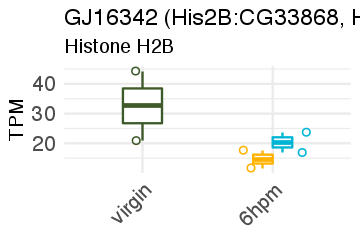

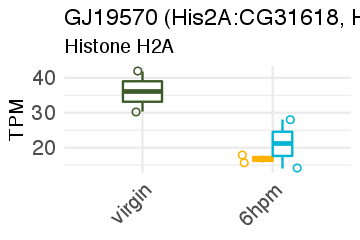

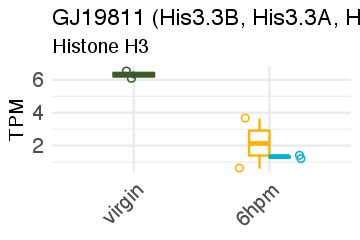

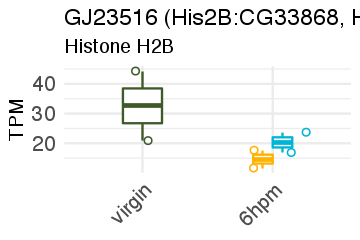

[[1]]

[[2]]

[[3]]

[[4]]

[[5]]

[[6]]


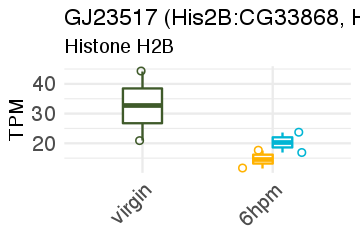

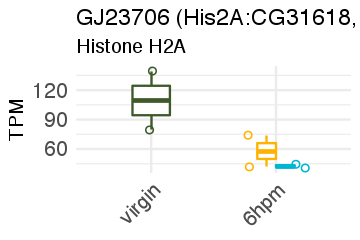

In [267]:
myList = as.character(extract_GO_genes(go_term = "GO:0000786", gene_set = newSub$Gene_ID))
options(repr.plot.width = 3, repr.plot.height =2)
lapply(myList, OV.geneBoxPlot, object = tpmTable_bt2.fbgn)

### Head post-mating contrasts:

Create H-specific count matrix 

In [268]:
counts_bt2.fbgn.H = subset(counts_bt2.fbgn, select=grepl("_H_", colnames(counts_bt2.fbgn)))
colnames(counts_bt2.fbgn.H) = gsub("Female_", "", colnames(counts_bt2.fbgn.H))

Now let's filter low expression genes within a minimum cpm of 2:

In [269]:
cpm_bt2.fbgn.H <- cpm(counts_bt2.fbgn.H)
thresh_H.bt2.fbgn <- cpm_bt2.fbgn.H > 5

countsKeep_H.bt2.fbgn <- rowSums(thresh_H.bt2.fbgn) >= 2
countsFiltered_bt2.fbgn.H <- counts_bt2.fbgn.H[countsKeep_H.bt2.fbgn,]
## Check how many genes remain in the matrix.
dim(countsFiltered_bt2.fbgn.H)

## Clean-up
rm(cpm_bt2.fbgn.H, countsKeep_H.bt2.fbgn, thresh_H.bt2.fbgn)

[1] 8477    6

We'll also subset the samplesInfo object to only include the RT samples:

In [270]:
sampleInfo.h = subset(sampleInfo, Tissue == "head")
sampleInfo.h$SampleName = gsub("Female_", "", sampleInfo.h$SampleName)
sampleInfo.h$Replicate = gsub("Female_", "", sampleInfo.h$Replicate)

#### Comparing each postmating time point to the head ovary sample:

Here we can set up new grouping and comparison matrix with all the postmating time-point samples by combining the "Status" and "time" factors:

In [271]:
## Will need to relevel the Status grouping to make virgin control
Status.time <- factor(paste(sampleInfo.h$Status, sampleInfo.h$Time, sep="."))
sampleInfo.h <- cbind(sampleInfo.h, Group=Status.time)
sampleInfo.h$Group <- relevel(sampleInfo.h$Group, ref = "virgin.virgin")

Next we need to set a different matrix where we test for differences between conspecific and heterospecific treatments of each time point:

In [272]:
groups.hb <- factor(sampleInfo.h$SampleName)
design.hb <- model.matrix(~ 0 + groups.hb)
colnames(design.hb) <- levels(groups.hb)
rownames(design.hb) <- sampleInfo.h$Replicate

Create edgeR DE object and run glmFit

In [273]:
dgeList.h <- DGEList(counts = countsFiltered_bt2.fbgn.H, group = groups.hb)
dgeList.h <- calcNormFactors(dgeList.h)
dgeList.h <- estimateCommonDisp(dgeList.h)
dgeList.h <- estimateTagwiseDisp(dgeList.h)
dgeList.h_fit <- glmFit(dgeList.h, design.hb)

Let's add the annotation information to this fit object:

In [274]:
# Extract annotation for genes in the fit object
ann.h = subset(Annots, FBgn_ID %in% rownames(dgeList.h_fit))
ann.h = subset(ann.h, select = c("FBgn_ID", "gene_name", "SwissProt_BlastX_Description"))
# convert factors to characters
ann.h = data.frame(lapply(ann.h, as.character), stringsAsFactors=FALSE)
# align the fit object's rownames with gene ID's
ann.h = ann.h[match(rownames(dgeList.h_fit), ann.h$FBgn_ID),]
# convert factors to characters, again
ann.h <- data.frame(lapply(ann.h, as.character), stringsAsFactors=FALSE)
# Rename "FBgn_ID" as "GeneID"
colnames(ann.h) = c ("GeneID", "gene_name", "SwissProt_BlastX_Description")
# Check that the fit rownames match the annotation file's gene ID's
table(ann.h$GeneID==rownames(dgeList.h_fit))
# Add the annotations to the fit object in the "genes" slot
dgeList.h_fit$genes = ann.h


TRUE 
8477 

Also, check the tagwise dispersion summary:

In [275]:
summary(dgeList.h$tagwise.dispersion)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.006917 0.009560 0.011153 0.014422 0.014254 0.868681 

Again, quick look at the BCV, mean-variance trend, qq-plot and normalized count distributions.

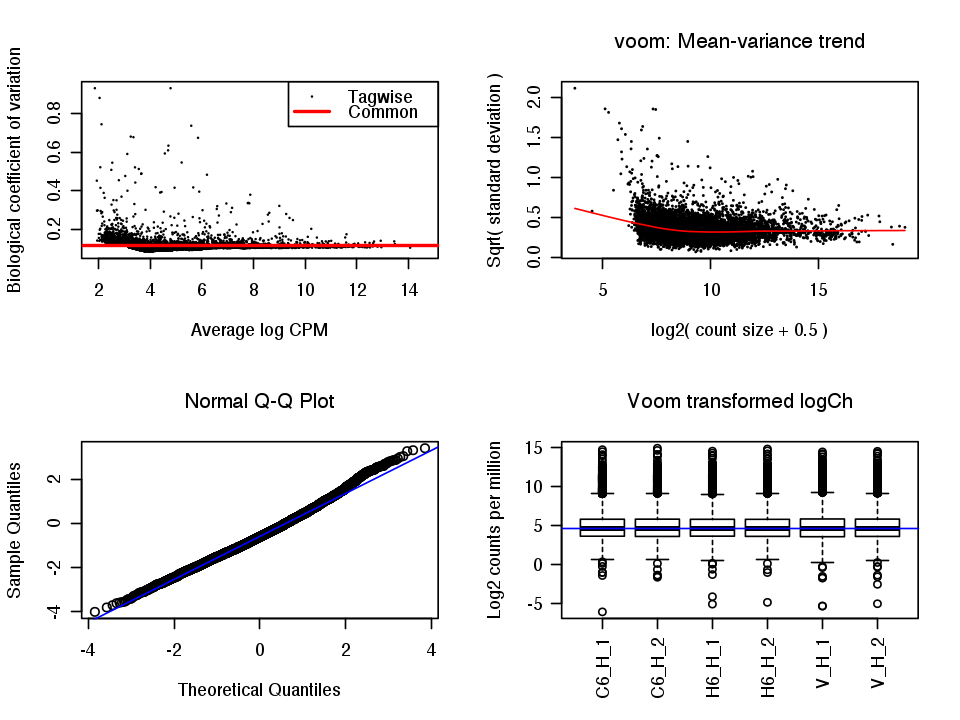

In [276]:
options(repr.plot.width = 8, repr.plot.height = 6)
par(mfrow=c(2,2))
# Biological coefficient of variation
plotBCV(dgeList.h)
# mean-variance trend
h.voom = voom(dgeList.h, design.hb, plot=TRUE)
# QQ-plot
g.h <- gof(dgeList.h_fit)
z.h <- zscoreGamma(g.h$gof.statistics,shape=g.h$df/2,scale=2)
qqnorm(z.h); qqline(z.h, col = 4,lwd=1,lty=1)
# log2 transformed and normalize boxplot of counts across samples
boxplot(h.voom$E, xlab="", ylab="Log2 counts per million",las=2,main="Voom transformed logCh")
abline(h=median(h.voom$E),col="blue")

And make an MDS plot with Limma:

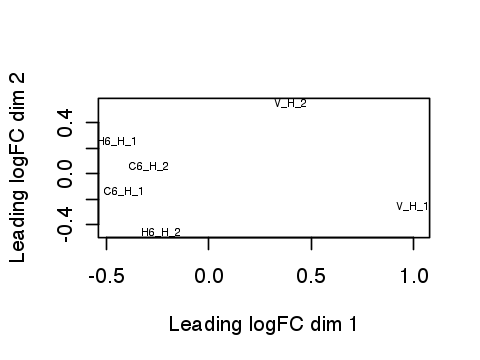

In [277]:
options(repr.plot.width = 4, repr.plot.height = 3)
plotMDS(dgeList.h, cex = 0.5)

Let's look at samples correlation:

In [278]:
sampleColLabeling = subset(sampleInfo.h, select = c("SampleName", "Replicate"))
sampleColLabeling = filter(sampleColLabeling, grepl("H", SampleName))
rownames(sampleColLabeling) = sampleColLabeling$Replicate
sampleColLabeling = subset(sampleColLabeling, select = SampleName)
colnames(sampleColLabeling) = "Sample"
sampleColLabeling$Sample = factor(sampleColLabeling$Sample, levels = c("V_H", "C6_H", "H6_H"))

Now plot it:

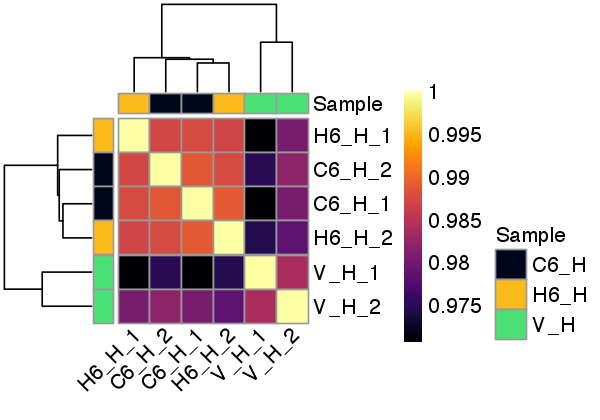

In [279]:
## Plot sample correlation
data = log2(countsFiltered_bt2.fbgn.H+1)
colnames(data) = gsub("Female_", "", colnames(data))
data = as.matrix(data)
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')

cor_colors <- list(Sample = c("#00071b","#fbbc1b","#4be177"))
names(cor_colors$Sample) <- unique(sampleColLabeling$Sample)

options(repr.plot.width = 5, repr.plot.height = 3.5)
pheatmap(
  mat               = sample_cor,
  color             = inferno(100),
#   border_color      = NA,
  annotation_col    = sampleColLabeling,
  annotation_row    = sampleColLabeling,
  drop_levels       = TRUE,
  annotation_colors = cor_colors,
  show_colnames     = TRUE,
  show_rownames     = TRUE,
  annotation_names_row = F,
#   filename          = "Figures/repTract_sample_correlations.pdf",
#   width             = 7, 
#   height            = 5,
  fontsize          = 12    
)

To perform pairwise differential expression tests between postmating samples and the virgin sample, we can run glmTreat by specifying the coefficient (have to look at the matrix), and only capture genes with >2-fold expression difference:

In [280]:
het.v.vir_h <- makeContrasts(hH.vs.vH=H6_H-V_H, levels=design.hb)
con.v.vir_h <- makeContrasts(hH.vs.cH=C6_H-V_H, levels=design.hb)
het.v.con_h <- makeContrasts(hH.vs.cH=H6_H-C6_H, levels=design.hb)
vir.v.PM_h <- makeContrasts(hH.vs.vH=H6_H-V_H, cH.vs.vH=C6_H-V_H, levels=design.hb)

Now we can fit the negative binomial log-linear model to conduct gene-wise statistical tests. For each contrast, we will extract the table with the relevant DE stats. Start with the contrast between the virgin samples and both post-mating samples:

In [281]:
lrt_h_vir.v.PM <- glmLRT(dgeList.h_fit, contrast = vir.v.PM_h)
lrt_h_vir.v.PM.tTags <- topTags(lrt_h_vir.v.PM, n = NULL)
lrt_h_vir.v.PM.tTags.table <- lrt_h_vir.v.PM.tTags$table

H_vir.v.PM.list_Het.up<-subset(lrt_h_vir.v.PM.tTags.table, logFC.hH.vs.vH > 1 & FDR<0.05)$GeneID
H_vir.v.PM.list_Het.down<-subset(lrt_h_vir.v.PM.tTags.table, logFC.hH.vs.vH < -1 & FDR<0.05)$GeneID

H_vir.v.PM.list_Con.up<-subset(lrt_h_vir.v.PM.tTags.table, logFC.cH.vs.vH > 1 & FDR<0.05)$GeneID
H_vir.v.PM.list_Con.down<-subset(lrt_h_vir.v.PM.tTags.table, logFC.cH.vs.vH < -1 & FDR<0.05)$GeneID

paste(length(H_vir.v.PM.list_Het.up), " genes are upregulated in the heterospecific cross, and ", length(H_vir.v.PM.list_Het.down), " are downregualted", sep = "")
paste(length(H_vir.v.PM.list_Con.up), " genes are upregulated in the conspecific cross, and ", length(H_vir.v.PM.list_Con.down), " are downregualted", sep = "")

[1] "55 genes are upregulated in the heterospecific cross, and 54 are downregualted"

[1] "52 genes are upregulated in the conspecific cross, and 49 are downregualted"

Now the individual comparisons between postmating samples and virgin:

In [282]:
lrt_h_het.v.vir <- glmLRT(dgeList.h_fit, contrast = het.v.vir_h)
lrt_h_het.v.vir.tTags <- topTags(lrt_h_het.v.vir, n = NULL)
lrt_h_het.v.vir.tTags.table <- lrt_h_het.v.vir.tTags$table

# let's make several lists with varying fold-change stringency (default is >2-fold)
H_het.v.vir.list_up<-subset(lrt_h_het.v.vir.tTags.table, logFC > 1 & FDR<0.05)$GeneID
H_het.v.vir.list_down<-subset(lrt_h_het.v.vir.tTags.table, logFC < -1 & FDR<0.05)$GeneID
H_het.v.vir.list <- union(H_het.v.vir.list_up, H_het.v.vir.list_down)

paste(length(H_het.v.vir.list_up), " genes are upregulated in the heterospecific cross, and ", length(H_het.v.vir.list_down), " are downregualted" ,sep = "")

[1] "53 genes are upregulated in the heterospecific cross, and 53 are downregualted"

In [283]:
lrt_h_con.v.vir <- glmLRT(dgeList.h_fit, contrast = con.v.vir_h)
lrt_h_con.v.vir.tTags <- topTags(lrt_h_con.v.vir, n = NULL)
lrt_h_con.v.vir.tTags.table <- lrt_h_con.v.vir.tTags$table

# let's make several lists with varying fold-change stringency (default is >2-fold)
H_con.v.vir.list_up<-subset(lrt_h_con.v.vir.tTags.table, logFC > 1 & FDR<0.05)$GeneID
H_con.v.vir.list_down<-subset(lrt_h_con.v.vir.tTags.table, logFC < -1 & FDR<0.05)$GeneID
H_con.v.vir.list <- union(H_con.v.vir.list_up, H_con.v.vir.list_down)

paste(length(H_con.v.vir.list_up), " genes are upregulated in the conspecific cross, and ", length(H_con.v.vir.list_down), " are downregualted" ,sep = "")

[1] "49 genes are upregulated in the conspecific cross, and 48 are downregualted"

In [284]:
lrt_h_het.v.con <- glmLRT(dgeList.h_fit, contrast = het.v.con_h)
lrt_h_het.v.con.tTags <- topTags(lrt_h_het.v.con, n = NULL)
lrt_h_het.v.con.tTags.table <- lrt_h_het.v.con.tTags$table

# let's make several lists with varying fold-change stringency (default is >2-fold)
H_het.v.con.list_up<-subset(lrt_h_het.v.con.tTags.table, logFC > 1 & FDR<0.05)$GeneID
H_het.v.con.list_down<-subset(lrt_h_het.v.con.tTags.table, logFC < -1 & FDR<0.05)$GeneID

paste(length(H_het.v.con.list_up), " genes are upregulated in the heterospecific cross, and ", length(H_het.v.con.list_down), " are downregualted" ,sep = "")

[1] "7 genes are upregulated in the heterospecific cross, and 3 are downregualted"

Now let's plot the fold-change values between the two postmating contrasts:

In [285]:
tmp.h.Data = lrt_h_vir.v.PM.tTags.table
tmp.h.Data$sig = ifelse(tmp.h.Data$GeneID %in% H_het.v.vir.list_up & tmp.h.Data$GeneID %in% H_con.v.vir.list_up,
                     "both upregulated",
                     ifelse(tmp.h.Data$GeneID %in% H_het.v.vir.list_down & tmp.h.Data$GeneID %in% H_con.v.vir.list_down,
                            "both downregulated",
                            ifelse(tmp.h.Data$GeneID %in% H_het.v.vir.list_up & tmp.h.Data$GeneID %in% H_con.v.vir.list_down,
                                   "het. up, con. down",
                                   ifelse(tmp.h.Data$GeneID %in% H_het.v.vir.list_down & tmp.h.Data$GeneID %in% H_con.v.vir.list_up,
                                          "het. down, con. up",
                                          ifelse(tmp.h.Data$GeneID %in% H_het.v.vir.list_up & tmp.h.Data$GeneID %!in% H_con.v.vir.list,
                                                 "het. up",
                                                 ifelse(tmp.h.Data$GeneID %in% H_het.v.vir.list_down & tmp.h.Data$GeneID %!in% H_con.v.vir.list,
                                                        "het. down",
                                                        ifelse(tmp.h.Data$GeneID %!in% H_het.v.vir.list & tmp.h.Data$GeneID %in% H_con.v.vir.list_up,
                                                               "con. up",
                                                               ifelse(tmp.h.Data$GeneID %!in% H_het.v.vir.list & tmp.h.Data$GeneID %in% H_con.v.vir.list_down,"con. down", "ns"))))))))
tmp.h.Data$Status = ifelse(tmp.h.Data$sig == "both downregulated" | tmp.h.Data$sig == "both upregulated", 
                        "normal", 
                        ifelse(tmp.h.Data$sig == "con. down" | tmp.h.Data$sig == "con. up", 
                               "conspecific", 
                               ifelse(tmp.h.Data$sig == "het. down" | tmp.h.Data$sig == "het. up", 
                                      "heterospecific", 
                                      ifelse(tmp.h.Data$sig == "het. down" & tmp.h.Data$sig == "con. up",
                                            "opposite",
                                            ifelse(tmp.h.Data$sig == "con. down" & tmp.h.Data$sig == "het. up",
                                                   "opposite",
                                                   "n.s.")))))
tmp.h.Data$Status = factor(tmp.h.Data$Status, levels = c("normal", "conspecific", "heterospecific", "opposite", "n.s."))
# tmp.h.Data = melt(tmp.h.Data, id.vars = c("GeneID", "gene_name", "SwissProt_BlastX_Description", "logCPM", "LR", "PValue", "FDR"))
head(tmp.h.Data, n = 2)
# rm(tmp.h.Data)

GeneID      gene_name
FBgn0209766 FBgn0209766 GJ22662  
FBgn0200873 FBgn0200873 GJ13652  
            SwissProt_BlastX_Description                                        
FBgn0209766 Attacin-A {ECO:0000303|PubMed:11592981, ECO:0000303|PubMed:11886771}
FBgn0200873 .                                                                   
            logFC.hH.vs.vH logFC.cH.vs.vH logCPM   LR       PValue      
FBgn0209766  2.644269       0.2547839     4.534921 245.7841 4.252721e-54
FBgn0200873 10.192045      10.4101395     2.307268 189.0152 9.033646e-42
            FDR          sig              Status        
FBgn0209766 3.605031e-50 het. up          heterospecific
FBgn0200873 3.828911e-38 both upregulated normal

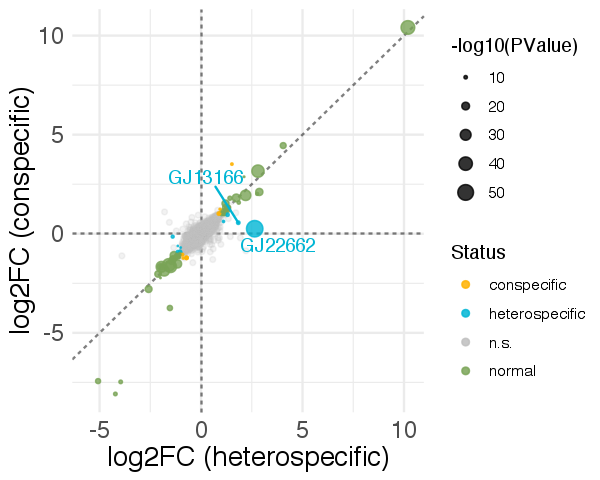

In [286]:
options(repr.plot.width = 5, repr.plot.height = 4)
ggplot() + 
        theme_minimal() +
        geom_vline(xintercept = 0, linetype = "dashed", alpha = 0.5) + 
        geom_hline(yintercept = 0, linetype = "dashed", alpha = 0.5) +
#         scale_colour_manual(values = c("#ffb200","#00b5d4","#ed1f34")) + 
#         geom_text_repel(data = filter(tmp.h.Data, Status == "heterospcific"), 
#                         aes(logFC.hH.vs.vH, logFC.cH.vs.vH, label = gene_name),
#                         force = 50) +
        geom_abline(intercept = 0, slope = 1, linetype = "dashed", alpha = 0.5)+
        geom_point(data = filter(tmp.h.Data, !grepl("rRNA", gene_name) & Status == "n.s."),
                   aes(logFC.hH.vs.vH, logFC.cH.vs.vH, colour = Status), 
                   size = 1, 
#                    colour = "gray",
                   alpha = 0.2) + 
        geom_point(data = filter(tmp.h.Data, !grepl("rRNA", gene_name) & Status != "n.s."),
                   aes(logFC.hH.vs.vH, logFC.cH.vs.vH, colour = Status, size = -log10(PValue)),
#                    size = 3,
                   alpha = 0.8) +
        geom_text_repel(data = filter(tmp.h.Data, Status == "heterospecific" & -log10(PValue) > 10), 
                        aes(logFC.hH.vs.vH, logFC.cH.vs.vH, label = gene_name, colour = Status),
                        force = 50,
                        show.legend = FALSE) +
        scale_size(range = c(-2,4)) + 
        theme(axis.text = element_text(size = 14, face = "bold"), axis.title = element_text(size = 16, face = "bold")) +
        labs(x = "log2FC (heterospecific)", y = "log2FC (conspecific)") +
        scale_colour_manual(values = c("#ffb200", "#00b5d4", "grey", "#7aa457"))

Let's combine the head and ovary point plots with faceting:

In [287]:
tmp.ov.Data$contrast = "Ovaries"
tmp.h.Data$contrast = "Head"
colnames(tmp.ov.Data) = gsub("logFC.hOV.vs.vOV", "logFC.het.vs.vir", colnames(tmp.ov.Data))
colnames(tmp.ov.Data) = gsub("logFC.cOV.vs.vOV", "logFC.con.vs.vir", colnames(tmp.ov.Data))
colnames(tmp.h.Data) = gsub("logFC.hH.vs.vH", "logFC.het.vs.vir", colnames(tmp.h.Data))
colnames(tmp.h.Data) = gsub("logFC.cH.vs.vH", "logFC.con.vs.vir", colnames(tmp.h.Data))
tmpData = rbind(tmp.ov.Data, tmp.h.Data)
tmpData = merge(tmpData, melOrthsAll, by.x = "GeneID", by.y = "FBgn_ID", all.x = T)
tmpData$Status = factor(tmpData$Status, levels = c("normal", "conspecific", "heterospecific", "n.s."))

Now make the plot:

Warning message:
"Removed 1 rows containing missing values (geom_text_repel)."

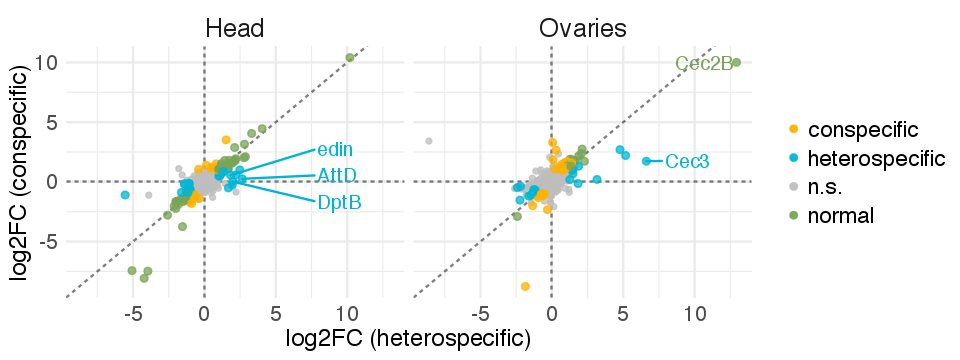

In [288]:
options(repr.plot.width = 8, repr.plot.height = 3)

x_limits <- c(7.5, NA)

# pdf("~/Dropbox/LaTeX.Projects/Ahmed-Braimah_and_Clark_2018/Figure_5.pdf", width = 8, height = 3)
ggplot() + 
        theme_minimal() +
        geom_vline(xintercept = 0, linetype = "dashed", alpha = 0.5) + 
        geom_hline(yintercept = 0, linetype = "dashed", alpha = 0.5) +
        geom_abline(intercept = 0, slope = 1, linetype = "dashed", alpha = 0.5)+
        geom_point(data = filter(tmpData, !grepl("rRNA", gene_name) & Status == "n.s."),
                   aes(logFC.het.vs.vir, logFC.con.vs.vir, colour = Status), 
                   size = 1, 
#                    colour = "gray",
                   alpha = 0.75) + 
        geom_point(data = filter(tmpData, !grepl("rRNA", gene_name) & Status != "n.s."),
                   aes(logFC.het.vs.vir, logFC.con.vs.vir, 
#                        size = -log10(FDR),
                       colour = Status),
#                    size = 3,
                   alpha = 0.75) +
        facet_grid(.~contrast) +
        geom_text_repel(data = filter(tmpData, grepl("Cec", gene_name) & contrast == "Ovaries"), 
                        aes(logFC.het.vs.vir, logFC.con.vs.vir, label = gene_name, colour = Status),
                        force = 50,
                        show.legend = FALSE,
                        size = 4,
                        xlim  = x_limits) +
        geom_text_repel(data = filter(tmpData, (contrast == "Head" & Status == "heterospecific" & -log10(PValue) > 5 & logFC.het.vs.vir > 1.31)), 
                        aes(logFC.het.vs.vir, logFC.con.vs.vir, label = mel_GeneSymbol, colour = Status),
                        force = 10,
                        show.legend = FALSE,
                        size = 4,
                        xlim  = x_limits) +
#           geom_label_repel(
#                         arrow = arrow(length = unit(0.03, "npc"), type = "closed", ends = "first"),
#                         force = 10,
#                         xlim  = x_limits) +
        scale_size(range = c(2,4)) + 
        theme(axis.text = element_text(size = 12, face = "bold"), 
              axis.title = element_text(size = 14, face = "bold"),
              strip.text = element_text(size = 15),
              legend.title = element_blank(),
              legend.text = element_text(size = 13)) +
        labs(x = "log2FC (heterospecific)", y = "log2FC (conspecific)") +
        scale_colour_manual(values = c("#ffb200", "#00b5d4", "grey", "#7aa457"))
# dev.off()

##### Analysis of upregulated genes in the female head:

First we'll look at those genes that are upregulated in the RT across all three postmating timepoints. We'll first generate a list of these genes and a TPM matrix for the conspecific condition samples:

In [289]:
H_upregulated_genes = unique(c(H_het.v.vir.list_up, H_con.v.vir.list_up))
message(paste("There are ", length(H_upregulated_genes), " upregulated genes", sep =""))
H_upregulated_genes_matrix = subset(tpmMatrix_bt2.fbgn, rownames(tpmMatrix_bt2.fbgn) %in% H_upregulated_genes)

H_upregulated_genes_matrix = H_upregulated_genes_matrix[ , grepl("_H$", names(H_upregulated_genes_matrix))]
H_upregulated_genes_matrix_con = subset(H_upregulated_genes_matrix, select = c("Female_V_H", "Female_C6_H"))
H_upregulated_genes_matrix_het = subset(H_upregulated_genes_matrix, select = c("Female_V_H", "Female_H6_H"))

There are 63 upregulated genes


We can perform clustering of these genes by expression profile across the conspecific samples. We'll first need to estimate an appropriate number of clusters.

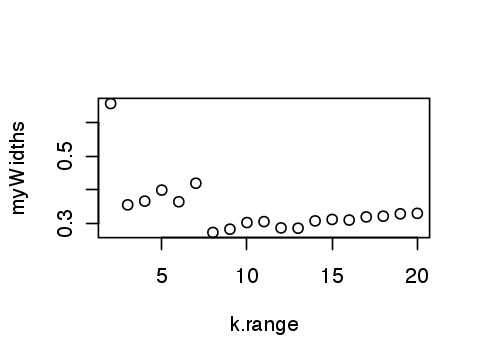

In [290]:
options(repr.plot.width = 4, repr.plot.height = 3)
findK(H_upregulated_genes_matrix)

Cruedly, it looks like 3 clusters will aproopriately represent groupings of this gene set. We'll re-examine this after performing the analysis. First we'll run the cluster analysis:

In [291]:
data = H_upregulated_genes_matrix
data = log2(data+1)
data = as.matrix(data) # convert to matrix
data = t(scale(t(data), scale=F))
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')
sample_dist = as.dist(1-sample_cor)
hc_samples = hclust(sample_dist, method='complete')
gene_cor = NULL
if (is.null(gene_cor)) { gene_cor = cor(t(data), method='pearson', use='pairwise.complete.obs') }
gene_dist = as.dist(1-gene_cor)
hc_genes = hclust(gene_dist, method='complete')
gene_partition_assignments <- cutree(as.hclust(hc_genes), k=5)

## can also be done by tree height:
#gene_partition_assignments <- cutree(as.hclust(hc_genes), h=50/100*max(hc_genes$height))

Here we'll just generate some color parameters for each cluster:

In [292]:
partition_colors = rainbow(length(unique(gene_partition_assignments)), start=0.4, end=0.95)
gene_colors_dframe = data.frame(clusters=gene_partition_assignments, colors=partition_colors[gene_partition_assignments])
gene_colors = as.matrix(partition_colors[gene_partition_assignments])

Now we can plot a heatmap of these genes with their cluster identification:

for plotting:: min.raw: -2 max.raw: 2


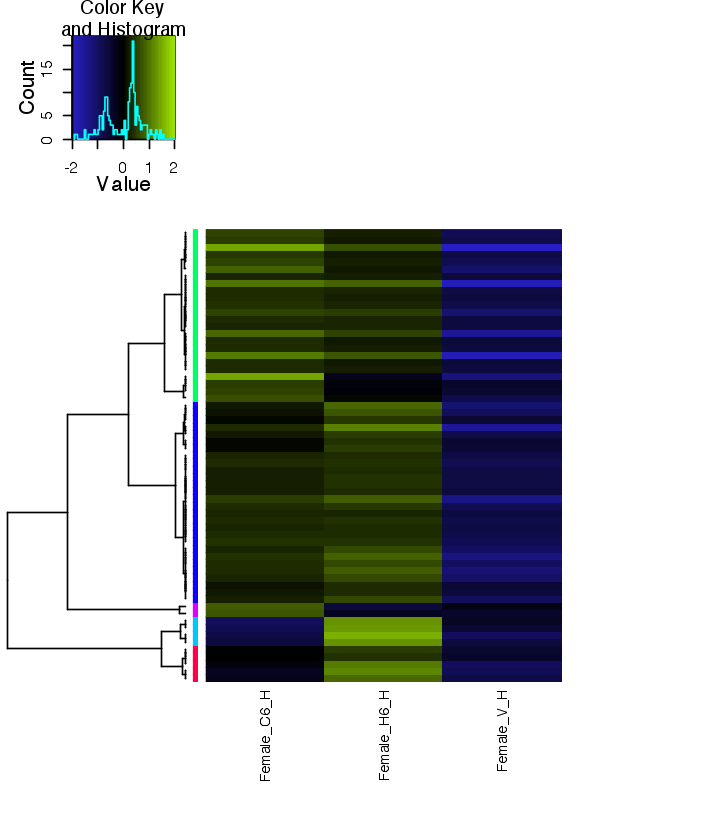

In [293]:
heatmap_data = data
heatmap_data[heatmap_data < -2] = -2
heatmap_data[heatmap_data > 2] = 2
options(repr.plot.width = 6, repr.plot.height = 7)
heatmap.3(heatmap_data, dendrogram = "row", Rowv=as.dendrogram(hc_genes), Colv = c("V_RT", "C3_RT", "C6_RT", "C12_RT"),col=myheatcol, RowSideColors=gene_colors, scale="none", density.info="histogram", trace="none", key=TRUE, cexCol=1, margins=c(10,10), cexRow=0.5, labRow = F)

The cluster grouping (coloured bars on the left) seem to correspond well to overall grouping of gene expression profiles.

We'll loop over the cluster assignments and import them into the cluster list object:

In [294]:
cluster_list = list()
max_cluster_count = max(gene_partition_assignments)
for (i in 1:max_cluster_count) {
    partition_i = (gene_partition_assignments == i)
    partition_data = data[partition_i,,drop=F]
    cluster_list[[i]] = as.data.frame(partition_data)
    cluster_list[[i]]$Gene_ID = rownames(cluster_list[[i]])
    cluster_list[[i]]$cluster = paste("cluster_", i, sep = "")
}

#cluster_list
cluster_H_data = rbindlist(cluster_list)

Now we'll generate a data frame with expression data for these clusters to make line plots of each cluster:

In [295]:
conSub = subset(cluster_H_data, select = c("Gene_ID", "cluster", "Female_V_H", "Female_C6_H"))
hetSub = subset(cluster_H_data, select = c("Gene_ID", "cluster", "Female_V_H", "Female_H6_H"))

df.conSub = melt(conSub, id.vars = c("Gene_ID", "cluster"))
df.conSub$condition <- ifelse(grepl("C", df.conSub$variable, ignore.case = F), "conspecific", ifelse(grepl("H", df.conSub$variable, ignore.case = F), "heterospecific", "virgin"))
df.conSub$time <- ifelse(grepl("6", df.conSub$variable), "6hpm", "virgin")
df.conSub$time = factor(df.conSub$time, levels = c("virgin", "6hpm"))
df.conSub$crossType = "conspecific"

df.hetSub = melt(hetSub, id.vars = c("Gene_ID", "cluster"))
df.hetSub$condition <- ifelse(grepl("C", df.hetSub$variable, ignore.case = F), "conspecific", ifelse(grepl("H", df.hetSub$variable, ignore.case = F), "heterospecific", "virgin"))
df.hetSub$time <- ifelse(grepl("6", df.hetSub$variable), "6hpm", "virgin")
df.hetSub$time = factor(df.hetSub$time, levels = c("virgin", "6hpm"))
df.hetSub$crossType = "heterospecific"

newSub = rbind(df.conSub, df.hetSub)

We can plot it like so:

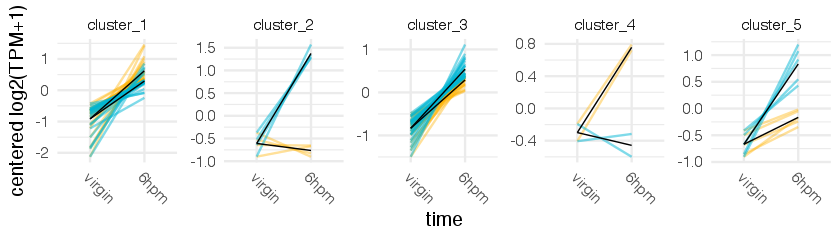

In [296]:
newSub$cluster = factor(newSub$cluster, levels = c(unique(newSub$cluster)))
options(repr.plot.width = 7, repr.plot.height = 2)
# pdf("cluster_groupings.pdf", width = 5, height = 3)
ggplot() + 
    geom_line(data = subset(newSub, crossType == "conspecific"),
              aes(time, value, group = Gene_ID), 
              colour = "#ffb200",
              alpha = 0.4,
              size = 0.5) +
    geom_line(data = subset(newSub, crossType == "heterospecific"), 
              aes(time, value, group = Gene_ID), 
              colour = "#00b5d4",
              alpha = 0.5,
              size = 0.5) +
    theme_minimal() + 
    facet_wrap('cluster',scales='free_y', nrow = 1) +
    scale_color_hue(l=50,h.start=200) + 
    theme(axis.text.x=element_text(angle=-45,hjust=0)) +
    stat_summary(data = newSub, 
                 aes(x=time,y=value,group=crossType),
                 fun.data="mean_cl_boot",
                 color="black",
                 fill="black",
                 alpha=0.2,
                 size=0.3,
                 geom="smooth") +
    ylab("centered log2(TPM+1)")
# dev.off()

We can output the signficant GO results for those clusters here. First we'll make a factor level object:

In [297]:
cluster.factor.labeling = as.data.frame(unique(subset(newSub, select = c("Gene_ID", "cluster"))))
row.names(cluster.factor.labeling) <- cluster.factor.labeling$Gene_ID
cluster.factor.labeling = subset(cluster.factor.labeling, select = "cluster")
cluster.factor_list = unique(cluster.factor.labeling[,1])

In [298]:
GO_enriched_list = list()

invisible(suppressWarnings(suppressMessages(
for (feature_cat in cluster.factor_list) {
    message('Processing category: ', feature_cat)
    cat_genes_vec = as.integer(features_with_GO %in% rownames(cluster.factor.labeling)[cluster.factor.labeling$cluster == feature_cat])
    pwf$DEgenes = cat_genes_vec
    res = goseq(pwf,gene2cat=GO_info_listed)
    ## over-represented categories:
    pvals = res$over_represented_pvalue
    pvals[pvals > 1 -1e-10] = 1-1e-10
    q = qvalue(pvals)
    res$over_represented_FDR = q$qvalues
    go_enrich_factor = feature_cat
    enrich_result_table = res[res$over_represented_pvalue<=0.05,]
    descr = unlist(lapply(enrich_result_table$category, get_GO_term_descr))
    enrich_result_table$go_term = descr
    enrich_result_table$factor = go_enrich_factor
    GO_enriched_list[[feature_cat]] = enrich_result_table
}
)))
GO_enrichment_data = rbindlist(GO_enriched_list)
write.table(GO_enrichment_data, "Results/GO_analyses/GO_results-head_clusters_upregulated_genes_aBT2.txt", quote = F, sep = "\t", row.names = F)
unique(filter(GO_enrichment_data, over_represented_FDR < 0.05)$factor)

[1] "cluster_1" "cluster_2"

In [239]:
filter(GO_enrichment_data, over_represented_FDR < 0.05)

category   over_represented_pvalue under_represented_pvalue numDEInCat
1  GO:0044710 2.587079e-06            0.9999997                15        
2  GO:0008336 6.450088e-06            1.0000000                 2        
3  GO:0006578 1.195236e-05            1.0000000                 2        
4  GO:0045329 1.195236e-05            1.0000000                 2        
5  GO:0016491 1.269527e-05            0.9999989                 8        
6  GO:0042742 2.307521e-08            1.0000000                 4        
7  GO:0009617 3.618491e-08            1.0000000                 4        
8  GO:0098542 7.744032e-08            1.0000000                 4        
9  GO:0045087 1.108508e-07            1.0000000                 4        
10 GO:0051707 2.652479e-07            1.0000000                 4        
11 GO:0006955 4.136435e-07            1.0000000                 4        
12 GO:0043207 4.747533e-07            1.0000000                 4        
13 GO:0009607 4.879914e-07            1.0000000                 4        
14 GO:0006952 1.208626e-06            1.0000000                 4        
15 GO:0002376 1.772505e-06            1.0000000                 4        
16 GO:0051704 5.791836e-06            1.0000000                 4        
17 GO:0019731 6.436601e-06            1.0000000                 2        
18 GO:0005576 1.206786e-05            1.0000000                 4        
19 GO:0009605 1.323619e-05            1.0000000                 4        
   numInCat term                                     ontology
1  2507     NA                                       NA      
2     3     gamma-butyrobetaine dioxygenase activity MF      
3     4     amino-acid betaine biosynthetic process  BP      
4     4     carnitine biosynthetic process           BP      
5   700     oxidoreductase activity                  MF      
6   147     defense response to bacterium            BP      
7   163     response to bacterium                    BP      
8   186     defense response to other organism       BP      
9   189     innate immune response                   BP      
10  245     response to other organism               BP      
11  249     immune response                          BP      
12  279     response to external biotic stimulus     BP      
13  282     response to biotic stimulus              BP      
14  342     defense response                         BP      
15  347     immune system process                    BP      
16  512     multi-organism process                   BP      
17   18     antibacterial humoral response           BP      
18  738     extracellular region                     CC      
19  615     response to external stimulus            BP      
   over_represented_FDR go_term                                     factor   
1  0.0370701846         none                                        cluster_1
2  0.0370701846         MF gamma-butyrobetaine dioxygenase activity cluster_1
3  0.0370701846         BP amino-acid betaine biosynthetic process  cluster_1
4  0.0370701846         BP carnitine biosynthetic process           cluster_1
5  0.0370701846         MF oxidoreductase activity                  cluster_1
6  0.0002641498         BP defense response to bacterium            cluster_2
7  0.0002641498         BP response to bacterium                    cluster_2
8  0.0003768762         BP defense response to other organism       cluster_2
9  0.0004046053         BP innate immune response                   cluster_2
10 0.0007745239         BP response to other organism               cluster_2
11 0.0008905843         BP immune response                          cluster_2
12 0.0008905843         BP response to external biotic stimulus     cluster_2
13 0.0008905843         BP response to biotic stimulus              cluster_2
14 0.0019606601         BP defense response                         cluster_2
15 0.0025878572         BP immune system process                    cluster_2
16 0.0076873459         BP multi-or

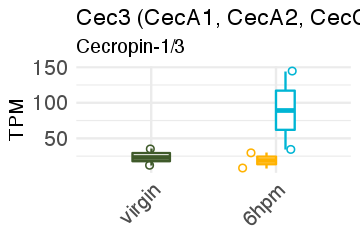

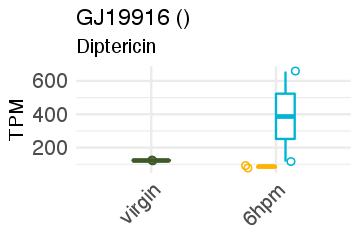

[[1]]

[[2]]

[[3]]

[[4]]


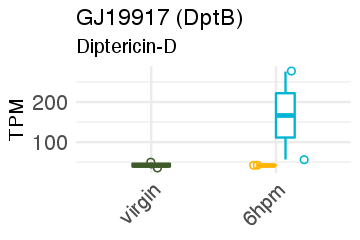

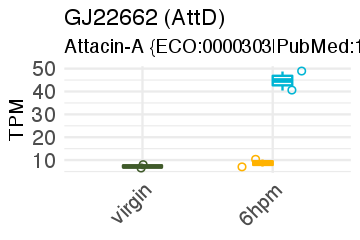

In [301]:
myList = as.character(extract_GO_genes(go_term = "GO:0009605", gene_set = rownames(subset(cluster.factor.labeling, cluster == "cluster_2"))))
options(repr.plot.width = 3, repr.plot.height = 2)
lapply(myList, H.geneBoxPlot, object = tpmTable_bt2.fbgn)

Let's look at GO enrichment across all upregulated genes:

In [302]:
cat_genes_vec = as.integer(features_with_GO %in% newSub$Gene_ID)
pwf$DEgenes = cat_genes_vec
res = goseq(pwf,gene2cat=GO_info_listed)
## over-represented categories:
pvals = res$over_represented_pvalue
pvals[pvals > 1 -1e-10] = 1-1e-10
q = qvalue(pvals)
res$over_represented_FDR = q$qvalues
enrich_result_table = res[res$over_represented_pvalue<=0.05,]
descr = unlist(lapply(enrich_result_table$category, get_GO_term_descr))
enrich_result_table$go_term = descr
write.table(enrich_result_table, "Results/GO_analyses/GO_results-head_upregulated_genes_aBT2.txt", quote = F, sep = "\t", row.names = F)

Using manually entered categories.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns


In [303]:
filter(enrich_result_table, over_represented_FDR < 0.05)

category over_represented_pvalue under_represented_pvalue numDEInCat
     numInCat term ontology over_represented_FDR go_term

No enrichment there.

##### Analysis of downregulated genes in the female head:

First we'll look at those genes that are upregulated in the RT across all three postmating timepoints. We'll first generate a list of these genes and a TPM matrix for the conspecific condition samples:

In [304]:
H_downregulated_genes = unique(c(H_het.v.vir.list_down, H_con.v.vir.list_down))
message(paste("There are ", length(H_downregulated_genes), " downregulated genes", sep =""))
H_downregulated_genes_matrix = subset(tpmMatrix_bt2.fbgn, rownames(tpmMatrix_bt2.fbgn) %in% H_downregulated_genes)

H_downregulated_genes_matrix = H_downregulated_genes_matrix[ , grepl("_H$", names(H_downregulated_genes_matrix))]
H_downregulated_genes_matrix_con = subset(H_downregulated_genes_matrix, select = c("Female_V_H", "Female_C6_H"))
H_downregulated_genes_matrix_het = subset(H_downregulated_genes_matrix, select = c("Female_V_H", "Female_H6_H"))

There are 65 downregulated genes


We can perform clustering of these genes by expression profile across the conspecific samples. We'll first need to estimate an appropriate number of clusters.

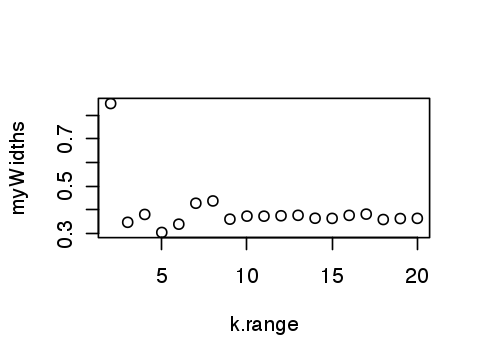

In [305]:
options(repr.plot.width = 4, repr.plot.height = 3)
findK(H_downregulated_genes_matrix)

Cruedly, it looks like 3 clusters will aproopriately represent groupings of this gene set. We'll re-examine this after performing the analysis. First we'll run the cluster analysis:

In [306]:
data = H_downregulated_genes_matrix
data = log2(data+1)
data = as.matrix(data) # convert to matrix
data = t(scale(t(data), scale=F))
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')
sample_dist = as.dist(1-sample_cor)
hc_samples = hclust(sample_dist, method='complete')
gene_cor = NULL
if (is.null(gene_cor)) { gene_cor = cor(t(data), method='pearson', use='pairwise.complete.obs') }
gene_dist = as.dist(1-gene_cor)
hc_genes = hclust(gene_dist, method='complete')
gene_partition_assignments <- cutree(as.hclust(hc_genes), k=4)

## can also be done by tree height:
#gene_partition_assignments <- cutree(as.hclust(hc_genes), h=50/100*max(hc_genes$height))

Here we'll just generate some color parameters for each cluster:

In [307]:
partition_colors = rainbow(length(unique(gene_partition_assignments)), start=0.4, end=0.95)
gene_colors_dframe = data.frame(clusters=gene_partition_assignments, colors=partition_colors[gene_partition_assignments])
gene_colors = as.matrix(partition_colors[gene_partition_assignments])

Now we can plot a heatmap of these genes with their cluster identification:

for plotting:: min.raw: -2 max.raw: 2


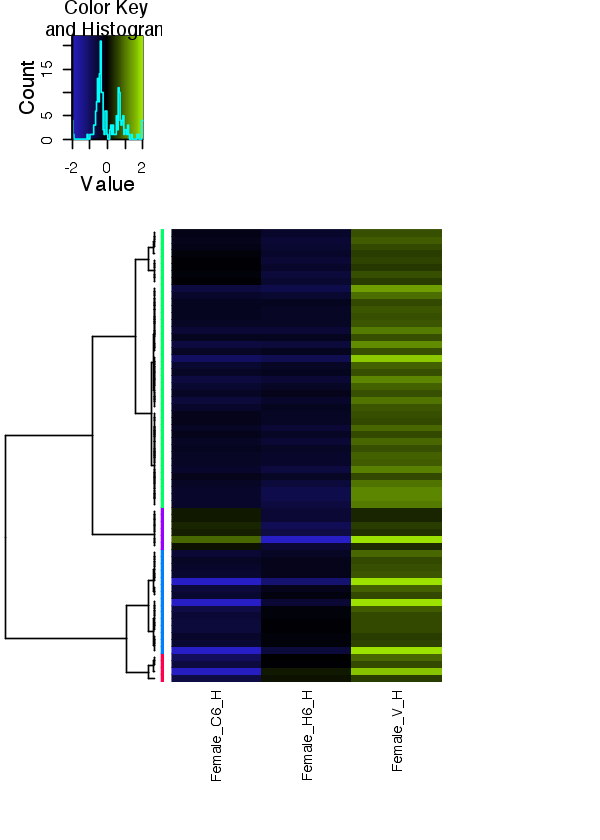

In [308]:
heatmap_data = data
heatmap_data[heatmap_data < -2] = -2
heatmap_data[heatmap_data > 2] = 2
options(repr.plot.width = 5, repr.plot.height = 7)
heatmap.3(heatmap_data, dendrogram = "row", Rowv=as.dendrogram(hc_genes), Colv = c("V_RT", "C3_RT", "C6_RT", "C12_RT"),col=myheatcol, RowSideColors=gene_colors, scale="none", density.info="histogram", trace="none", key=TRUE, cexCol=1, margins=c(10,10), cexRow=0.5, labRow = F)

The cluster grouping (coloured bars on the left) seem to correspond well to overall grouping of gene expression profiles.

We'll loop over the cluster assignments and import them into the cluster list object:

In [309]:
cluster_list = list()
max_cluster_count = max(gene_partition_assignments)
for (i in 1:max_cluster_count) {
    partition_i = (gene_partition_assignments == i)
    partition_data = data[partition_i,,drop=F]
    cluster_list[[i]] = as.data.frame(partition_data)
    cluster_list[[i]]$Gene_ID = rownames(cluster_list[[i]])
    cluster_list[[i]]$cluster = paste("cluster_", i, sep = "")
}

#cluster_list
cluster_H_data = rbindlist(cluster_list)

Now we'll generate a data frame with expression data for these clusters to make line plots of each cluster:

In [310]:
conSub = subset(cluster_H_data, select = c("Gene_ID", "cluster", "Female_V_H", "Female_C6_H"))
hetSub = subset(cluster_H_data, select = c("Gene_ID", "cluster", "Female_V_H", "Female_H6_H"))

df.conSub = melt(conSub, id.vars = c("Gene_ID", "cluster"))
df.conSub$condition <- ifelse(grepl("C", df.conSub$variable, ignore.case = F), "conspecific", ifelse(grepl("H", df.conSub$variable, ignore.case = F), "heterospecific", "virgin"))
df.conSub$time <- ifelse(grepl("6", df.conSub$variable), "6hpm", "virgin")
df.conSub$time = factor(df.conSub$time, levels = c("virgin", "6hpm"))
df.conSub$crossType = "conspecific"

df.hetSub = melt(hetSub, id.vars = c("Gene_ID", "cluster"))
df.hetSub$condition <- ifelse(grepl("C", df.hetSub$variable, ignore.case = F), "conspecific", ifelse(grepl("H", df.hetSub$variable, ignore.case = F), "heterospecific", "virgin"))
df.hetSub$time <- ifelse(grepl("6", df.hetSub$variable), "6hpm", "virgin")
df.hetSub$time = factor(df.hetSub$time, levels = c("virgin", "6hpm"))
df.hetSub$crossType = "heterospecific"

newSub = rbind(df.conSub, df.hetSub)

We can plot it like so:

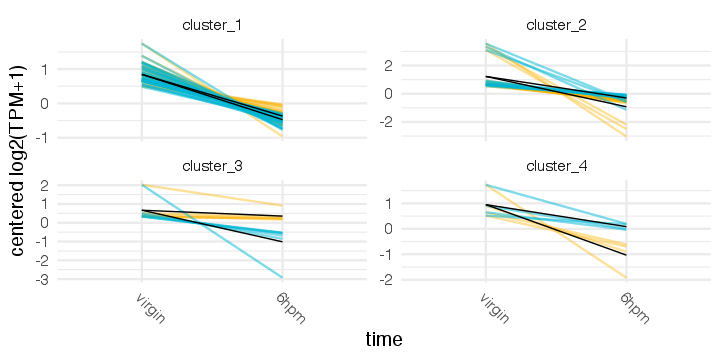

In [311]:
newSub$cluster = factor(newSub$cluster, levels = c("cluster_1", 
                                                   "cluster_2", 
                                                   "cluster_3",
                                                  "cluster_4"))
options(repr.plot.width = 6, repr.plot.height = 3)
# pdf("cluster_groupings.pdf", width = 5, height = 3)
ggplot() + 
    geom_line(data = subset(newSub, crossType == "conspecific"),
              aes(time, value, group = Gene_ID), 
              colour = "#ffb200",
              alpha = 0.4,
              size = 0.5) +
    geom_line(data = subset(newSub, crossType == "heterospecific"), 
              aes(time, value, group = Gene_ID), 
              colour = "#00b5d4",
              alpha = 0.5,
              size = 0.5) +
    theme_minimal() + 
    facet_wrap('cluster',scales='free_y', nrow = 2) +
    scale_color_hue(l=50,h.start=200) + 
    theme(axis.text.x=element_text(angle=-45,hjust=0)) +
    stat_summary(data = newSub, 
                 aes(x=time,y=value,group=crossType),
                 fun.data="mean_cl_boot",
                 color="black",
                 fill="black",
                 alpha=0.2,
                 size=0.3,
                 geom="smooth") +
    ylab("centered log2(TPM+1)")
# dev.off()

We can output the signficant GO results for those clusters here. First we'll make a factor level object:

In [312]:
cluster.factor.labeling = as.data.frame(unique(subset(newSub, select = c("Gene_ID", "cluster"))))
row.names(cluster.factor.labeling) <- cluster.factor.labeling$Gene_ID
cluster.factor.labeling = subset(cluster.factor.labeling, select = "cluster")
cluster.factor_list = unique(cluster.factor.labeling[,1])

In [313]:
GO_enriched_list = list()

invisible(suppressWarnings(suppressMessages(
for (feature_cat in cluster.factor_list) {
    message('Processing category: ', feature_cat)
    cat_genes_vec = as.integer(features_with_GO %in% rownames(cluster.factor.labeling)[cluster.factor.labeling$cluster == feature_cat])
    pwf$DEgenes = cat_genes_vec
    res = goseq(pwf,gene2cat=GO_info_listed)
    ## over-represented categories:
    pvals = res$over_represented_pvalue
    pvals[pvals > 1 -1e-10] = 1-1e-10
    q = qvalue(pvals)
    res$over_represented_FDR = q$qvalues
    go_enrich_factor = feature_cat
    enrich_result_table = res[res$over_represented_pvalue<=0.05,]
    descr = unlist(lapply(enrich_result_table$category, get_GO_term_descr))
    enrich_result_table$go_term = descr
    enrich_result_table$factor = go_enrich_factor
    GO_enriched_list[[feature_cat]] = enrich_result_table
}
)))
GO_enrichment_data = rbindlist(GO_enriched_list)
write.table(GO_enrichment_data, "Results/GO_analyses/GO_results-head_clusters_downregulated_genes_aBT2.txt", quote = F, sep = "\t", row.names = F)
unique(filter(GO_enrichment_data, over_represented_FDR < 0.05)$factor)

[1] "cluster_1"

In [314]:
filter(GO_enrichment_data, over_represented_FDR < 0.05)

category   over_represented_pvalue under_represented_pvalue numDEInCat
1  GO:0005996 1.473230e-09            1.0000000                 8        
2  GO:0044710 2.883375e-09            1.0000000                24        
3  GO:0016491 9.710339e-09            1.0000000                13        
4  GO:0019318 1.088179e-07            1.0000000                 6        
5  GO:0044712 7.076336e-07            0.9999999                10        
6  GO:0044723 7.332868e-07            0.9999999                 9        
7  GO:0046689 1.059141e-06            1.0000000                 3        
8  GO:0006012 1.945169e-06            1.0000000                 3        
9  GO:0055114 2.598518e-06            0.9999997                10        
10 GO:0005975 8.335325e-06            0.9999991                 9        
11 GO:0016646 1.223340e-05            0.9999999                 3        
12 GO:0019748 1.257412e-05            0.9999995                 5        
13 GO:0003824 2.104710e-05            0.9999960                25        
14 GO:0006006 2.519734e-05            0.9999993                 4        
15 GO:0055129 3.602344e-05            0.9999999                 2        
16 GO:0009404 4.895022e-05            0.9999993                 3        
17 GO:0009407 4.895022e-05            0.9999993                 3        
18 GO:0017143 4.895022e-05            0.9999993                 3        
19 GO:0046701 4.895022e-05            0.9999993                 3        
20 GO:0090487 4.895022e-05            0.9999993                 3        
21 GO:0042178 5.472339e-05            0.9999992                 3        
22 GO:0046680 6.874725e-05            0.9999989                 3        
23 GO:0016645 7.395256e-05            0.9999988                 3        
24 GO:0016614 7.518764e-05            0.9999954                 5        
   numInCat
1   121    
2  2507    
3   700    
4    80    
5   473    
6   346    
7     9    
8    11    
9   588    
10  466    
11   16    
12   92    
13 4142    
14   59    
15    4    
16   25    
17   25    
18   25    
19   25    
20   25    
21   26    
22   27    
23   28    
24  162    
   term                                                                                 
1  monosaccharide metabolic process                                                     
2  NA                                                                                   
3  oxidoreductase activity                                                              
4  hexose metabolic process                                                             
5  NA                                                                                   
6  NA                                                                                   
7  response to mercury ion                                                              
8  galactose metabolic process                                                          
9  oxidation-reduction process                                                          
10 carbohydrate metabolic process                                                       
11 oxidoreductase activity, acting on the CH-NH group of donors, NAD or NADP as acceptor
12 secondary metabolic process                                                          
13 catalytic activity                                                                   
14 glucose metabolic process                                                            
15 L-proline biosynthetic process                                                       
16 toxin metabolic process                                                              
17 toxin catabolic process                                                              
18 insecticide metabolic process                                                        
19 insecticide catabolic process                                                        
20 secondary metabolite catabolic process                                

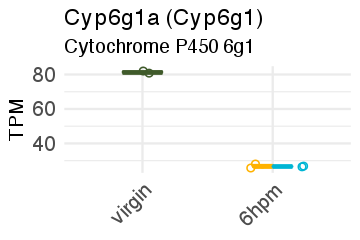

[[1]]

[[2]]

[[3]]


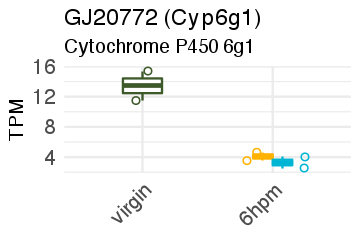

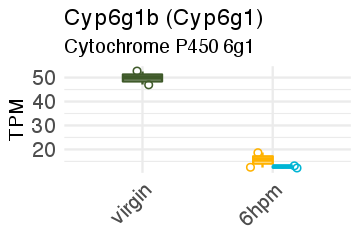

In [319]:
myList = as.character(extract_GO_genes(go_term = "GO:0046689", gene_set = rownames(subset(cluster.factor.labeling, cluster == "cluster_1"))))
options(repr.plot.width = 3, repr.plot.height = 2)
lapply(myList, H.geneBoxPlot, object = tpmTable_bt2.fbgn)

Let's look at GO enrichment across all upregulated genes:

In [320]:
cat_genes_vec = as.integer(features_with_GO %in% newSub$Gene_ID)
pwf$DEgenes = cat_genes_vec
res = goseq(pwf,gene2cat=GO_info_listed)
## over-represented categories:
pvals = res$over_represented_pvalue
pvals[pvals > 1 -1e-10] = 1-1e-10
q = qvalue(pvals)
res$over_represented_FDR = q$qvalues
enrich_result_table = res[res$over_represented_pvalue<=0.05,]
descr = unlist(lapply(enrich_result_table$category, get_GO_term_descr))
enrich_result_table$go_term = descr
write.table(enrich_result_table, "Results/GO_analyses/GO_results-head_downregulated_genes_aBT2.txt", quote = F, sep = "\t", row.names = F)

Using manually entered categories.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns


In [321]:
filter(enrich_result_table, over_represented_FDR < 0.05)

category   over_represented_pvalue under_represented_pvalue numDEInCat
1  GO:0016491 6.971625e-10            1.0000000                16        
2  GO:0044710 2.497315e-09            1.0000000                29        
3  GO:0005996 1.717783e-08            1.0000000                 8        
4  GO:0019318 6.514274e-07            1.0000000                 6        
5  GO:0055114 9.121310e-07            0.9999999                12        
6  GO:0015078 2.535838e-06            0.9999999                 6        
7  GO:0046689 2.562646e-06            1.0000000                 3        
8  GO:0006012 4.701368e-06            1.0000000                 3        
9  GO:0044723 9.812892e-06            0.9999989                 9        
10 GO:0044712 1.242137e-05            0.9999983                10        
11 GO:0005975 1.541648e-05            0.9999979                10        
12 GO:0016614 2.610279e-05            0.9999981                 6        
13 GO:0044711 2.719546e-05            0.9999952                12        
14 GO:1901564 2.898965e-05            0.9999949                12        
15 GO:0016646 2.941951e-05            0.9999997                 3        
16 GO:0045263 3.228882e-05            0.9999996                 3        
17 GO:0044281 4.512711e-05            0.9999906                14        
18 GO:0009127 4.836352e-05            0.9999983                 4        
19 GO:0009168 4.836352e-05            0.9999983                 4        
20 GO:0019748 5.303404e-05            0.9999969                 5        
21 GO:0055129 6.448469e-05            0.9999999                 2        
22 GO:0019637 6.989604e-05            0.9999897                 9        
   numInCat
1   700    
2  2507    
3   121    
4    80    
5   588    
6   149    
7     9    
8    11    
9   346    
10  473    
11  466    
12  162    
13  779    
14  770    
15   16    
16   30    
17 1087    
18   68    
19   68    
20   92    
21    4    
22  457    
   term                                                                                 
1  oxidoreductase activity                                                              
2  NA                                                                                   
3  monosaccharide metabolic process                                                     
4  hexose metabolic process                                                             
5  oxidation-reduction process                                                          
6  proton transmembrane transporter activity                                            
7  response to mercury ion                                                              
8  galactose metabolic process                                                          
9  NA                                                                                   
10 NA                                                                                   
11 carbohydrate metabolic process                                                       
12 oxidoreductase activity, acting on CH-OH group of donors                             
13 NA                                                                                   
14 organonitrogen compound metabolic process                                            
15 oxidoreductase activity, acting on the CH-NH group of donors, NAD or NADP as acceptor
16 proton-transporting ATP synthase complex, coupling factor F(o)                       
17 small molecule metabolic process                                                     
18 purine nucleoside monophosphate biosynthetic process                                 
19 purine ribonucleoside monophosphate biosynthetic process                             
20 secondary metabolic process                                                          
21 L-proline biosynthetic process                                                       
22 organophosphate metabolic process                               

## Analysis of transferred mRNAs

We'll examine the transfer of mRNAs from heterospecific males to females by capturing genes that are upregulated at 3hpm. The majority of those are shared between the two conditions, but the heterospecific condition has more. So the union of both lists will suffice (73 in het alone, and 76 in the combined).

First we'll output the genes the are upregulated at 3hpm in both conspecific and heterospecific conditions. 

In [322]:
upAT3hpm.het.matrix = subset(tpmMatrix_bt2.fbgn, rownames(tpmMatrix_bt2.fbgn) %in% union(DE.genes_H3.v.vir_up, DE.genes_C3.v.vir_up))
transfer.candidates = subset(upAT3hpm.het.matrix, Female_H3_RT > Female_V_RT & Female_H6_RT < Female_H3_RT)
colnames(transfer.candidates) = gsub("Female_", "", colnames(transfer.candidates))
transfer.candidates.male = subset(transfer.candidates, select = grepl("Male", colnames(transfer.candidates)))
transfer.candidates.RT = subset(transfer.candidates, select = grepl("RT", colnames(transfer.candidates)))
transfer.candidates = cbind(transfer.candidates.male, transfer.candidates.RT)
transfer.candidates.list = rownames(transfer.candidates)

Here we'll extract their transcript IDs, since that's what the mapping was against:

In [323]:
transfer.candidates.list.FBtr = filter(FBgn_to_FBtr, FBgn_ID %in% transfer.candidates.list)$FBtr

Write this out to a file:

In [324]:
write.table(transfer.candidates.list.FBtr, file = "Results/transferred.mRNA.candidates.IDs.FBtr.list", quote = F, row.names = F, col.names = F)

We can make a heatmap of those genes:

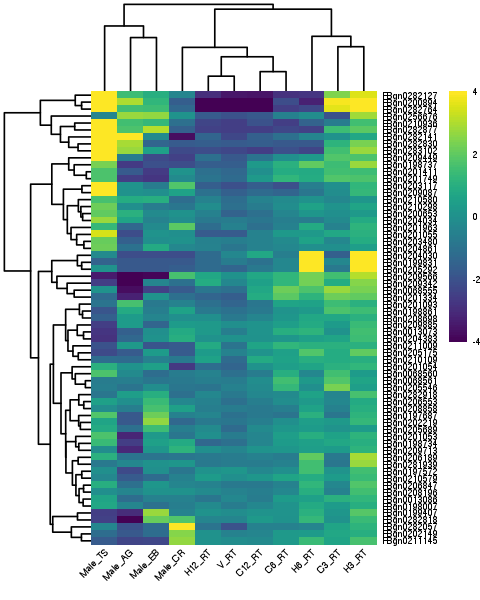

In [325]:
data = log2(transfer.candidates+1)
data = t(scale(t(data), scale=F))
data[data < -4] = -4
data[data > 4] = 4

options(repr.plot.width = 4, repr.plot.height = 5)
# pdf("Figures/tissue-biased_heatmap.pdf", width = 4, height = 5)
pheatmap(
  mat               = data,
  color             = viridis(100),
#   breaks            = mat_breaks,
  border_color      = NA,
#   labels_col        = c("carcass", "head", "ovaries", "rep. tract"),
  show_colnames     = TRUE,
  show_rownames     = TRUE,
#   annotation_row    = virgin.factor.labeling,
#   annotation_colors = mat_colors,
#   drop_levels       = TRUE,
#   annotation_names_row = F,
#   main              = "Default Heatmap",
#   filename          = "Figures/tissue-biased_heatmap.pdf",
#   width             = 4, 
#   height            = 5,
  fontsize          = 5    
)
# dev.off()

We'll use a SNP analysis comparing the conspecific and heterospecific samples to identify whether these are indeed transferred transcripts. To do this, we can use the dvir1.06 genome mapping and the _de novo_ transcriptome. For the latter, we'll output the corresponding PASA sequences from our Blast results, and also perform a DE test between 3hpm and virgin RT samples. First we'll output the homolg list:

In [326]:
transfer.candidates.gene_ids = unique(filter(geneID_to_fbgn, ref_gene_id %in% transfer.candidates.list)$gene_id)
transfer.candidates.transcript_ids = unique(filter(gene.features, gene_id %in% transfer.candidates.gene_ids)$transcript_id)
pasa.orthologs = as.character(unique(subset(pasa_v_annotated_blast, sseqid %in% transfer.candidates.transcript_ids)$qseqid))

For the DE test we need to do several things. First we'll create an RT-specific count matrix:

In [327]:
counts_bt2.pasa.RT = subset(counts_bt2.pasa, select=grepl("RT", colnames(counts_bt2.pasa)))
colnames(counts_bt2.pasa.RT) = gsub("Female_", "", colnames(counts_bt2.pasa.RT))
# counts_bt2.pasa.RT = subset(counts_bt2.pasa.RT, select=RT_GoodReps)

Now let's filter low expression genes within a minimum cpm of 5:

In [328]:
cpm_bt2.pasa.RT <- cpm(counts_bt2.pasa.RT)
thresh_RT.bt2.pasa <- cpm_bt2.pasa.RT > 5

countsKeep_RT.bt2.pasa <- rowSums(thresh_RT.bt2.pasa) >= 3
countsFiltered_bt2.pasa.RT <- counts_bt2.pasa.RT[countsKeep_RT.bt2.pasa,]

## Clean-up
rm(cpm_bt2.pasa.RT, countsKeep_RT.bt2.pasa, thresh_RT.bt2.pasa)

Create edgeR DE object and run glmFit

In [329]:
dgeList.pmv <- DGEList(counts = countsFiltered_bt2.pasa.RT, group = groups.pmv)
dgeList.pmv <- calcNormFactors(dgeList.pmv)
dgeList.pmv <- estimateCommonDisp(dgeList.pmv)
dgeList.pmv <- estimateTagwiseDisp(dgeList.pmv)
dgeList.pmv_fit <- glmFit(dgeList.pmv, design.pmv)

Now we'll run the contrasts between the 3hpm samples and the virgin sample:

In [330]:
glmT_C3.v.vir <- glmTreat(dgeList.pmv_fit, coef =3, lfc =1)
glmT_H3.v.vir <- glmTreat(dgeList.pmv_fit, coef =6, lfc =1)

Extract gene list of DE genes, first upregulated ones....

In [331]:
DE.genes_C3.v.vir_up <- rownames(subset(topTags(glmT_C3.v.vir, n = NULL)$table, FDR < 0.05 & logFC > 1))
DE.genes_H3.v.vir_up <- rownames(subset(topTags(glmT_H3.v.vir, n = NULL)$table, FDR < 0.05 & logFC > 1))

We'll capture the union of those two gene lists:

In [332]:
transfer.candidates.list.pasa = union(DE.genes_C3.v.vir_up, DE.genes_H3.v.vir_up)

We'll look at the overlap between the homology-based list and the DE-based list. First we'll get the PASA gene names:

In [333]:
transfer.candidates.list.pasa.transcripts = unique(filter(pasa_trans_map, V1 %in% transfer.candidates.list.pasa)$V2)

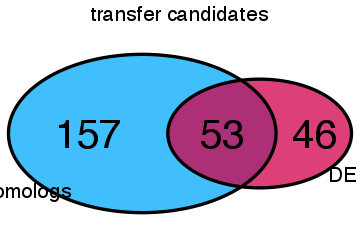

In [334]:
transCand.pasa_candidates <- list(DE = transfer.candidates.list.pasa.transcripts, homologs = pasa.orthologs)

transCand.pasa_Vdiag<-venn.diagram(transCand.pasa_candidates, NULL, fill=c("#d1004b", "#01aafb"), alpha=c(0.75,0.75), cex = 2, cat.fontface= 6, cat.cex = 1, resolution = 1000)

transCand.pasa_combs <- unlist(lapply(1:length(transCand.pasa_candidates), function(j) combn(names(transCand.pasa_candidates), j, simplify = FALSE)), recursive = FALSE)
names(transCand.pasa_combs) <- sapply(transCand.pasa_combs, function(i) paste0(i, collapse = ","))
    
transCand.pasa_elements <- lapply(transCand.pasa_combs, function(i) Setdiff(transCand.pasa_candidates[i], transCand.pasa_candidates[setdiff(names(transCand.pasa_candidates), i)]))
    
options(repr.plot.width = 3, repr.plot.height = 2)
grid.arrange(gTree(children=transCand.pasa_Vdiag), top = "transfer candidates")

Write the list to a file:

In [335]:
write.table(unlist(transCand.pasa_elements), file = "Results/transferred.mRNA.candidates.IDs.pasa.list", quote = F, row.names = F, col.names = F)

Output individual gene plots for all transferred candidates:

In [336]:
# candidate_transferred_genome = suppressMessages(lapply(transfer.candidates.list, 
#                                                        geneBoxPlot, 
#                                                        object = filter(tpmTable_bt2.fbgn, Tissue == "repTract" | Sex == "male")))
# ggsave("Trinity/pasa/transferred_transcripts/plots/candidate_transferred_genome.pdf", marrangeGrob(grobs = candidate_transferred_genome, nrow = 3, ncol =1))

In [337]:
# candidate_transferred_pasa = suppressMessages(lapply(unique(filter(pasa_trans_map, V2 %in% unlist(transCand.pasa_elements))$V1), 
#                                                        geneBoxPlot, 
#                                                        object = filter(tpmTable_bt2.pasa, Tissue == "repTract" | Sex == "male")))
# ggsave("Trinity/pasa/transferred_transcripts/plots/candidate_transferred_pasa.pdf", marrangeGrob(grobs = candidate_transferred_pasa, nrow = 3, ncol =1))

##### Analysis of VCF output:

First load the VCF files for the genome and pasa analyses, and the SNPs inferred from the DNAseq data:

In [338]:
genome.vcf = read.csv("Trinity/pasa/transferred_transcripts/candidate.male-transferred.mRNAs.FBtr.mrg/all_cat_merged_simplified.vcf", header = T, sep = "\t")
pasa.vcf = read.csv("Trinity/pasa/transferred_transcripts/candidate.male-transferred.mRNAs.pasa.mrg/all_cat_merged_simplified.vcf", header = T, sep = "\t")
exon.vcf = read.csv("Trinity/pasa/transferred_transcripts/candidate.male-transferred.mRNAs.FBtr.mrg/alignemnts/eXon.SNPs.vcf", header = T, sep = "\t")

add SNP ID and base character to the exon SNP object:

In [339]:
exon.vcf$SNP_id = paste(exon.vcf$CHROM, exon.vcf$POS, sep = "_")

Now we subset the relevant columns:

In [340]:
info.fields = subset(genome.vcf, select = c("CHROM", "POS","REF", "ALT", "QUAL", "DP"))
genotypes = subset(genome.vcf, select = c('C3_RT.bam.GT', 'H3_RT.bam.GT'))
colnames(genotypes) = gsub(".bam.GT", "", colnames(genotypes))
genome.vcf.data = cbind(info.fields, genotypes)
genome.vcf.data$SNP_id = paste(genome.vcf.data$CHROM, genome.vcf.data$POS, sep = "_")
genome.vcf.data = filter(genome.vcf.data, QUAL > 20)
# write.table(genome.vcf.data, "Trinity/pasa/transferred_transcripts/genome.transfer_candidates_subset.vcf", quote = F, sep = "\t", row.names = F)

Now merge the exon and genome results:

In [341]:
merged.vcf = merge(genome.vcf.data, exon.vcf, by.x = "SNP_id", by.y = "SNP_id", all.x = T)

Now output the candidate transferred mRNAs for the exon analysis:

In [342]:
exon.transfer.candidates = unique(filter(merged.vcf, as.character(C3_RT) != as.character(H3_RT) & !is.na(CHROM.y) & Dnov_4 != 1)$CHROM.x)

Also format the pasa vcf data:

In [343]:
info.fields = subset(pasa.vcf, select = c("CHROM", "POS","REF", "ALT", "QUAL", "DP"))
genotypes = subset(pasa.vcf, select = c('C3_RT.bam.GT', 'H3_RT.bam.GT'))
colnames(genotypes) = gsub(".bam.GT", "", colnames(genotypes))
pasa.vcf.data = cbind(info.fields, genotypes)
pasa.vcf.data$SNP_id = paste(pasa.vcf.data$CHROM, pasa.vcf.data$POS, sep = "_")
pasa.vcf.data = filter(pasa.vcf.data, QUAL > 20)
nrow(pasa.vcf.data)
head(pasa.vcf.data)
# write.table(pasa.vcf.data, "Trinity/pasa/transferred_transcripts/pasa.transfer_candidates_subset.vcf", quote = F, sep = "\t", row.names = F)

[1] 1686

CHROM       POS REF ALT QUAL     DP   C3_RT H3_RT SNP_id         
1 asmbl_10050 428 C   T    20.4535 1293 1/1   1/1   asmbl_10050_428
2 asmbl_10050 432 G   C    51.0000 1387 1/1   1/1   asmbl_10050_432
3 asmbl_10050 473 C   T   178.0000 3415 1/1   1/1   asmbl_10050_473
4 asmbl_10051 106 C   T    44.4146 1076 ./.   1/1   asmbl_10051_106
5 asmbl_10051 110 G   C    44.4146 1076 ./.   1/1   asmbl_10051_110
6 asmbl_10051 151 C   T    66.0000 1200 1/1   1/1   asmbl_10051_151

Make an object of SNPs with missing information:

In [344]:
genome.bad.SNPs = filter(genome.vcf.data, C3_RT == "./." | H3_RT == "./.")$SNP_id
pasa.bad.SNPs = filter(pasa.vcf.data, C3_RT == "./." | H3_RT == "./.")$SNP_id

Now we'll subset the VCF object to only include SNPs that are different between the con- and heterospecific samples:

In [345]:
filter(genome.vcf.data, SNP_id %!in% genome.bad.SNPs & as.character(C3_RT) != as.character(H3_RT))
genome.transfer.candidates = unique(filter(genome.vcf.data, SNP_id %!in% genome.bad.SNPs & as.character(C3_RT) != as.character(H3_RT))$CHROM)

CHROM       POS REF ALT QUAL     DP   C3_RT H3_RT SNP_id         
1  FBtr0229759 478 C   T    93.0000 1047 0/1   1/1   FBtr0229759_478
2  FBtr0229759 492 G   T    64.0000  996 0/1   1/1   FBtr0229759_492
3  FBtr0230684  88 C   A,G  44.4182   90 1/1   2/2   FBtr0230684_88 
4  FBtr0232780 966 T   C   228.0000 3381 1/1   0/1   FBtr0232780_966
5  FBtr0237898 332 A   G   110.0000  553 1/1   0/1   FBtr0237898_332
6  FBtr0237898 350 G   A   114.0000  437 1/1   0/1   FBtr0237898_350
7  FBtr0237898 370 A   G   136.0000  400 1/1   0/1   FBtr0237898_370
8  FBtr0237898 452 G   A   120.0000  462 1/1   0/1   FBtr0237898_452
9  FBtr0237898 470 G   C    93.0000  520 1/1   0/1   FBtr0237898_470
10 FBtr0237898 678 G   A,T 102.0000  173 1/1   2/2   FBtr0237898_678
11 FBtr0239841 258 C   A    57.0000 1455 0/1   1/1   FBtr0239841_258
12 FBtr0438285 208 G   A   225.0000  672 1/1   0/1   FBtr0438285_208
13 FBtr0438285 220 A   G,C 225.0000  652 1/1   2/1   FBtr0438285_220
14 FBtr0438285 261 G   A   225.0000  706 1/1   0/1   FBtr0438285_261
15 FBtr0438285 351 C   T   159.0000  461 1/1   0/1   FBtr0438285_351
16 FBtr0438285 447 C   A   157.0000  354 1/1   0/1   FBtr0438285_447
17 FBtr0438285 594 C   T   218.0000  597 1/1   0/1   FBtr0438285_594
18 FBtr0438285 600 T   C   226.0000  582 1/1   0/1   FBtr0438285_600
19 FBtr0441509 204 G   C    30.4183  118 1/1   0/1   FBtr0441509_204
20 FBtr0444653 215 T   C   192.0000  641 1/1   0/1   FBtr0444653_215
21 FBtr0444653 504 C   T    30.4183   15 1/1   0/1   FBtr0444653_504

combine both result candidates:

In [346]:
combined.transfer.candidates = union(exon.transfer.candidates, genome.transfer.candidates)

Extract their gene names:

In [347]:
combined.transfer.candidates.FBgn = filter(FBgn_to_FBtr, FBtr_ID %in% combined.transfer.candidates)$FBgn

Make a heatmap of those genes:

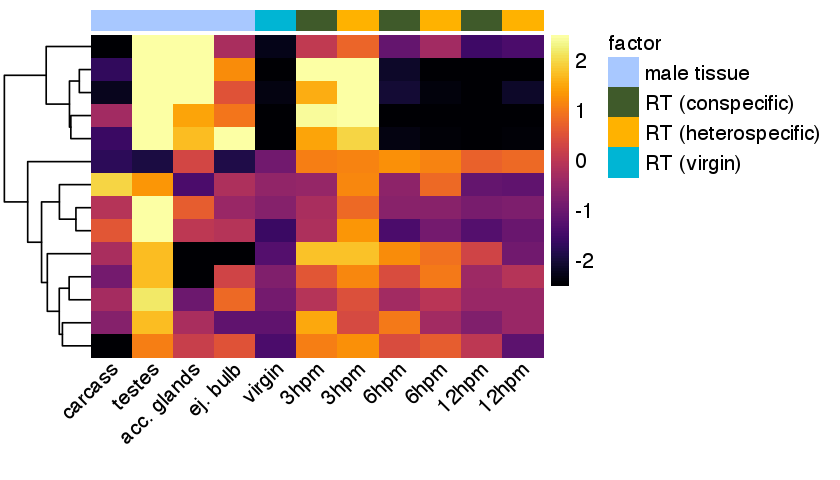

In [348]:
tmp = data.frame(sample = colnames(data))
tmp$factor = ifelse(grepl("Male", tmp$sample), "male tissue", ifelse(grepl("^C", tmp$sample), "RT (conspecific)", ifelse(grepl("^H", tmp$sample), "RT (heterospecific)", "RT (virgin)")))
rownames(tmp) = tmp$sample
tmp = subset(tmp, select = "factor")

mat_colors <- list(factor = c("#a8c8ff","#3f5a2a","#ffb200","#00b5d4"))
names(mat_colors$factor) <- unique(tmp$factor)

data = subset(transfer.candidates, rownames(transfer.candidates) %in% combined.transfer.candidates.FBgn)
col.order <- c("Male_CR","Male_TS","Male_AG","Male_EB","V_RT","C3_RT","H3_RT","C6_RT","H6_RT","C12_RT","H12_RT")
data = data[,col.order]
# colnames(data) <- c("carcass","Male_TS","Male_AG","Male_EB","V_RT","C3_RT","C6_RT","C12_RT","H3_RT","H6_RT","H12_RT")
data = log2(data+1)
data = t(scale(t(data), scale=F))
data[data < -2.5] = -2.5
data[data > 2.5] = 2.5

options(repr.plot.width = 7, repr.plot.height = 4)
# pdf("Figures/transferred_mRNAs_heatmap.pdf", width = 7, height = 4)
pheatmap(
  mat               = data,
  color             = inferno(100),
#   breaks            = mat_breaks,
  border_color      = NA,
  labels_col        = c("carcass","testes","acc. glands","ej. bulb","virgin","3hpm","3hpm","6hpm","6hpm","12hpm","12hpm"),
  show_colnames     = TRUE,
  show_rownames     = FALSE,
cluster_cols = F,
  annotation_col    = tmp,
  annotation_colors = mat_colors,
  drop_levels       = TRUE,
  annotation_names_col = F,
#   main              = "Default Heatmap",
#   filename          = "Figures/transferred_mRNAs_heatmap.pdf",
#   width             = 7, 
#   height            = 4,
  fontsize          = 12    
)
# dev.off()

In [349]:
# candidate_transferred_genome = suppressMessages(lapply(as.character(combined.transfer.candidates.FBgn), 
#                                                        geneBoxPlot, 
#                                                        object = filter(tpmTable_bt2.fbgn, Tissue == "repTract" | Sex == "male")))
# ggsave("Trinity/pasa/transferred_transcripts/plots/candidate_transferred_combined.pdf", marrangeGrob(grobs = candidate_transferred_genome, nrow = 3, ncol =1))

#### Analysis of SPermathecal genes in _D. melanogaster_ and their virilis group orthologs:

We'll use the new FlyATlas2 data to make comparisons between the RT-biased genes and genes that respond to mating in the RT. First load all the releveant FlyAtlas2 files:

In [351]:
# load feature anotations:
transcript.features = read.table("~/Dropbox/RNAseq/FlyAtlas2/StringTie/features.txt", header = T)

# load transcript lengths
transcript.lengths = read.table("~/Dropbox/RNAseq/FlyAtlas2/StringTie/stringtie_transcript_lengths.txt", header = F, sep = "\t")
colnames(transcript.lengths) = c("transcript_id", "length")

# load annotations
annotation = read.csv("~/Dropbox/RNAseq/Axenic.PM/Annotoations/fbgn_annotation_ID_fb_2018_04_mod.tsv", header = T, check.names = F, sep ="\t")
FBgn_to_symbol = subset(annotation, select = c("gene_symbol", "primary_FBgn"))
# load gene snapshots
snapshots = read.csv("~/Dropbox/RNAseq/Axenic.PM/Annotoations/gene_snapshots_fb_2018_05.tsv", header = T, sep ="\t", quote = "")

# merge features with lengths:
transcript.features.lengths = merge(transcript.features, transcript.lengths, by.x = "transcript_id", by.y = "transcript_id", all.x = TRUE)
# Select only the length and gene_id columns
tmpMrge = as.data.table(subset(transcript.features.lengths, select = c("length", "gene_id")))
# For each gene ID entry, select the entry with largest value in the "length" column:
gene.lengths = tmpMrge[tmpMrge[, .I[which.max(length)], by=gene_id]$V1]
## order by geneID
gene.lengths = gene.lengths[order(gene_id),] 
# remove un-needed intermediate objects
rm(tmpMrge)

# load sample information from SRA table:
sample.info = read.table("~/Dropbox/RNAseq/FlyAtlas2/Misc/SraRunTable_FlyAtlas2_modified.txt", header = T, sep = "\t")
sample.info = filter(sample.info, RNA == "mRNA")
sample.info = select(sample.info, Library_Name, Replicate_Name, Sex, dev_stage, organism_part, Sample_Name)
sample.info$Library_Name = gsub("Female ", "", sample.info$Library_Name)
sample.info$Library_Name = gsub("Male ", "", sample.info$Library_Name)
sample.info$Library_Name = gsub("Larval ", "", sample.info$Library_Name)
sample.info$Sex = gsub("NA", "unknown", sample.info$Sex)

# load gene and transcript counts:
gene.counts = read.csv("~/Dropbox/RNAseq/FlyAtlas2/ballgown/gene_counts.csv", header = T, sep = ",", row.names = 1)
gene.counts = subset(gene.counts, rownames(gene.counts) %in% gene.lengths$gene_id)
gene.counts <- gene.counts[ order(row.names(gene.counts)), ]
transcript.counts = read.csv("~/Dropbox/RNAseq/FlyAtlas2/ballgown/transcript_counts.csv", header = T, sep = ",", row.names = 1)

# Make TPM tables:
gene.tpm <- apply(gene.counts, 2, function(x) tpm(x, gene.lengths$length))
gene.tpm = as.data.frame(gene.tpm)
    
# subset the transcript features to only include genes:
gene.features = unique(select(transcript.features, ref_gene_id, gene_name, gene_id, contig))

Make a melted version of the TPM table:

In [352]:
tmp.tpmMatrix<-gene.tpm
# colnames(tmp.tpmMatrix) <- sample.info$Sample_Name
tmp.tpmMatrix.m <- as.data.frame(melt(as.matrix(tmp.tpmMatrix)))
colnames(tmp.tpmMatrix.m) <- c("gene_id", "replicate_id", "TPM")
tmp.tpmMatrix.m <- merge(tmp.tpmMatrix.m, sample.info, by.x = "replicate_id", by.y = "Replicate_Name", all.x = T)
tpm.table <- merge(tmp.tpmMatrix.m, gene.features, by.x = "gene_id", by.y = "gene_id", )
rm(tmp.tpmMatrix.m)

tpm.table$Library_Name = factor(tpm.table$Library_Name, levels = c("Whole", "Carcass", "CNS","Head", "Eye", "Brain", "Salivary Gland", "Thoracicoabdominal Ganglion", "Trachea","Tubule", "Midgut", "Hindgut", "Crop", "FatBody","Ovary", "Virgin Spermatheca", "Mated Spermatheca", "Testis", "Accessory Glands", "Anal Pad"))

Read in the matrix file:

In [353]:
tpm.matrix_fa2 = read.csv("~/Dropbox/RNAseq/Axenic.PM/Annotoations/FlyAtlas2_meanTPM_table.txt", header = T, sep = "\t", row.names = 1)

Here's a single gene plot:

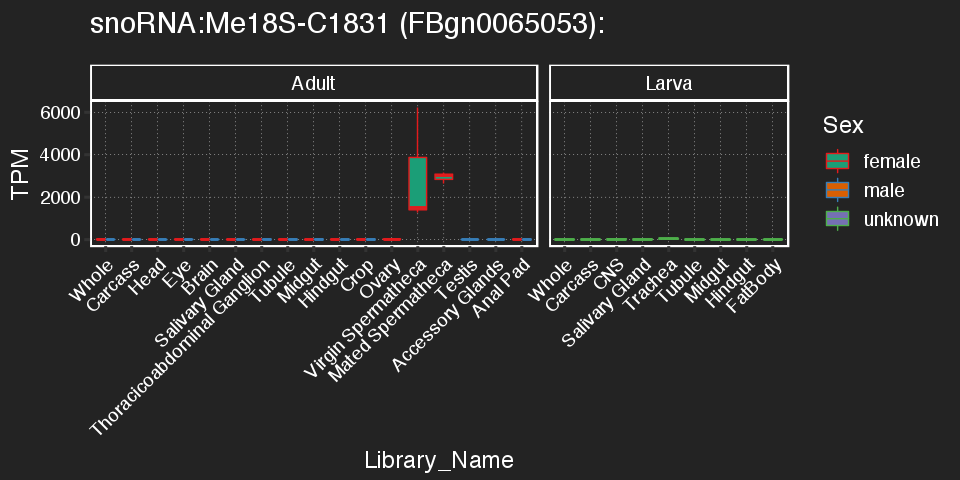

In [496]:
options(repr.plot.width = 8, repr.plot.height = 4)
geneBoxPlot_fa2(tpm.table, "snoRNA:Me18S-C1831")

##### Differential expression of Female spermathecal genes:

Filter:

In [567]:
fem.gene.counts = subset(gene.counts, select = !grepl("Female_Mated_Spermatheca", colnames(gene.counts)))
gene.CPM <- cpm(fem.gene.counts)
thresh <- gene.CPM > 5
keep <- rowSums(thresh) >= 3
counts.keep.fem <- fem.gene.counts[keep,]
dim(counts.keep.fem)

sp.gene.counts = subset(gene.counts, select = grepl("Spermatheca", colnames(gene.counts)))
gene.CPM <- cpm(sp.gene.counts)
thresh <- gene.CPM > 2
keep <- rowSums(thresh) >= 3
counts.keep.sp <- sp.gene.counts[keep,]
dim(counts.keep.sp)

[1] 12483   106

[1] 6109    6

Subset the samples file to only include the female samples:

In [568]:
sample.info.fem = subset(sample.info, Sample_Name != "Female_Mated_Spermatheca")
sample.info.fem$Spermatheca_status = ifelse(grepl("Spermatheca", sample.info.fem$Library_Name), "YES", "NO")

sample.info.sp = subset(sample.info, grepl("Spermatheca", Library_Name))

Define groups:

In [569]:
groups.sp = factor(sample.info.fem$Spermatheca_status)
design.sp = model.matrix( ~ 0 + groups.sp)
colnames(design.sp) <- levels(groups.sp)
rownames(design.sp) <- sample.info.fem$Replicate_Name

groups.spDE = factor(sample.info.sp$Sample_Name)
design.spDE = model.matrix( ~ 0 + groups.spDE)
colnames(design.spDE) <- levels(groups.spDE)
rownames(design.spDE) <- sample.info.sp$Replicate_Name

Fir the model:

In [570]:
dgeList.sp <- DGEList(counts = counts.keep.fem, group = groups.sp)
dgeList.sp <- calcNormFactors(dgeList.sp)
dgeList.sp <- estimateCommonDisp(dgeList.sp)
dgeList.sp <- estimateTagwiseDisp(dgeList.sp)
dgeList.sp_fit <- glmFit(dgeList.sp, design.sp)
summary(dgeList.sp$tagwise.dispersion)

dgeList.spDE <- DGEList(counts = counts.keep.sp, group = groups.spDE)
dgeList.spDE <- calcNormFactors(dgeList.spDE)
dgeList.spDE <- estimateCommonDisp(dgeList.spDE)
dgeList.spDE <- estimateTagwiseDisp(dgeList.spDE)
dgeList.spDE_fit <- glmFit(dgeList.spDE, design.spDE)
summary(dgeList.spDE$tagwise.dispersion)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.1662  0.4112  1.2457  3.2108  5.0315 20.8565 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.03065 0.03857 0.04647 0.05844 0.06148 0.81506 

Add annotation info:

In [571]:
ann = subset(gene.features, gene_id %in% rownames(dgeList.sp_fit))
ann = data.frame(lapply(ann, as.character), stringsAsFactors=FALSE)
ann = ann[match(rownames(dgeList.sp_fit), ann$gene_id),]
ann <- data.frame(lapply(ann, as.character), stringsAsFactors=FALSE)
ann <- subset(ann, select = c("gene_id", "gene_name", "ref_gene_id"))
colnames(ann) = c ("GeneID", "gene_name", "ref_gene_id")
table(ann$GeneID==rownames(dgeList.sp_fit))
dgeList.sp_fit$genes = ann

ann = subset(gene.features, gene_id %in% rownames(dgeList.spDE_fit))
ann = data.frame(lapply(ann, as.character), stringsAsFactors=FALSE)
ann = ann[match(rownames(dgeList.spDE_fit), ann$gene_id),]
ann <- data.frame(lapply(ann, as.character), stringsAsFactors=FALSE)
ann <- subset(ann, select = c("gene_id", "gene_name", "ref_gene_id"))
colnames(ann) = c ("GeneID", "gene_name", "ref_gene_id")
table(ann$GeneID==rownames(dgeList.spDE_fit))
dgeList.spDE_fit$genes = ann


 TRUE 
12483 


TRUE 
6109 

Look at QC sats:

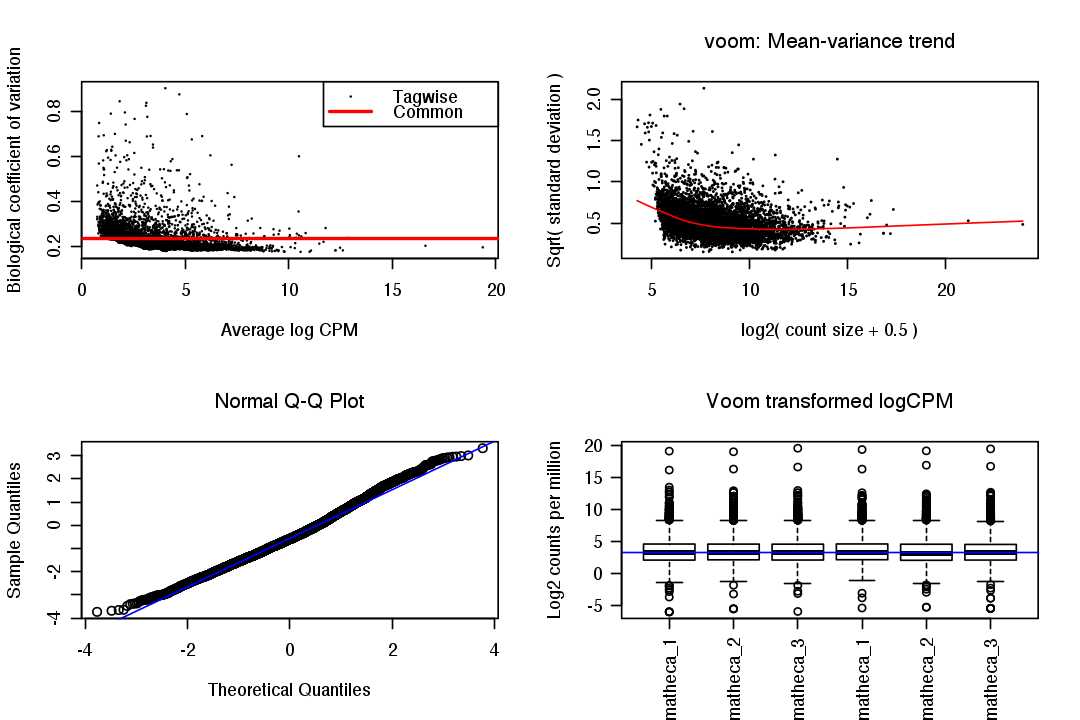

In [572]:
options(repr.plot.width = 9, repr.plot.height = 6)
par(mfrow=c(2,2))
# Biological coefficient of variation
plotBCV(dgeList.spDE)
# mean-variance trend
voom = voom(dgeList.spDE, design.spDE, plot=TRUE)
# QQ-plot
g.v <- gof(dgeList.spDE_fit)
z.v <- zscoreGamma(g.v$gof.statistics,shape=g.v$df/2,scale=2)
qqnorm(z.v); qqline(z.v, col = 4,lwd=1,lty=1)
# log2 transformed and normalize boxplot of counts across samples
boxplot(voom$E, xlab="", ylab="Log2 counts per million",las=2,main="Voom transformed logCPM")
abline(h=median(voom$E),col="blue")

rm(voom, g.v, z.v)

Set up contrasts:

In [573]:
Sp_contrasts <- makeContrasts(Female_Mated_Spermatheca-Female_Virgin_Spermatheca, levels=design.spDE)

Spermatheca_contrast <- makeContrasts(YES-NO, levels=design.sp)

First run the comparison between the mated and virgin spermatheca:

In [574]:
lrt.v.SpDE <- glmLRT(dgeList.spDE_fit, contrast = Sp_contrasts)
lrt.v.SpDE.tTags <- topTags(lrt.v.SpDE, n = NULL)
lrt.v.SpDE.tTags.table <- lrt.v.SpDE.tTags$table
lrt.v.SpDE.tTags.table$sig = ifelse(lrt.v.SpDE.tTags.table$FDR < 0.05 & (lrt.v.SpDE.tTags.table$logFC > 1 | lrt.v.SpDE.tTags.table$logFC < -1), "yes", "no")
head(lrt.v.SpDE.tTags.table)

GeneID      gene_name  ref_gene_id logFC     logCPM   LR       
MSTRG.5733  MSTRG.5733  PGRP-SC2   FBgn0043575 -4.466791 2.607564 113.43546
MSTRG.6801  MSTRG.6801  Dro        FBgn0010388 -4.222464 5.822145 109.28523
MSTRG.17676 MSTRG.17676 CecA1      FBgn0000276 -3.525202 2.789282  87.10068
MSTRG.8504  MSTRG.8504  IM18       FBgn0067903 -3.494817 4.642008  81.27574
MSTRG.7882  MSTRG.7882  GNBP-like3 FBgn0034511 -2.737592 3.860629  74.80327
MSTRG.6807  MSTRG.6807  AttA       FBgn0012042 -2.682134 4.623183  74.60780
            PValue       FDR          sig
MSTRG.5733  1.732294e-26 1.058258e-22 yes
MSTRG.6801  1.405356e-25 4.292659e-22 yes
MSTRG.17676 1.031351e-20 2.100174e-17 yes
MSTRG.8504  1.963222e-19 2.998331e-16 yes
MSTRG.7882  5.200363e-18 5.845899e-15 yes
MSTRG.6807  5.741593e-18 5.845899e-15 yes

Make a volcano plot of the comparison between mated and virgin spermathecae:

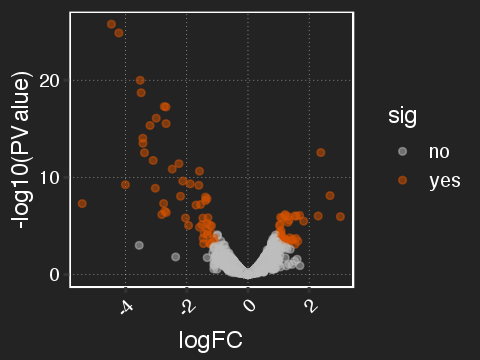

In [575]:
options(repr.plot.width = 4, repr.plot.height = 3)
ggplot(lrt.v.SpDE.tTags.table, aes(logFC, -log10(PValue), colour = sig)) + 
    geom_point(alpha = 0.5) + 
    geom_text_repel(data = filter(lrt.v.SpDE.tTags.table, sig == "yes" & -log10(PValue) > 100),aes(label=gene_name), 
                                force = 30,
                                colour = "green",
                                fontface = "bold", 
                                size = 3) +
    scale_colour_manual(values = c("gray", "#d55300")) +
    theme_monokai_full()

Now let's fine spermatheca-biased genes:

In [581]:
lrt.v.Sp <- glmLRT(dgeList.sp_fit, contrast = Spermatheca_contrast)
lrt.v.Sp.tTags <- topTags(lrt.v.Sp, n = NULL)
lrt.v.Sp.tTags.table <- lrt.v.Sp.tTags$table
lrt.v.Sp.tTags.table$sig = ifelse(lrt.v.Sp.tTags.table$FDR < 0.05 & (lrt.v.Sp.tTags.table$logFC > 1 | lrt.v.Sp.tTags.table$logFC < -1), "yes", "no")
Spermatheca_genes = subset(lrt.v.Sp.tTags.table, sig == "yes" & logFC > 1)$ref_gene_id
length(Spermatheca_genes)
head(lrt.v.Sp.tTags.table)

[1] 332

GeneID      gene_name          ref_gene_id logFC    logCPM    
MSTRG.1559  MSTRG.1559  snoRNA:Me18S-C1831 FBgn0065053 8.821024  2.6094312
MSTRG.9413  MSTRG.9413  CG32277            FBgn0052277 9.189945  4.3556871
MSTRG.14563 MSTRG.14563 snoRNA:Me18S-C1096 FBgn0086055 7.253025  1.2321748
MSTRG.12708 MSTRG.12708 snoRNA:Me28S-G764  FBgn0020518 7.216221  0.9970577
MSTRG.21799 MSTRG.21799 pre-rRNA:CR45856   FBgn0267516 5.998151 13.9836917
MSTRG.3203  MSTRG.3203  Send2              FBgn0264253 8.433403  1.4099548
            LR       PValue        FDR           sig
MSTRG.1559  737.5299 2.064780e-162 2.577464e-158 yes
MSTRG.9413  490.4084 1.161306e-108 7.248291e-105 yes
MSTRG.14563 424.3335  2.781074e-94  1.157205e-90 yes
MSTRG.12708 365.5667  1.727691e-81  5.391693e-78 yes
MSTRG.21799 243.4480  6.964730e-55  1.738815e-51 yes
MSTRG.3203  141.2744  1.401322e-32  2.915451e-29 yes

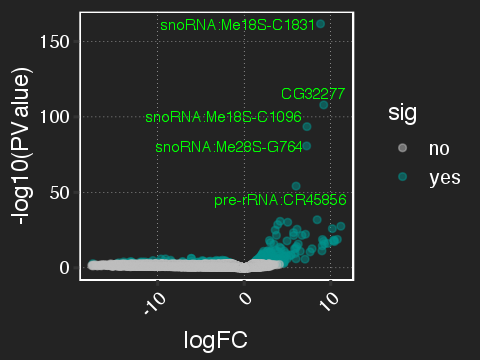

In [582]:
options(repr.plot.width = 4, repr.plot.height = 3)
ggplot(lrt.v.Sp.tTags.table, aes(logFC, -log10(PValue), colour = sig)) + 
    geom_point(alpha = 0.5) + 
    geom_text_repel(data = filter(lrt.v.Sp.tTags.table, sig == "yes" & -log10(PValue) > 50),aes(label=gene_name), 
                                force = 30,
                                colour = "green",
                                fontface = "bold", 
                                size = 3) +
    scale_colour_manual(values = c("gray", "#00918c")) +
    theme_monokai_full()

Looks like there's a lot of them. Let's make a heatmap instead:

Warning message in brewer.pal(2, "Set2"):
"minimal value for n is 3, returning requested palette with 3 different levels
"

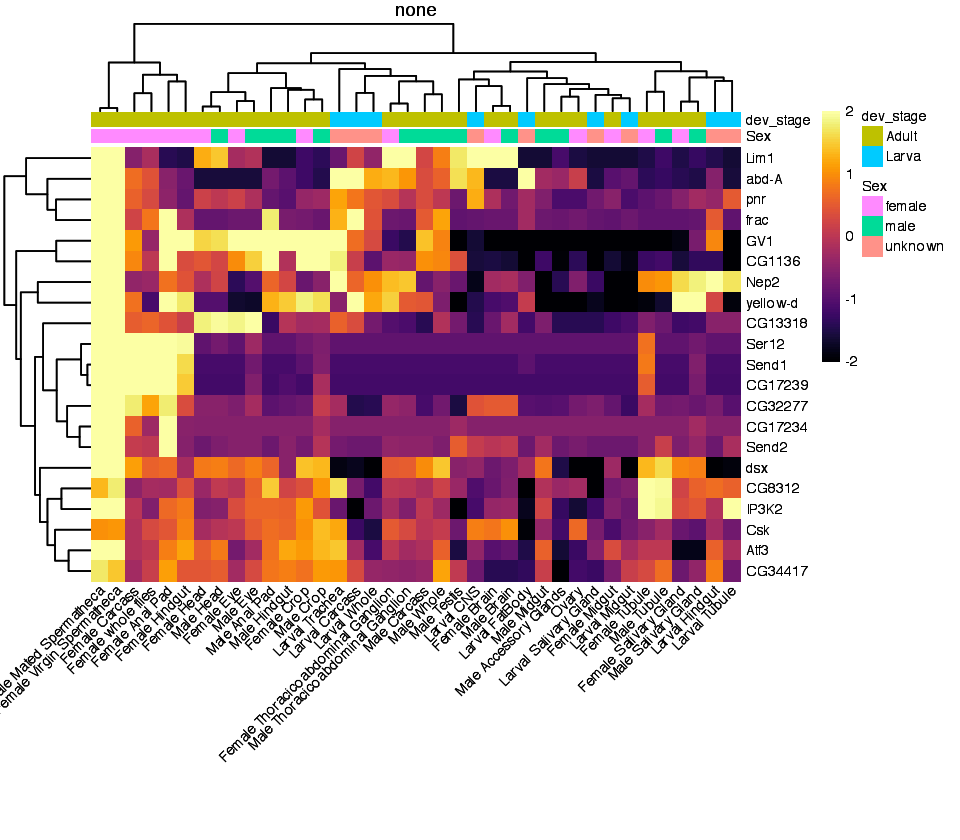

In [584]:
# mel_rt_orths = as.character(unique(subset(melOrths, FBgn_ID %in% fRT.list.10fold)$mel_FBgn_ID))

options(repr.plot.width = 8, repr.plot.height =7)
heatmap_fa2(tpm.matrix_fa2, as.character(subset(annotation, primary_FBgn %in% transCand.pasa_elements$`Dmel,Dvir`)$primary_FBgn), fly_atlas = T, title = "none")

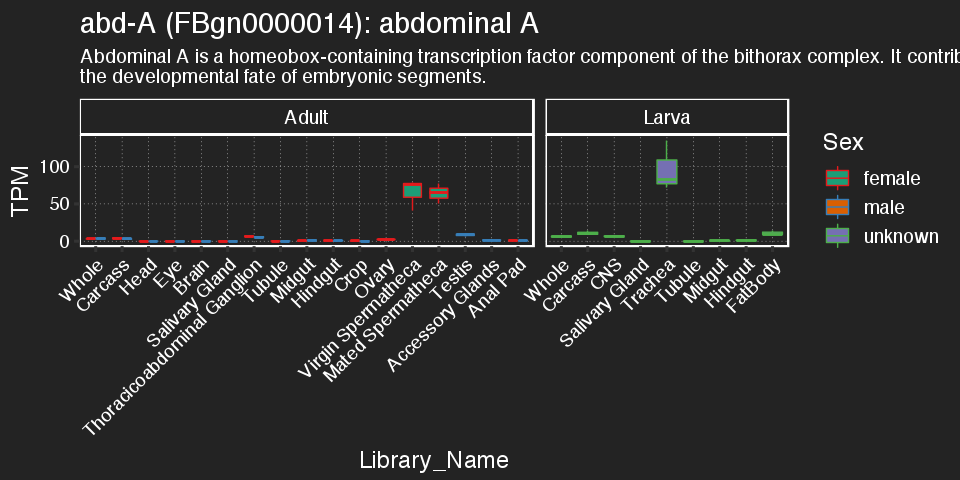

In [580]:
options(repr.plot.width = 8, repr.plot.height = 4)
geneBoxPlot_fa2(tpm.table, "abd-A")

Let's check the overlap between virilis female RT genes and _D. mel_ fRT genes:

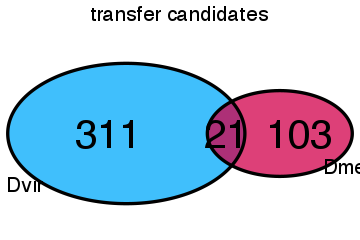

In [583]:
transCand.pasa_candidates <- list(Dmel = mel_rt_orths, Dvir = Spermatheca_genes)

transCand.pasa_Vdiag<-venn.diagram(transCand.pasa_candidates, NULL, fill=c("#d1004b", "#01aafb"), alpha=c(0.75,0.75), cex = 2, cat.fontface= 6, cat.cex = 1, resolution = 1000)

transCand.pasa_combs <- unlist(lapply(1:length(transCand.pasa_candidates), function(j) combn(names(transCand.pasa_candidates), j, simplify = FALSE)), recursive = FALSE)
names(transCand.pasa_combs) <- sapply(transCand.pasa_combs, function(i) paste0(i, collapse = ","))
    
transCand.pasa_elements <- lapply(transCand.pasa_combs, function(i) Setdiff(transCand.pasa_candidates[i], transCand.pasa_candidates[setdiff(names(transCand.pasa_candidates), i)]))
    
options(repr.plot.width = 3, repr.plot.height = 2)
grid.arrange(gTree(children=transCand.pasa_Vdiag), top = "transfer candidates")

Here's a plot for genes that are orthologus to a given virilis gene list:

Warning message in brewer.pal(2, "Set2"):
"minimal value for n is 3, returning requested palette with 3 different levels
"

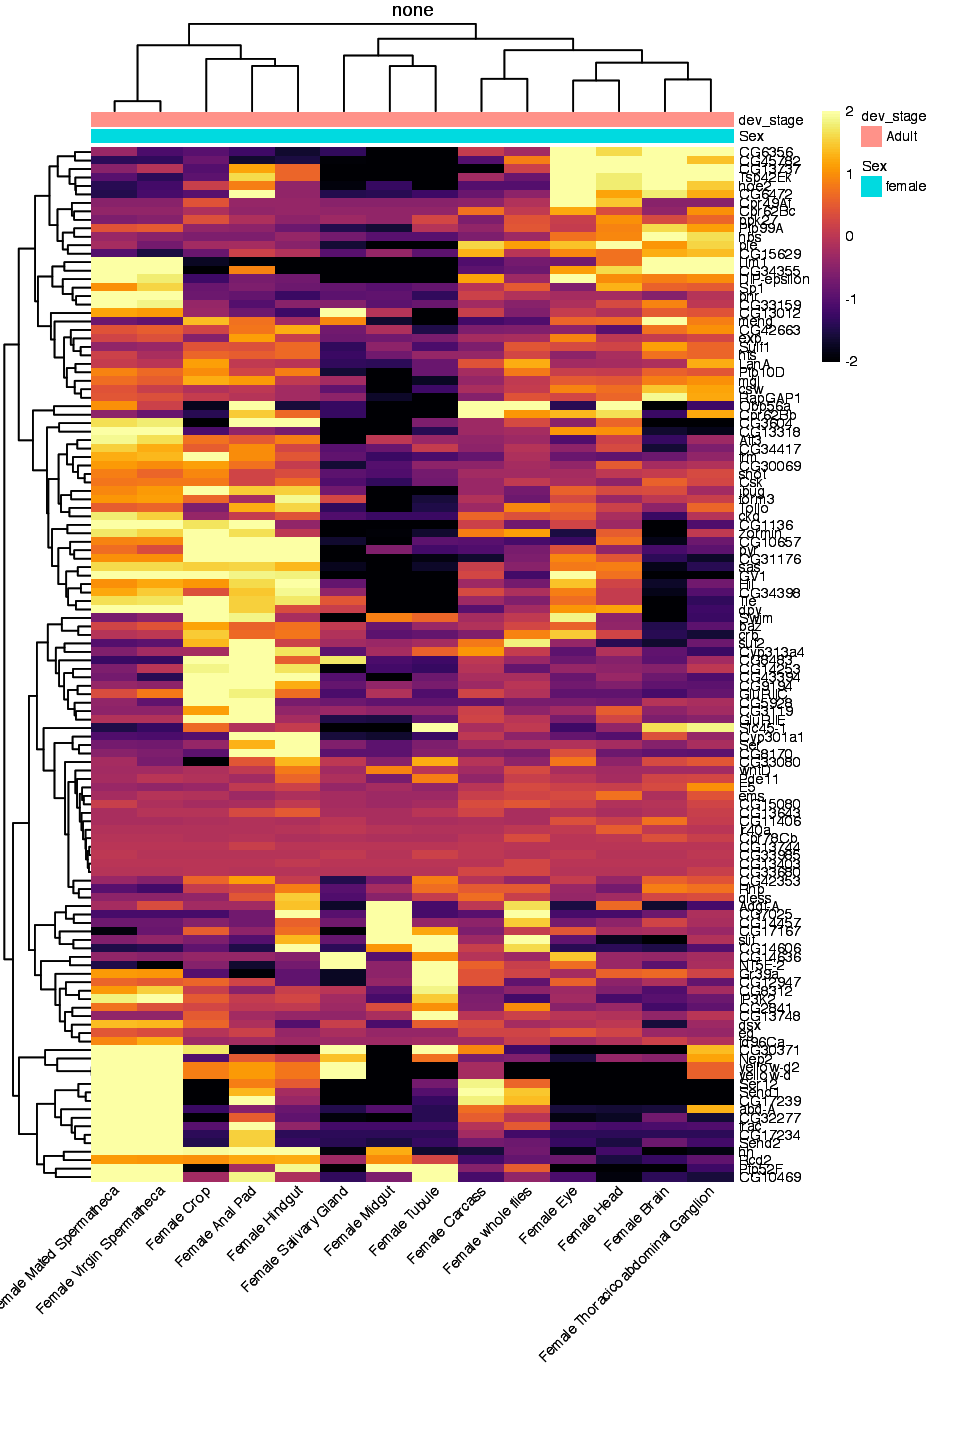

In [537]:
mel_rt_orths = as.character(unique(subset(melOrths, FBgn_ID %in% fRT.list)$mel_FBgn_ID))

options(repr.plot.width = 8, repr.plot.height =12)
heatmap_fa2(select(tpm.matrix_fa2, contains("Female")), mel_rt_orths, fly_atlas = T, title = "none")